## ML-Leaks adversary 3 vs. a distilled network
This notebook pits the ML-adversary attack 3 against a trained network and a distilled version of the same to test the effect of distillation defense

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
import numpy as np 
import matplotlib.pyplot as plt
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from models import save_checkpoint, load_checkpoint

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jul  6 2018, 19:12:46) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


### Hyperparameters & constants

In [25]:
# Hyperparams
n_epochs = 50
batch_size = 64
lr = 0.01
criterion = nn.CrossEntropyLoss() #loss function
# Constants
retrain = False #Flag to select cells to run
distill = True
data_dir = '../../../../Datasets/'
n_classes = 10
rgb_mean = (0.485, 0.456, 0.406)
rgb_std = (0.229, 0.224, 0.225)

### Helper functions for images and tansforms

In [3]:
def deprocess(image):
    return image * torch.Tensor(rgb_std)  + torch.Tensor(rgb_mean)

def imshow(img):
    img = img.permute(1,2,0)
    view_img = deprocess(img)
    view_img = np.array(view_img)
    plt.imshow(view_img)

### Dataset - CIFAR10

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.CenterCrop(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(rgb_mean, rgb_std)
])
trainset = torchvision.datasets.CIFAR10(data_dir, train=True, transform=transform,download=True)
testset = torchvision.datasets.CIFAR10(data_dir, train=False, transform=transform,download=True)

Files already downloaded and verified
Files already downloaded and verified


### Split the trainset into in an out of set

In [5]:
indices = list(range(len(trainset)))
split = len(trainset)//2
target_train_idx = SubsetRandomSampler(indices[:split])
target_out_idx = SubsetRandomSampler(indices[split:])

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, 
                                           sampler = target_train_idx, num_workers=8)
out_loader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, 
                                         sampler = target_out_idx, num_workers=8)

test_set = torchvision.datasets.CIFAR10(data_dir, train=False, transform=transform,download=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size = batch_size, num_workers=8)

Files already downloaded and verified


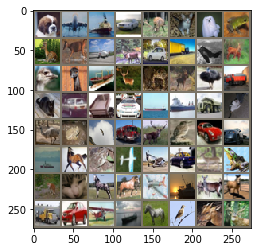

In [7]:
imgs,labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(imgs)) 

## Target model
Use transfer learning to use VGG11 (pretrained ImageNet) for CIFAR10 images.  Training is done in two step process:
1. Replace classifier layers with a new one matching CIFAR number of classes. Freeze the rest of the network (feature extractor) and train.
2. Unfreeze entire network and fine tune with smaller learning rate

In [8]:
if retrain:
    vgg11 = torchvision.models.vgg11(pretrained = True)
    for param in vgg11.parameters():
        param.requires_grad =False
    print(vgg11)

In [9]:
if retrain:
    vgg11.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 10),
            )
    vgg11.to(device)

In [10]:
if retrain:
    optimizer = optim.SGD(vgg11.classifier.parameters(), lr = 0.001, momentum=0.9)
    train(vgg11, train_loader, test_loader, optimizer, criterion, 20, verbose=True)

### Half point Performance
Training vgg11.classifier only

Set-up:
 - Epochs: 10
 - optimizer: SGD
 - lr: 0.001
 - momentum: 0.9
 
Results:
 - Training/Validation: 71.15%/67.7% 
 
 ### Fine tunning

In [11]:
if retrain:
    for param in vgg11.parameters():
        param.requires_grad = True
    optimizer = optim.SGD(vgg11.parameters(), lr = 0.0001, momentum=0.9)
    train(vgg11, train_loader, test_loader, optimizer, criterion, 20, verbose=True)

### Final Performance
Training vgg11.classifier only

Set-up:
 - Epochs: 20
 - optimizer: SGD
 - lr: 0.0001
 - momentum: 0.9
 
Results:
 - Training/Validation: 92.43%/80.74% 
 
Save the model/optimizer checkpoint with relevant details and start model distillation

In [24]:
if retrain:
    save_checkpoint(model=vgg11, accuracy={'Train':92.43, 'Test':80.74}, loss=0.41, epoch = 40,
                    data_descriptor='CIFAR10 - half dataset', optimizer=optimizer,
                    path='../../../Trained_models/CIFAR10/',filename = 'half_CIFAR10_vgg11')
else:
    vgg11 = torchvision.models.vgg11(pretrained = False)
    vgg11.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 10),
            )    
    load_checkpoint(model=vgg11, checkpoint='../../../Trained_models/CIFAR10/half_CIFAR10_vgg11.pth.tar')
    vgg11.to(device)
    print("Validate load\nTrain:")
    eval_target_net(vgg11, train_loader)
    print("Test:")
    eval_target_net(vgg11, test_loader)

Succesfully loaded checkpoint 
Dataset: CIFAR10 - half dataset 
Epoch: 40 
Loss: 0.41
Accuracy: {'Train': 92.43, 'Test': 80.74}
Validate load
Train:

Accuracy = 92.43 %


Test:

Accuracy = 80.74 %




## Distillation
For distillation we train a second vgg11 network on the logits of this first one in order to boslter the model's robustness. To speed up the training and bolster performance we start, again, from a pre-trained VGG11 (ImageNet) and follow the same procedure for transfer learning.

In [26]:
if distill:
    distilled_vgg11 = torchvision.models.vgg11(pretrained = True)
    for param in distilled_vgg11.parameters():
        param.requires_grad =False
    print(distilled_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [27]:
if distill:
    distilled_vgg11.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 10),
            )
    distilled_vgg11.to(device)

### Training
Use implemented distillation training routing and softCrossEntropy loss (generalized for soft labels). To be safe, we freeze the teacher network parameters.

In [28]:
if distill:
    criterion = softCrossEntropy()
    optimizer = optim.SGD(distilled_vgg11.classifier.parameters(), lr = 0.0001, momentum=0.9)
    for param in vgg11.parameters():
        param.requires_grad = False

In [29]:
if distill:
    distill_training(teacher=vgg11, learner=distilled_vgg11, data_loader=train_loader, test_loader=test_loader,
                     optimizer = optimizer, criterion=criterion, n_epochs=10, verbose=True)

[0/10][0/391] loss = 125.003754
[0/10][1/391] loss = 122.076836
[0/10][2/391] loss = 119.922371
[0/10][3/391] loss = 112.977615
[0/10][4/391] loss = 117.469048
[0/10][5/391] loss = 122.544868
[0/10][6/391] loss = 115.138359
[0/10][7/391] loss = 120.953812
[0/10][8/391] loss = 119.108932
[0/10][9/391] loss = 119.664009
[0/10][10/391] loss = 118.029243
[0/10][11/391] loss = 123.773827
[0/10][12/391] loss = 118.718620
[0/10][13/391] loss = 116.216255
[0/10][14/391] loss = 116.031479
[0/10][15/391] loss = 119.403290
[0/10][16/391] loss = 121.949142
[0/10][17/391] loss = 117.331047
[0/10][18/391] loss = 110.920898
[0/10][19/391] loss = 120.112701
[0/10][20/391] loss = 117.098259
[0/10][21/391] loss = 120.711235
[0/10][22/391] loss = 117.025673
[0/10][23/391] loss = 112.732071
[0/10][24/391] loss = 119.062531
[0/10][25/391] loss = 121.746857
[0/10][26/391] loss = 116.091263
[0/10][27/391] loss = 114.790604
[0/10][28/391] loss = 117.788239
[0/10][29/391] loss = 117.889870
[0/10][30/391] loss 

[0/10][254/391] loss = 71.923149
[0/10][255/391] loss = 70.194817
[0/10][256/391] loss = 62.831913
[0/10][257/391] loss = 66.997627
[0/10][258/391] loss = 77.435905
[0/10][259/391] loss = 60.857880
[0/10][260/391] loss = 64.021622
[0/10][261/391] loss = 60.511410
[0/10][262/391] loss = 67.849197
[0/10][263/391] loss = 74.879257
[0/10][264/391] loss = 60.074207
[0/10][265/391] loss = 58.095417
[0/10][266/391] loss = 68.662331
[0/10][267/391] loss = 70.553993
[0/10][268/391] loss = 64.322693
[0/10][269/391] loss = 73.892792
[0/10][270/391] loss = 59.652195
[0/10][271/391] loss = 65.481476
[0/10][272/391] loss = 63.080536
[0/10][273/391] loss = 64.212852
[0/10][274/391] loss = 71.077660
[0/10][275/391] loss = 59.677254
[0/10][276/391] loss = 63.339859
[0/10][277/391] loss = 60.755619
[0/10][278/391] loss = 61.451492
[0/10][279/391] loss = 71.306023
[0/10][280/391] loss = 59.218182
[0/10][281/391] loss = 60.960445
[0/10][282/391] loss = 62.889198
[0/10][283/391] loss = 79.166664
[0/10][284

[1/10][125/391] loss = 56.545162
[1/10][126/391] loss = 59.970921
[1/10][127/391] loss = 49.776085
[1/10][128/391] loss = 61.152386
[1/10][129/391] loss = 53.361229
[1/10][130/391] loss = 56.112755
[1/10][131/391] loss = 50.574955
[1/10][132/391] loss = 54.435600
[1/10][133/391] loss = 57.290459
[1/10][134/391] loss = 59.565228
[1/10][135/391] loss = 60.200371
[1/10][136/391] loss = 51.644310
[1/10][137/391] loss = 50.545818
[1/10][138/391] loss = 54.743797
[1/10][139/391] loss = 64.557571
[1/10][140/391] loss = 52.346046
[1/10][141/391] loss = 61.006065
[1/10][142/391] loss = 53.030468
[1/10][143/391] loss = 54.306099
[1/10][144/391] loss = 57.522388
[1/10][145/391] loss = 51.979088
[1/10][146/391] loss = 49.795002
[1/10][147/391] loss = 60.419365
[1/10][148/391] loss = 55.284180
[1/10][149/391] loss = 52.551044
[1/10][150/391] loss = 55.278118
[1/10][151/391] loss = 60.609673
[1/10][152/391] loss = 53.538677
[1/10][153/391] loss = 54.560688
[1/10][154/391] loss = 55.263859
[1/10][155

[1/10][376/391] loss = 49.399136
[1/10][377/391] loss = 49.560276
[1/10][378/391] loss = 37.515610
[1/10][379/391] loss = 53.158813
[1/10][380/391] loss = 55.724831
[1/10][381/391] loss = 51.740639
[1/10][382/391] loss = 52.068787
[1/10][383/391] loss = 47.690514
[1/10][384/391] loss = 57.005280
[1/10][385/391] loss = 49.971642
[1/10][386/391] loss = 53.850376
[1/10][387/391] loss = 48.284325
[1/10][388/391] loss = 49.554283
[1/10][389/391] loss = 46.604740
[1/10][390/391] loss = 31.639189
[1/10]
Training:

Accuracy = 66.07 %


Test:

Accuracy = 64.82 %


[2/10][0/391] loss = 51.611908
[2/10][1/391] loss = 55.088142
[2/10][2/391] loss = 46.606182
[2/10][3/391] loss = 43.992970
[2/10][4/391] loss = 57.213829
[2/10][5/391] loss = 69.195992
[2/10][6/391] loss = 58.360107
[2/10][7/391] loss = 58.245811
[2/10][8/391] loss = 54.059990
[2/10][9/391] loss = 63.683006
[2/10][10/391] loss = 56.698944
[2/10][11/391] loss = 42.409172
[2/10][12/391] loss = 42.319546
[2/10][13/391] loss = 53.923920


[2/10][236/391] loss = 49.899426
[2/10][237/391] loss = 43.855328
[2/10][238/391] loss = 54.056290
[2/10][239/391] loss = 63.890545
[2/10][240/391] loss = 45.795647
[2/10][241/391] loss = 49.632919
[2/10][242/391] loss = 45.114532
[2/10][243/391] loss = 47.183918
[2/10][244/391] loss = 53.770889
[2/10][245/391] loss = 50.934608
[2/10][246/391] loss = 44.137341
[2/10][247/391] loss = 46.053890
[2/10][248/391] loss = 56.529919
[2/10][249/391] loss = 58.931812
[2/10][250/391] loss = 44.712734
[2/10][251/391] loss = 35.699970
[2/10][252/391] loss = 53.584492
[2/10][253/391] loss = 47.400291
[2/10][254/391] loss = 38.275143
[2/10][255/391] loss = 42.972675
[2/10][256/391] loss = 56.064987
[2/10][257/391] loss = 55.390358
[2/10][258/391] loss = 50.898407
[2/10][259/391] loss = 42.199772
[2/10][260/391] loss = 42.691936
[2/10][261/391] loss = 63.167187
[2/10][262/391] loss = 60.933983
[2/10][263/391] loss = 55.663723
[2/10][264/391] loss = 53.184601
[2/10][265/391] loss = 61.578007
[2/10][266

[3/10][97/391] loss = 42.351166
[3/10][98/391] loss = 37.340603
[3/10][99/391] loss = 43.047344
[3/10][100/391] loss = 45.632957
[3/10][101/391] loss = 49.652657
[3/10][102/391] loss = 44.196449
[3/10][103/391] loss = 42.413063
[3/10][104/391] loss = 52.664993
[3/10][105/391] loss = 46.521629
[3/10][106/391] loss = 39.906330
[3/10][107/391] loss = 46.556740
[3/10][108/391] loss = 47.806145
[3/10][109/391] loss = 51.323723
[3/10][110/391] loss = 53.480179
[3/10][111/391] loss = 51.047691
[3/10][112/391] loss = 41.158337
[3/10][113/391] loss = 54.067444
[3/10][114/391] loss = 46.757217
[3/10][115/391] loss = 53.821644
[3/10][116/391] loss = 39.453697
[3/10][117/391] loss = 40.293663
[3/10][118/391] loss = 54.823879
[3/10][119/391] loss = 41.646553
[3/10][120/391] loss = 51.371010
[3/10][121/391] loss = 39.382652
[3/10][122/391] loss = 45.742455
[3/10][123/391] loss = 35.452137
[3/10][124/391] loss = 48.759212
[3/10][125/391] loss = 39.692528
[3/10][126/391] loss = 48.480225
[3/10][127/39

[3/10][346/391] loss = 44.405979
[3/10][347/391] loss = 47.512939
[3/10][348/391] loss = 40.376751
[3/10][349/391] loss = 40.570530
[3/10][350/391] loss = 38.273945
[3/10][351/391] loss = 43.597382
[3/10][352/391] loss = 47.320286
[3/10][353/391] loss = 44.905109
[3/10][354/391] loss = 46.083969
[3/10][355/391] loss = 43.160259
[3/10][356/391] loss = 52.177799
[3/10][357/391] loss = 47.186451
[3/10][358/391] loss = 51.766140
[3/10][359/391] loss = 49.282440
[3/10][360/391] loss = 57.354939
[3/10][361/391] loss = 65.579529
[3/10][362/391] loss = 43.484947
[3/10][363/391] loss = 52.033951
[3/10][364/391] loss = 51.579830
[3/10][365/391] loss = 52.054981
[3/10][366/391] loss = 44.103928
[3/10][367/391] loss = 49.585106
[3/10][368/391] loss = 44.929127
[3/10][369/391] loss = 44.331326
[3/10][370/391] loss = 38.216793
[3/10][371/391] loss = 44.703125
[3/10][372/391] loss = 44.355694
[3/10][373/391] loss = 39.235855
[3/10][374/391] loss = 57.885891
[3/10][375/391] loss = 45.408894
[3/10][376

[4/10][206/391] loss = 46.858727
[4/10][207/391] loss = 44.786644
[4/10][208/391] loss = 48.875748
[4/10][209/391] loss = 55.060658
[4/10][210/391] loss = 40.759121
[4/10][211/391] loss = 57.688793
[4/10][212/391] loss = 43.439381
[4/10][213/391] loss = 40.033104
[4/10][214/391] loss = 55.761269
[4/10][215/391] loss = 32.569984
[4/10][216/391] loss = 51.176193
[4/10][217/391] loss = 50.791828
[4/10][218/391] loss = 42.147446
[4/10][219/391] loss = 55.783939
[4/10][220/391] loss = 56.518177
[4/10][221/391] loss = 36.131500
[4/10][222/391] loss = 45.552143
[4/10][223/391] loss = 51.928371
[4/10][224/391] loss = 46.288097
[4/10][225/391] loss = 43.573849
[4/10][226/391] loss = 47.831909
[4/10][227/391] loss = 54.263741
[4/10][228/391] loss = 36.168301
[4/10][229/391] loss = 48.439743
[4/10][230/391] loss = 48.222488
[4/10][231/391] loss = 44.393169
[4/10][232/391] loss = 49.583477
[4/10][233/391] loss = 61.501438
[4/10][234/391] loss = 36.786835
[4/10][235/391] loss = 43.498177
[4/10][236

[5/10][70/391] loss = 53.209793
[5/10][71/391] loss = 45.194012
[5/10][72/391] loss = 36.485943
[5/10][73/391] loss = 37.532707
[5/10][74/391] loss = 49.463997
[5/10][75/391] loss = 38.791168
[5/10][76/391] loss = 44.485542
[5/10][77/391] loss = 42.816784
[5/10][78/391] loss = 42.873222
[5/10][79/391] loss = 40.492416
[5/10][80/391] loss = 41.943077
[5/10][81/391] loss = 51.618908
[5/10][82/391] loss = 44.930561
[5/10][83/391] loss = 45.481785
[5/10][84/391] loss = 37.443283
[5/10][85/391] loss = 42.529926
[5/10][86/391] loss = 46.277271
[5/10][87/391] loss = 62.719242
[5/10][88/391] loss = 48.038425
[5/10][89/391] loss = 31.530584
[5/10][90/391] loss = 40.088623
[5/10][91/391] loss = 39.813828
[5/10][92/391] loss = 28.102560
[5/10][93/391] loss = 41.948063
[5/10][94/391] loss = 40.480377
[5/10][95/391] loss = 43.113319
[5/10][96/391] loss = 44.584637
[5/10][97/391] loss = 49.975170
[5/10][98/391] loss = 52.629189
[5/10][99/391] loss = 46.221947
[5/10][100/391] loss = 38.960423
[5/10][

[5/10][321/391] loss = 43.952530
[5/10][322/391] loss = 53.128555
[5/10][323/391] loss = 41.160534
[5/10][324/391] loss = 38.490208
[5/10][325/391] loss = 47.529137
[5/10][326/391] loss = 39.369770
[5/10][327/391] loss = 43.795780
[5/10][328/391] loss = 32.315685
[5/10][329/391] loss = 46.859608
[5/10][330/391] loss = 57.177952
[5/10][331/391] loss = 42.663181
[5/10][332/391] loss = 51.111027
[5/10][333/391] loss = 43.667038
[5/10][334/391] loss = 34.648064
[5/10][335/391] loss = 36.497314
[5/10][336/391] loss = 40.758442
[5/10][337/391] loss = 44.813332
[5/10][338/391] loss = 39.808720
[5/10][339/391] loss = 41.958645
[5/10][340/391] loss = 54.944645
[5/10][341/391] loss = 52.940487
[5/10][342/391] loss = 38.896759
[5/10][343/391] loss = 46.500938
[5/10][344/391] loss = 33.996143
[5/10][345/391] loss = 42.806030
[5/10][346/391] loss = 52.124161
[5/10][347/391] loss = 37.233204
[5/10][348/391] loss = 45.409389
[5/10][349/391] loss = 45.868900
[5/10][350/391] loss = 41.717590
[5/10][351

[6/10][182/391] loss = 47.958717
[6/10][183/391] loss = 48.906498
[6/10][184/391] loss = 40.691952
[6/10][185/391] loss = 45.580555
[6/10][186/391] loss = 52.821941
[6/10][187/391] loss = 58.820503
[6/10][188/391] loss = 40.957977
[6/10][189/391] loss = 37.785164
[6/10][190/391] loss = 53.005566
[6/10][191/391] loss = 49.764172
[6/10][192/391] loss = 33.006882
[6/10][193/391] loss = 51.402603
[6/10][194/391] loss = 40.211887
[6/10][195/391] loss = 41.261082
[6/10][196/391] loss = 27.865549
[6/10][197/391] loss = 36.299919
[6/10][198/391] loss = 47.612019
[6/10][199/391] loss = 35.823429
[6/10][200/391] loss = 42.090767
[6/10][201/391] loss = 38.009323
[6/10][202/391] loss = 48.377571
[6/10][203/391] loss = 36.999233
[6/10][204/391] loss = 38.370602
[6/10][205/391] loss = 41.049595
[6/10][206/391] loss = 42.050552
[6/10][207/391] loss = 43.353687
[6/10][208/391] loss = 40.016365
[6/10][209/391] loss = 40.251659
[6/10][210/391] loss = 56.900673
[6/10][211/391] loss = 43.856274
[6/10][212

[7/10][42/391] loss = 46.103222
[7/10][43/391] loss = 41.216976
[7/10][44/391] loss = 33.745090
[7/10][45/391] loss = 44.817223
[7/10][46/391] loss = 48.002979
[7/10][47/391] loss = 46.814857
[7/10][48/391] loss = 40.415413
[7/10][49/391] loss = 43.666748
[7/10][50/391] loss = 43.838058
[7/10][51/391] loss = 42.797901
[7/10][52/391] loss = 38.691288
[7/10][53/391] loss = 34.094833
[7/10][54/391] loss = 46.372517
[7/10][55/391] loss = 30.403025
[7/10][56/391] loss = 48.652222
[7/10][57/391] loss = 41.207996
[7/10][58/391] loss = 36.950726
[7/10][59/391] loss = 57.475163
[7/10][60/391] loss = 41.345924
[7/10][61/391] loss = 31.697104
[7/10][62/391] loss = 42.166496
[7/10][63/391] loss = 36.711456
[7/10][64/391] loss = 26.054228
[7/10][65/391] loss = 46.511757
[7/10][66/391] loss = 33.326134
[7/10][67/391] loss = 40.771141
[7/10][68/391] loss = 34.490021
[7/10][69/391] loss = 37.299839
[7/10][70/391] loss = 40.311966
[7/10][71/391] loss = 33.748058
[7/10][72/391] loss = 30.771988
[7/10][7

[7/10][294/391] loss = 42.049641
[7/10][295/391] loss = 36.019695
[7/10][296/391] loss = 38.461964
[7/10][297/391] loss = 45.407360
[7/10][298/391] loss = 38.167645
[7/10][299/391] loss = 39.415585
[7/10][300/391] loss = 31.346273
[7/10][301/391] loss = 35.027126
[7/10][302/391] loss = 35.280186
[7/10][303/391] loss = 52.337444
[7/10][304/391] loss = 33.356075
[7/10][305/391] loss = 37.617542
[7/10][306/391] loss = 46.110428
[7/10][307/391] loss = 46.604301
[7/10][308/391] loss = 34.727154
[7/10][309/391] loss = 45.991653
[7/10][310/391] loss = 43.425018
[7/10][311/391] loss = 33.484772
[7/10][312/391] loss = 50.098038
[7/10][313/391] loss = 33.413200
[7/10][314/391] loss = 34.209938
[7/10][315/391] loss = 39.391312
[7/10][316/391] loss = 46.875477
[7/10][317/391] loss = 44.635384
[7/10][318/391] loss = 32.191181
[7/10][319/391] loss = 35.244122
[7/10][320/391] loss = 55.167053
[7/10][321/391] loss = 47.761234
[7/10][322/391] loss = 41.821190
[7/10][323/391] loss = 44.063564
[7/10][324

[8/10][154/391] loss = 42.330299
[8/10][155/391] loss = 38.687462
[8/10][156/391] loss = 40.595898
[8/10][157/391] loss = 44.928719
[8/10][158/391] loss = 37.976585
[8/10][159/391] loss = 46.621380
[8/10][160/391] loss = 39.377579
[8/10][161/391] loss = 31.308084
[8/10][162/391] loss = 43.893982
[8/10][163/391] loss = 39.621548
[8/10][164/391] loss = 40.413189
[8/10][165/391] loss = 33.207787
[8/10][166/391] loss = 44.503445
[8/10][167/391] loss = 48.405586
[8/10][168/391] loss = 31.333439
[8/10][169/391] loss = 37.884064
[8/10][170/391] loss = 34.241589
[8/10][171/391] loss = 50.736423
[8/10][172/391] loss = 40.768444
[8/10][173/391] loss = 38.071674
[8/10][174/391] loss = 43.041431
[8/10][175/391] loss = 43.519585
[8/10][176/391] loss = 31.222908
[8/10][177/391] loss = 43.706745
[8/10][178/391] loss = 27.502071
[8/10][179/391] loss = 36.994625
[8/10][180/391] loss = 38.197678
[8/10][181/391] loss = 42.529690
[8/10][182/391] loss = 36.082596
[8/10][183/391] loss = 51.337963
[8/10][184

[9/10][14/391] loss = 39.627979
[9/10][15/391] loss = 39.632656
[9/10][16/391] loss = 42.929607
[9/10][17/391] loss = 33.563618
[9/10][18/391] loss = 40.301632
[9/10][19/391] loss = 39.485794
[9/10][20/391] loss = 35.240639
[9/10][21/391] loss = 56.146858
[9/10][22/391] loss = 48.963509
[9/10][23/391] loss = 48.071930
[9/10][24/391] loss = 46.373829
[9/10][25/391] loss = 40.400764
[9/10][26/391] loss = 35.740871
[9/10][27/391] loss = 47.897030
[9/10][28/391] loss = 31.078007
[9/10][29/391] loss = 56.151436
[9/10][30/391] loss = 32.706509
[9/10][31/391] loss = 37.814270
[9/10][32/391] loss = 36.007427
[9/10][33/391] loss = 44.333538
[9/10][34/391] loss = 42.791210
[9/10][35/391] loss = 37.769539
[9/10][36/391] loss = 46.566273
[9/10][37/391] loss = 28.608965
[9/10][38/391] loss = 39.568668
[9/10][39/391] loss = 39.963490
[9/10][40/391] loss = 43.015385
[9/10][41/391] loss = 44.315876
[9/10][42/391] loss = 37.315605
[9/10][43/391] loss = 31.322330
[9/10][44/391] loss = 54.549740
[9/10][4

[9/10][266/391] loss = 32.924690
[9/10][267/391] loss = 43.842216
[9/10][268/391] loss = 41.561485
[9/10][269/391] loss = 43.147011
[9/10][270/391] loss = 42.373817
[9/10][271/391] loss = 39.877392
[9/10][272/391] loss = 41.644768
[9/10][273/391] loss = 41.123699
[9/10][274/391] loss = 42.110939
[9/10][275/391] loss = 39.539497
[9/10][276/391] loss = 48.846233
[9/10][277/391] loss = 50.552994
[9/10][278/391] loss = 34.882572
[9/10][279/391] loss = 41.474628
[9/10][280/391] loss = 34.326328
[9/10][281/391] loss = 32.828159
[9/10][282/391] loss = 30.830870
[9/10][283/391] loss = 40.548916
[9/10][284/391] loss = 38.865574
[9/10][285/391] loss = 46.850586
[9/10][286/391] loss = 36.189014
[9/10][287/391] loss = 38.388588
[9/10][288/391] loss = 36.643131
[9/10][289/391] loss = 36.726654
[9/10][290/391] loss = 33.801197
[9/10][291/391] loss = 62.306931
[9/10][292/391] loss = 40.593758
[9/10][293/391] loss = 32.952541
[9/10][294/391] loss = 37.900768
[9/10][295/391] loss = 48.728310
[9/10][296

### Half point Performance
Training distilled_vgg11.classifier only

Set-up:
 - Epochs: 10
 - optimizer: SGD
 - lr: 0.0001
 - momentum: 0.9
 
Results:
 - Training/Validation: 72.0%/67.77% 
 
 ### Fine tunning

In [30]:
if distill:
    for param in distilled_vgg11.parameters():
        param.requires_grad = True
    optimizer = optim.SGD(distilled_vgg11.parameters(), lr = 0.00005, momentum=0.9)
    distill_training(teacher=vgg11, learner=distilled_vgg11, data_loader=train_loader, test_loader=test_loader,
                     optimizer = optimizer, criterion=criterion, n_epochs=7, verbose=True)

[0/7][0/391] loss = 33.699646
[0/7][1/391] loss = 43.967976
[0/7][2/391] loss = 33.383331
[0/7][3/391] loss = 47.472256
[0/7][4/391] loss = 52.026932
[0/7][5/391] loss = 34.535984
[0/7][6/391] loss = 46.107616
[0/7][7/391] loss = 51.400787
[0/7][8/391] loss = 43.602638
[0/7][9/391] loss = 40.712158
[0/7][10/391] loss = 52.727047
[0/7][11/391] loss = 52.540592
[0/7][12/391] loss = 52.411011
[0/7][13/391] loss = 52.348488
[0/7][14/391] loss = 42.504192
[0/7][15/391] loss = 53.086048
[0/7][16/391] loss = 47.081108
[0/7][17/391] loss = 47.753952
[0/7][18/391] loss = 45.474323
[0/7][19/391] loss = 55.651443
[0/7][20/391] loss = 59.337585
[0/7][21/391] loss = 37.679741
[0/7][22/391] loss = 44.338276
[0/7][23/391] loss = 51.063519
[0/7][24/391] loss = 61.921116
[0/7][25/391] loss = 51.671494
[0/7][26/391] loss = 55.982445
[0/7][27/391] loss = 49.102879
[0/7][28/391] loss = 65.716164
[0/7][29/391] loss = 54.490536
[0/7][30/391] loss = 52.734180
[0/7][31/391] loss = 50.194050
[0/7][32/391] loss

[0/7][266/391] loss = 20.312359
[0/7][267/391] loss = 25.343645
[0/7][268/391] loss = 23.065723
[0/7][269/391] loss = 25.951031
[0/7][270/391] loss = 22.595446
[0/7][271/391] loss = 22.742928
[0/7][272/391] loss = 24.957191
[0/7][273/391] loss = 24.050018
[0/7][274/391] loss = 22.198381
[0/7][275/391] loss = 39.406216
[0/7][276/391] loss = 25.381983
[0/7][277/391] loss = 29.911867
[0/7][278/391] loss = 30.809483
[0/7][279/391] loss = 18.311705
[0/7][280/391] loss = 25.607018
[0/7][281/391] loss = 31.567310
[0/7][282/391] loss = 24.013994
[0/7][283/391] loss = 31.280127
[0/7][284/391] loss = 26.335806
[0/7][285/391] loss = 30.909859
[0/7][286/391] loss = 17.664341
[0/7][287/391] loss = 22.439053
[0/7][288/391] loss = 19.483427
[0/7][289/391] loss = 18.436134
[0/7][290/391] loss = 33.683735
[0/7][291/391] loss = 33.885437
[0/7][292/391] loss = 28.448139
[0/7][293/391] loss = 23.262611
[0/7][294/391] loss = 19.962486
[0/7][295/391] loss = 29.137060
[0/7][296/391] loss = 30.375418
[0/7][29

[1/7][133/391] loss = 23.896915
[1/7][134/391] loss = 33.615520
[1/7][135/391] loss = 19.233665
[1/7][136/391] loss = 22.524401
[1/7][137/391] loss = 21.134254
[1/7][138/391] loss = 18.631014
[1/7][139/391] loss = 19.691063
[1/7][140/391] loss = 21.500538
[1/7][141/391] loss = 16.804430
[1/7][142/391] loss = 24.681236
[1/7][143/391] loss = 17.041351
[1/7][144/391] loss = 18.213718
[1/7][145/391] loss = 19.037804
[1/7][146/391] loss = 21.179869
[1/7][147/391] loss = 16.811039
[1/7][148/391] loss = 16.712494
[1/7][149/391] loss = 21.197727
[1/7][150/391] loss = 21.710415
[1/7][151/391] loss = 23.206871
[1/7][152/391] loss = 19.121778
[1/7][153/391] loss = 19.612783
[1/7][154/391] loss = 28.893011
[1/7][155/391] loss = 16.671333
[1/7][156/391] loss = 21.613869
[1/7][157/391] loss = 17.899744
[1/7][158/391] loss = 21.683020
[1/7][159/391] loss = 26.567339
[1/7][160/391] loss = 24.824081
[1/7][161/391] loss = 23.581823
[1/7][162/391] loss = 24.700560
[1/7][163/391] loss = 17.856506
[1/7][16


Accuracy = 85.38 %


Test:

Accuracy = 79.58 %


[2/7][0/391] loss = 15.395324
[2/7][1/391] loss = 11.411080
[2/7][2/391] loss = 12.787034
[2/7][3/391] loss = 10.846045
[2/7][4/391] loss = 13.263414
[2/7][5/391] loss = 25.081635
[2/7][6/391] loss = 13.623599
[2/7][7/391] loss = 18.661787
[2/7][8/391] loss = 24.097517
[2/7][9/391] loss = 15.614916
[2/7][10/391] loss = 13.803129
[2/7][11/391] loss = 21.239782
[2/7][12/391] loss = 20.539494
[2/7][13/391] loss = 13.330017
[2/7][14/391] loss = 13.191182
[2/7][15/391] loss = 12.959633
[2/7][16/391] loss = 13.873734
[2/7][17/391] loss = 18.246946
[2/7][18/391] loss = 19.537050
[2/7][19/391] loss = 15.304821
[2/7][20/391] loss = 21.746965
[2/7][21/391] loss = 24.189953
[2/7][22/391] loss = 25.269386
[2/7][23/391] loss = 16.053587
[2/7][24/391] loss = 13.900653
[2/7][25/391] loss = 8.038112
[2/7][26/391] loss = 11.912218
[2/7][27/391] loss = 16.959688
[2/7][28/391] loss = 17.229828
[2/7][29/391] loss = 13.948539
[2/7][30/391] loss = 14.496324


[2/7][259/391] loss = 18.278910
[2/7][260/391] loss = 16.662600
[2/7][261/391] loss = 19.803938
[2/7][262/391] loss = 16.891001
[2/7][263/391] loss = 13.099787
[2/7][264/391] loss = 18.760614
[2/7][265/391] loss = 13.154479
[2/7][266/391] loss = 11.444537
[2/7][267/391] loss = 12.048437
[2/7][268/391] loss = 11.860309
[2/7][269/391] loss = 7.465182
[2/7][270/391] loss = 14.594419
[2/7][271/391] loss = 18.719547
[2/7][272/391] loss = 12.749547
[2/7][273/391] loss = 16.681023
[2/7][274/391] loss = 18.220036
[2/7][275/391] loss = 19.574085
[2/7][276/391] loss = 12.329652
[2/7][277/391] loss = 10.202211
[2/7][278/391] loss = 11.667926
[2/7][279/391] loss = 13.195320
[2/7][280/391] loss = 16.488546
[2/7][281/391] loss = 12.715566
[2/7][282/391] loss = 19.109875
[2/7][283/391] loss = 13.178803
[2/7][284/391] loss = 16.994846
[2/7][285/391] loss = 11.841867
[2/7][286/391] loss = 14.915881
[2/7][287/391] loss = 12.736885
[2/7][288/391] loss = 15.744907
[2/7][289/391] loss = 12.235075
[2/7][290

[3/7][133/391] loss = 10.696697
[3/7][134/391] loss = 7.964976
[3/7][135/391] loss = 8.753725
[3/7][136/391] loss = 9.574697
[3/7][137/391] loss = 11.290392
[3/7][138/391] loss = 12.637823
[3/7][139/391] loss = 11.797145
[3/7][140/391] loss = 17.015137
[3/7][141/391] loss = 14.422098
[3/7][142/391] loss = 11.980313
[3/7][143/391] loss = 14.656107
[3/7][144/391] loss = 15.564385
[3/7][145/391] loss = 6.984059
[3/7][146/391] loss = 12.754552
[3/7][147/391] loss = 14.919793
[3/7][148/391] loss = 10.123551
[3/7][149/391] loss = 8.949384
[3/7][150/391] loss = 10.426577
[3/7][151/391] loss = 11.625013
[3/7][152/391] loss = 12.660022
[3/7][153/391] loss = 12.135263
[3/7][154/391] loss = 10.430075
[3/7][155/391] loss = 10.000614
[3/7][156/391] loss = 10.456304
[3/7][157/391] loss = 11.666239
[3/7][158/391] loss = 9.835519
[3/7][159/391] loss = 12.337131
[3/7][160/391] loss = 11.300210
[3/7][161/391] loss = 13.701591
[3/7][162/391] loss = 13.688520
[3/7][163/391] loss = 11.816921
[3/7][164/391]


Accuracy = 88.67 %


Test:

Accuracy = 81.51 %


[4/7][0/391] loss = 8.775916
[4/7][1/391] loss = 7.240300
[4/7][2/391] loss = 8.754449
[4/7][3/391] loss = 10.605625
[4/7][4/391] loss = 6.995207
[4/7][5/391] loss = 6.432837
[4/7][6/391] loss = 12.658596
[4/7][7/391] loss = 10.602400
[4/7][8/391] loss = 7.572693
[4/7][9/391] loss = 13.044393
[4/7][10/391] loss = 9.913178
[4/7][11/391] loss = 14.328701
[4/7][12/391] loss = 9.456447
[4/7][13/391] loss = 14.172421
[4/7][14/391] loss = 6.387650
[4/7][15/391] loss = 7.270210
[4/7][16/391] loss = 11.895215
[4/7][17/391] loss = 14.467418
[4/7][18/391] loss = 11.477014
[4/7][19/391] loss = 10.650428
[4/7][20/391] loss = 7.861701
[4/7][21/391] loss = 7.087074
[4/7][22/391] loss = 6.455984
[4/7][23/391] loss = 11.120547
[4/7][24/391] loss = 7.466477
[4/7][25/391] loss = 9.288508
[4/7][26/391] loss = 14.965263
[4/7][27/391] loss = 11.552721
[4/7][28/391] loss = 10.414056
[4/7][29/391] loss = 8.499938
[4/7][30/391] loss = 11.307045
[4/7][31/391] l

[4/7][266/391] loss = 7.328867
[4/7][267/391] loss = 6.518075
[4/7][268/391] loss = 11.761243
[4/7][269/391] loss = 10.923713
[4/7][270/391] loss = 7.874922
[4/7][271/391] loss = 11.795499
[4/7][272/391] loss = 6.971833
[4/7][273/391] loss = 11.807878
[4/7][274/391] loss = 15.178946
[4/7][275/391] loss = 7.963561
[4/7][276/391] loss = 10.332736
[4/7][277/391] loss = 11.886976
[4/7][278/391] loss = 11.541360
[4/7][279/391] loss = 7.742236
[4/7][280/391] loss = 7.825307
[4/7][281/391] loss = 8.403721
[4/7][282/391] loss = 8.318694
[4/7][283/391] loss = 7.529130
[4/7][284/391] loss = 9.404787
[4/7][285/391] loss = 7.547606
[4/7][286/391] loss = 10.271864
[4/7][287/391] loss = 11.720352
[4/7][288/391] loss = 10.906070
[4/7][289/391] loss = 10.616283
[4/7][290/391] loss = 8.197179
[4/7][291/391] loss = 13.182353
[4/7][292/391] loss = 6.575103
[4/7][293/391] loss = 7.996719
[4/7][294/391] loss = 7.149628
[4/7][295/391] loss = 6.887291
[4/7][296/391] loss = 6.864979
[4/7][297/391] loss = 6.48

[5/7][140/391] loss = 10.247873
[5/7][141/391] loss = 7.799445
[5/7][142/391] loss = 7.488648
[5/7][143/391] loss = 5.958659
[5/7][144/391] loss = 7.175077
[5/7][145/391] loss = 7.553371
[5/7][146/391] loss = 10.486263
[5/7][147/391] loss = 6.333922
[5/7][148/391] loss = 10.548053
[5/7][149/391] loss = 6.577537
[5/7][150/391] loss = 10.875144
[5/7][151/391] loss = 9.181063
[5/7][152/391] loss = 9.673955
[5/7][153/391] loss = 7.123643
[5/7][154/391] loss = 7.661385
[5/7][155/391] loss = 8.071069
[5/7][156/391] loss = 6.838476
[5/7][157/391] loss = 9.362935
[5/7][158/391] loss = 9.347055
[5/7][159/391] loss = 7.993041
[5/7][160/391] loss = 6.869068
[5/7][161/391] loss = 5.061510
[5/7][162/391] loss = 10.237604
[5/7][163/391] loss = 5.703889
[5/7][164/391] loss = 5.901143
[5/7][165/391] loss = 8.889883
[5/7][166/391] loss = 11.075582
[5/7][167/391] loss = 7.289262
[5/7][168/391] loss = 9.224875
[5/7][169/391] loss = 8.784706
[5/7][170/391] loss = 9.207291
[5/7][171/391] loss = 9.846465
[5

[6/7][14/391] loss = 7.496819
[6/7][15/391] loss = 7.974647
[6/7][16/391] loss = 8.100718
[6/7][17/391] loss = 8.942750
[6/7][18/391] loss = 6.627983
[6/7][19/391] loss = 7.902931
[6/7][20/391] loss = 5.628316
[6/7][21/391] loss = 5.601179
[6/7][22/391] loss = 9.111953
[6/7][23/391] loss = 11.510729
[6/7][24/391] loss = 8.930104
[6/7][25/391] loss = 8.343409
[6/7][26/391] loss = 6.435898
[6/7][27/391] loss = 10.378446
[6/7][28/391] loss = 8.191582
[6/7][29/391] loss = 9.396128
[6/7][30/391] loss = 6.989916
[6/7][31/391] loss = 10.712643
[6/7][32/391] loss = 9.329283
[6/7][33/391] loss = 10.758819
[6/7][34/391] loss = 8.731023
[6/7][35/391] loss = 6.250868
[6/7][36/391] loss = 6.598977
[6/7][37/391] loss = 10.785484
[6/7][38/391] loss = 4.712698
[6/7][39/391] loss = 7.303234
[6/7][40/391] loss = 5.079696
[6/7][41/391] loss = 6.707106
[6/7][42/391] loss = 8.280706
[6/7][43/391] loss = 10.516620
[6/7][44/391] loss = 7.472021
[6/7][45/391] loss = 7.474561
[6/7][46/391] loss = 7.567085
[6/7

[6/7][280/391] loss = 6.818603
[6/7][281/391] loss = 6.210630
[6/7][282/391] loss = 7.231346
[6/7][283/391] loss = 6.192743
[6/7][284/391] loss = 8.123940
[6/7][285/391] loss = 6.845226
[6/7][286/391] loss = 5.802265
[6/7][287/391] loss = 8.832255
[6/7][288/391] loss = 7.652273
[6/7][289/391] loss = 9.519467
[6/7][290/391] loss = 7.201512
[6/7][291/391] loss = 7.434812
[6/7][292/391] loss = 6.574466
[6/7][293/391] loss = 9.819177
[6/7][294/391] loss = 6.654755
[6/7][295/391] loss = 7.114857
[6/7][296/391] loss = 6.637794
[6/7][297/391] loss = 7.662617
[6/7][298/391] loss = 6.720489
[6/7][299/391] loss = 8.364849
[6/7][300/391] loss = 5.613737
[6/7][301/391] loss = 6.902277
[6/7][302/391] loss = 8.147297
[6/7][303/391] loss = 7.841503
[6/7][304/391] loss = 7.285258
[6/7][305/391] loss = 7.444942
[6/7][306/391] loss = 8.391620
[6/7][307/391] loss = 7.142706
[6/7][308/391] loss = 9.910584
[6/7][309/391] loss = 6.617978
[6/7][310/391] loss = 6.608704
[6/7][311/391] loss = 8.294956
[6/7][31

### Final Performance
Training distilled_vgg11 only

Set-up:
 - Epochs: 15 (10/5)
 - optimizer: SGD
 - lr: (0.0001/0.00005)
 - momentum: 0.9
 
Results:
 - Training/Validation: 90.66%/83.04% 
 
Save the distilled model/optimizer checkpoint with relevant details.

In [31]:
if distill:
    save_checkpoint(model=distilled_vgg11, accuracy={'Train':90.66, 'Test':83.04}, loss=1.13, epoch = 15,
                    data_descriptor='CIFAR10 - half dataset, distilled', optimizer=optimizer,
                    path='../../../Trained_models/CIFAR10/',filename = 'half_CIFAR10_distilled_vgg11')
else:
    distilled_vgg11 = torchvision.models.vgg11(pretrained = False)
    distilled_vgg11.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 10),
            )    
    load_checkpoint(model=distilled_vgg11, 
                    checkpoint='../../../Trained_models/CIFAR10/half_CIFAR10_distilled_vgg11.pth.tar')
    distilled_vgg11.to(device)
    print("Validate load\nTrain:")
    eval_target_net(distilled_vgg11, train_loader)
    print("Test:")
    eval_target_net(distilled_vgg11, test_loader)

## Membership inference attack
Now we compare the performance of ML-Leaks 3 membership attack on the original and distilled network.
### ML Leaks 3 vs VGG11

threshold = 0.5000, accuracy = 50.96, precision = 0.51, recall = 0.94
threshold = 0.5050, accuracy = 50.99, precision = 0.51, recall = 0.94
threshold = 0.5100, accuracy = 51.06, precision = 0.51, recall = 0.94
threshold = 0.5150, accuracy = 51.08, precision = 0.51, recall = 0.94
threshold = 0.5200, accuracy = 51.10, precision = 0.51, recall = 0.94
threshold = 0.5250, accuracy = 51.16, precision = 0.51, recall = 0.93
threshold = 0.5300, accuracy = 51.20, precision = 0.51, recall = 0.93
threshold = 0.5350, accuracy = 51.22, precision = 0.51, recall = 0.93
threshold = 0.5400, accuracy = 51.24, precision = 0.51, recall = 0.93
threshold = 0.5450, accuracy = 51.28, precision = 0.51, recall = 0.92
threshold = 0.5500, accuracy = 51.27, precision = 0.51, recall = 0.92
threshold = 0.5550, accuracy = 51.33, precision = 0.51, recall = 0.92
threshold = 0.5600, accuracy = 51.39, precision = 0.51, recall = 0.92
threshold = 0.5650, accuracy = 51.40, precision = 0.51, recall = 0.91
threshold = 0.5700, 

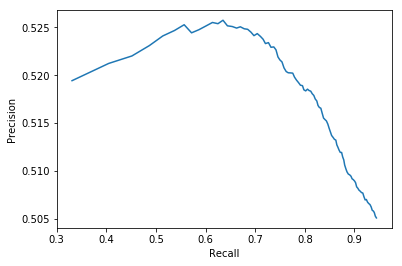

In [19]:
eval_membership_inference(vgg11, train_loader, out_loader)

### ML Leaks 3 vs Distilled VGG11

threshold = 0.5000, accuracy = 51.67, precision = 0.51, recall = 0.93
threshold = 0.5050, accuracy = 51.69, precision = 0.51, recall = 0.93
threshold = 0.5100, accuracy = 51.71, precision = 0.51, recall = 0.93
threshold = 0.5150, accuracy = 51.78, precision = 0.51, recall = 0.92
threshold = 0.5200, accuracy = 51.79, precision = 0.51, recall = 0.92
threshold = 0.5250, accuracy = 51.86, precision = 0.51, recall = 0.92
threshold = 0.5300, accuracy = 51.86, precision = 0.51, recall = 0.92
threshold = 0.5350, accuracy = 51.88, precision = 0.51, recall = 0.91
threshold = 0.5400, accuracy = 51.91, precision = 0.51, recall = 0.91
threshold = 0.5450, accuracy = 51.95, precision = 0.51, recall = 0.91
threshold = 0.5500, accuracy = 52.00, precision = 0.51, recall = 0.91
threshold = 0.5550, accuracy = 52.04, precision = 0.51, recall = 0.90
threshold = 0.5600, accuracy = 52.06, precision = 0.51, recall = 0.90
threshold = 0.5650, accuracy = 52.13, precision = 0.51, recall = 0.90
threshold = 0.5700, 

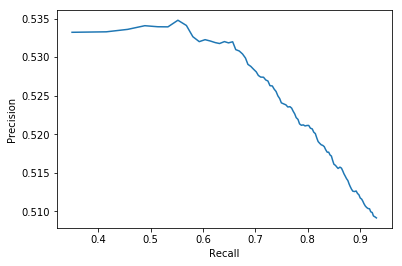

In [32]:
eval_membership_inference(distilled_vgg11, train_loader, out_loader)

## Distill with temperature
First we define the model wrapper

In [33]:
class model_wrapper:
    def __init__(self, model_body):
        self.model = copy.deepcopy(model_body).to(device)
        self.T = 1.
        
    def set_temperature(self, T):
        self.T = T

    def __call__(self, image_tensor):
        image_tensor = image_tensor.to(device)   
        return self.model(image_tensor)/self.T
    
    def eval(self):
        self.model.eval()
        
    def train(self):
        self.model.train()

In [39]:
vgg11 = torchvision.models.vgg11(pretrained = True)
print(vgg11)
vgg11.classifier = nn.Sequential(
        nn.Linear(512, 64),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(64, 64),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(64, 10),
    )
vgg_at_T = model_wrapper(vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [44]:
vgg_at_T.set_temperature(20)
vgg_at_T.model.to(device)
for param in vgg_at_T.model.features.parameters():
    param.requires_grad = False
optimizer = optim.SGD(vgg_at_T.model.classifier.parameters(), lr = 0.0005, momentum=0.9)


In [45]:
criterion = nn.CrossEntropyLoss()
train(vgg_at_T, train_loader, test_loader, optimizer, criterion, 20, verbose=True)

[0/20][0/391] loss = 1.348377
[0/20][1/391] loss = 1.207537
[0/20][2/391] loss = 1.248266
[0/20][3/391] loss = 1.122411
[0/20][4/391] loss = 1.374351
[0/20][5/391] loss = 1.378330
[0/20][6/391] loss = 1.303180
[0/20][7/391] loss = 1.066578
[0/20][8/391] loss = 1.257962
[0/20][9/391] loss = 1.538701
[0/20][10/391] loss = 1.265937
[0/20][11/391] loss = 1.490230
[0/20][12/391] loss = 1.440315
[0/20][13/391] loss = 1.445357
[0/20][14/391] loss = 1.315940
[0/20][15/391] loss = 1.336501
[0/20][16/391] loss = 1.378150
[0/20][17/391] loss = 1.222145
[0/20][18/391] loss = 1.301243
[0/20][19/391] loss = 1.166900
[0/20][20/391] loss = 1.229731
[0/20][21/391] loss = 1.221081
[0/20][22/391] loss = 1.334619
[0/20][23/391] loss = 1.302737
[0/20][24/391] loss = 1.206392
[0/20][25/391] loss = 1.264035
[0/20][26/391] loss = 1.519450
[0/20][27/391] loss = 1.187258
[0/20][28/391] loss = 1.395706
[0/20][29/391] loss = 1.452291
[0/20][30/391] loss = 1.295666
[0/20][31/391] loss = 1.223337
[0/20][32/391] los

[0/20][283/391] loss = 1.235224
[0/20][284/391] loss = 1.212604
[0/20][285/391] loss = 1.435477
[0/20][286/391] loss = 1.223061
[0/20][287/391] loss = 1.322166
[0/20][288/391] loss = 1.589956
[0/20][289/391] loss = 1.364319
[0/20][290/391] loss = 1.466625
[0/20][291/391] loss = 1.364420
[0/20][292/391] loss = 1.360908
[0/20][293/391] loss = 1.388285
[0/20][294/391] loss = 1.304518
[0/20][295/391] loss = 1.417638
[0/20][296/391] loss = 1.283295
[0/20][297/391] loss = 1.340373
[0/20][298/391] loss = 1.372047
[0/20][299/391] loss = 1.360571
[0/20][300/391] loss = 1.391387
[0/20][301/391] loss = 1.455886
[0/20][302/391] loss = 1.352311
[0/20][303/391] loss = 1.356899
[0/20][304/391] loss = 1.209168
[0/20][305/391] loss = 1.321743
[0/20][306/391] loss = 1.271497
[0/20][307/391] loss = 1.347702
[0/20][308/391] loss = 1.398812
[0/20][309/391] loss = 1.196451
[0/20][310/391] loss = 1.261559
[0/20][311/391] loss = 1.307787
[0/20][312/391] loss = 1.202959
[0/20][313/391] loss = 1.272272
[0/20][3

[1/20][150/391] loss = 1.583246
[1/20][151/391] loss = 1.393138
[1/20][152/391] loss = 1.493360
[1/20][153/391] loss = 1.312713
[1/20][154/391] loss = 1.644031
[1/20][155/391] loss = 1.189644
[1/20][156/391] loss = 1.532553
[1/20][157/391] loss = 1.325929
[1/20][158/391] loss = 1.226364
[1/20][159/391] loss = 1.395317
[1/20][160/391] loss = 1.282478
[1/20][161/391] loss = 1.388362
[1/20][162/391] loss = 1.316242
[1/20][163/391] loss = 1.318168
[1/20][164/391] loss = 1.443298
[1/20][165/391] loss = 1.357584
[1/20][166/391] loss = 1.551783
[1/20][167/391] loss = 1.181164
[1/20][168/391] loss = 1.339918
[1/20][169/391] loss = 1.431757
[1/20][170/391] loss = 1.395155
[1/20][171/391] loss = 1.305860
[1/20][172/391] loss = 1.212174
[1/20][173/391] loss = 1.265434
[1/20][174/391] loss = 1.422713
[1/20][175/391] loss = 1.157920
[1/20][176/391] loss = 1.320495
[1/20][177/391] loss = 1.392825
[1/20][178/391] loss = 1.390342
[1/20][179/391] loss = 1.363430
[1/20][180/391] loss = 1.238081
[1/20][1

[2/20][20/391] loss = 1.285968
[2/20][21/391] loss = 1.587039
[2/20][22/391] loss = 1.339867
[2/20][23/391] loss = 1.404547
[2/20][24/391] loss = 1.419998
[2/20][25/391] loss = 1.401488
[2/20][26/391] loss = 1.298816
[2/20][27/391] loss = 1.346917
[2/20][28/391] loss = 1.099859
[2/20][29/391] loss = 1.184328
[2/20][30/391] loss = 1.441520
[2/20][31/391] loss = 1.294339
[2/20][32/391] loss = 1.130042
[2/20][33/391] loss = 1.348603
[2/20][34/391] loss = 1.350067
[2/20][35/391] loss = 1.279247
[2/20][36/391] loss = 1.308660
[2/20][37/391] loss = 1.400778
[2/20][38/391] loss = 1.197200
[2/20][39/391] loss = 1.207041
[2/20][40/391] loss = 1.222567
[2/20][41/391] loss = 1.138367
[2/20][42/391] loss = 1.394339
[2/20][43/391] loss = 1.316376
[2/20][44/391] loss = 1.188639
[2/20][45/391] loss = 1.258469
[2/20][46/391] loss = 1.207057
[2/20][47/391] loss = 1.233863
[2/20][48/391] loss = 1.376699
[2/20][49/391] loss = 1.230031
[2/20][50/391] loss = 1.195775
[2/20][51/391] loss = 1.369503
[2/20][5

[2/20][279/391] loss = 1.418785
[2/20][280/391] loss = 1.421866
[2/20][281/391] loss = 1.313962
[2/20][282/391] loss = 1.259438
[2/20][283/391] loss = 1.548425
[2/20][284/391] loss = 1.724838
[2/20][285/391] loss = 1.329678
[2/20][286/391] loss = 1.426402
[2/20][287/391] loss = 1.379841
[2/20][288/391] loss = 1.075147
[2/20][289/391] loss = 1.405627
[2/20][290/391] loss = 1.275228
[2/20][291/391] loss = 1.158026
[2/20][292/391] loss = 1.295524
[2/20][293/391] loss = 1.383530
[2/20][294/391] loss = 1.308789
[2/20][295/391] loss = 1.320115
[2/20][296/391] loss = 1.145774
[2/20][297/391] loss = 1.350418
[2/20][298/391] loss = 1.276690
[2/20][299/391] loss = 1.396998
[2/20][300/391] loss = 1.354728
[2/20][301/391] loss = 1.287012
[2/20][302/391] loss = 1.177137
[2/20][303/391] loss = 1.286710
[2/20][304/391] loss = 1.205794
[2/20][305/391] loss = 1.414221
[2/20][306/391] loss = 1.293068
[2/20][307/391] loss = 1.169034
[2/20][308/391] loss = 1.308818
[2/20][309/391] loss = 1.435424
[2/20][3

[3/20][164/391] loss = 1.389216
[3/20][165/391] loss = 1.246500
[3/20][166/391] loss = 1.207704
[3/20][167/391] loss = 1.384946
[3/20][168/391] loss = 1.281324
[3/20][169/391] loss = 1.316350
[3/20][170/391] loss = 1.215123
[3/20][171/391] loss = 1.393040
[3/20][172/391] loss = 1.325225
[3/20][173/391] loss = 1.337339
[3/20][174/391] loss = 1.402298
[3/20][175/391] loss = 1.306324
[3/20][176/391] loss = 1.422874
[3/20][177/391] loss = 1.322583
[3/20][178/391] loss = 1.154554
[3/20][179/391] loss = 1.358292
[3/20][180/391] loss = 1.344586
[3/20][181/391] loss = 1.309276
[3/20][182/391] loss = 1.100118
[3/20][183/391] loss = 1.060362
[3/20][184/391] loss = 1.504675
[3/20][185/391] loss = 1.437391
[3/20][186/391] loss = 1.365953
[3/20][187/391] loss = 1.422284
[3/20][188/391] loss = 1.103369
[3/20][189/391] loss = 1.560838
[3/20][190/391] loss = 1.315365
[3/20][191/391] loss = 1.261129
[3/20][192/391] loss = 1.348154
[3/20][193/391] loss = 1.350915
[3/20][194/391] loss = 1.268524
[3/20][1

[4/20][48/391] loss = 1.444903
[4/20][49/391] loss = 1.182772
[4/20][50/391] loss = 1.278323
[4/20][51/391] loss = 1.423584
[4/20][52/391] loss = 1.302469
[4/20][53/391] loss = 1.209967
[4/20][54/391] loss = 1.131163
[4/20][55/391] loss = 1.159257
[4/20][56/391] loss = 1.211493
[4/20][57/391] loss = 1.310038
[4/20][58/391] loss = 1.297415
[4/20][59/391] loss = 1.122662
[4/20][60/391] loss = 1.248433
[4/20][61/391] loss = 1.205943
[4/20][62/391] loss = 1.171820
[4/20][63/391] loss = 1.222073
[4/20][64/391] loss = 1.031574
[4/20][65/391] loss = 1.202273
[4/20][66/391] loss = 1.444468
[4/20][67/391] loss = 1.236229
[4/20][68/391] loss = 1.215962
[4/20][69/391] loss = 1.322388
[4/20][70/391] loss = 1.513828
[4/20][71/391] loss = 1.301735
[4/20][72/391] loss = 1.520409
[4/20][73/391] loss = 1.213685
[4/20][74/391] loss = 1.181289
[4/20][75/391] loss = 1.407579
[4/20][76/391] loss = 1.355378
[4/20][77/391] loss = 1.347172
[4/20][78/391] loss = 1.109104
[4/20][79/391] loss = 1.266789
[4/20][8

[4/20][312/391] loss = 1.245095
[4/20][313/391] loss = 1.046794
[4/20][314/391] loss = 1.303120
[4/20][315/391] loss = 1.395200
[4/20][316/391] loss = 1.270861
[4/20][317/391] loss = 1.341702
[4/20][318/391] loss = 1.097388
[4/20][319/391] loss = 1.370452
[4/20][320/391] loss = 1.352481
[4/20][321/391] loss = 1.333192
[4/20][322/391] loss = 1.471882
[4/20][323/391] loss = 1.255878
[4/20][324/391] loss = 1.257145
[4/20][325/391] loss = 1.282498
[4/20][326/391] loss = 1.276381
[4/20][327/391] loss = 1.214333
[4/20][328/391] loss = 1.317447
[4/20][329/391] loss = 1.273241
[4/20][330/391] loss = 1.329498
[4/20][331/391] loss = 1.212818
[4/20][332/391] loss = 1.191415
[4/20][333/391] loss = 1.329632
[4/20][334/391] loss = 1.216582
[4/20][335/391] loss = 1.113837
[4/20][336/391] loss = 1.249914
[4/20][337/391] loss = 1.486940
[4/20][338/391] loss = 1.314180
[4/20][339/391] loss = 1.130651
[4/20][340/391] loss = 1.292922
[4/20][341/391] loss = 1.468390
[4/20][342/391] loss = 1.261370
[4/20][3

[5/20][195/391] loss = 1.258402
[5/20][196/391] loss = 1.231501
[5/20][197/391] loss = 1.189984
[5/20][198/391] loss = 1.101453
[5/20][199/391] loss = 1.211289
[5/20][200/391] loss = 1.205261
[5/20][201/391] loss = 1.290743
[5/20][202/391] loss = 1.182584
[5/20][203/391] loss = 1.234880
[5/20][204/391] loss = 1.433209
[5/20][205/391] loss = 1.356417
[5/20][206/391] loss = 1.375546
[5/20][207/391] loss = 1.385134
[5/20][208/391] loss = 1.411688
[5/20][209/391] loss = 1.222240
[5/20][210/391] loss = 1.247575
[5/20][211/391] loss = 1.244940
[5/20][212/391] loss = 1.301116
[5/20][213/391] loss = 1.209914
[5/20][214/391] loss = 1.431460
[5/20][215/391] loss = 1.279650
[5/20][216/391] loss = 1.362842
[5/20][217/391] loss = 1.410162
[5/20][218/391] loss = 1.414038
[5/20][219/391] loss = 1.322189
[5/20][220/391] loss = 1.461347
[5/20][221/391] loss = 1.489584
[5/20][222/391] loss = 1.409393
[5/20][223/391] loss = 1.309954
[5/20][224/391] loss = 1.248528
[5/20][225/391] loss = 1.397811
[5/20][2

[6/20][69/391] loss = 1.260482
[6/20][70/391] loss = 1.289745
[6/20][71/391] loss = 1.298739
[6/20][72/391] loss = 1.428124
[6/20][73/391] loss = 1.209144
[6/20][74/391] loss = 1.312482
[6/20][75/391] loss = 1.352698
[6/20][76/391] loss = 1.180582
[6/20][77/391] loss = 1.150330
[6/20][78/391] loss = 1.517562
[6/20][79/391] loss = 1.184318
[6/20][80/391] loss = 1.104821
[6/20][81/391] loss = 1.481997
[6/20][82/391] loss = 1.120169
[6/20][83/391] loss = 1.411439
[6/20][84/391] loss = 1.393102
[6/20][85/391] loss = 1.305606
[6/20][86/391] loss = 1.196985
[6/20][87/391] loss = 1.287787
[6/20][88/391] loss = 1.200489
[6/20][89/391] loss = 1.596894
[6/20][90/391] loss = 1.430536
[6/20][91/391] loss = 1.139908
[6/20][92/391] loss = 1.193541
[6/20][93/391] loss = 1.302050
[6/20][94/391] loss = 1.293507
[6/20][95/391] loss = 1.412913
[6/20][96/391] loss = 1.092504
[6/20][97/391] loss = 1.255815
[6/20][98/391] loss = 1.099242
[6/20][99/391] loss = 1.348921
[6/20][100/391] loss = 1.320686
[6/20][

[6/20][334/391] loss = 1.517731
[6/20][335/391] loss = 1.287947
[6/20][336/391] loss = 1.286234
[6/20][337/391] loss = 1.478306
[6/20][338/391] loss = 1.394471
[6/20][339/391] loss = 1.049564
[6/20][340/391] loss = 1.499462
[6/20][341/391] loss = 1.392798
[6/20][342/391] loss = 1.527403
[6/20][343/391] loss = 1.042908
[6/20][344/391] loss = 1.377525
[6/20][345/391] loss = 1.339708
[6/20][346/391] loss = 1.267112
[6/20][347/391] loss = 1.349162
[6/20][348/391] loss = 1.291492
[6/20][349/391] loss = 1.439376
[6/20][350/391] loss = 1.378407
[6/20][351/391] loss = 1.416796
[6/20][352/391] loss = 1.313327
[6/20][353/391] loss = 1.581573
[6/20][354/391] loss = 1.164465
[6/20][355/391] loss = 1.265928
[6/20][356/391] loss = 1.225941
[6/20][357/391] loss = 1.280240
[6/20][358/391] loss = 1.188878
[6/20][359/391] loss = 1.460313
[6/20][360/391] loss = 1.293755
[6/20][361/391] loss = 1.319352
[6/20][362/391] loss = 1.280414
[6/20][363/391] loss = 1.375835
[6/20][364/391] loss = 1.298992
[6/20][3

[7/20][220/391] loss = 1.165804
[7/20][221/391] loss = 1.304232
[7/20][222/391] loss = 1.107531
[7/20][223/391] loss = 1.316621
[7/20][224/391] loss = 1.257615
[7/20][225/391] loss = 1.448342
[7/20][226/391] loss = 1.406502
[7/20][227/391] loss = 1.220530
[7/20][228/391] loss = 1.340771
[7/20][229/391] loss = 1.352617
[7/20][230/391] loss = 1.312894
[7/20][231/391] loss = 1.366246
[7/20][232/391] loss = 1.279364
[7/20][233/391] loss = 1.239484
[7/20][234/391] loss = 1.366647
[7/20][235/391] loss = 1.359263
[7/20][236/391] loss = 1.212243
[7/20][237/391] loss = 1.257752
[7/20][238/391] loss = 1.385929
[7/20][239/391] loss = 1.263556
[7/20][240/391] loss = 1.454187
[7/20][241/391] loss = 1.214123
[7/20][242/391] loss = 1.342175
[7/20][243/391] loss = 1.346118
[7/20][244/391] loss = 1.278641
[7/20][245/391] loss = 1.358667
[7/20][246/391] loss = 1.417829
[7/20][247/391] loss = 1.590274
[7/20][248/391] loss = 1.117712
[7/20][249/391] loss = 1.265213
[7/20][250/391] loss = 1.544761
[7/20][2

[8/20][99/391] loss = 1.345329
[8/20][100/391] loss = 1.241801
[8/20][101/391] loss = 1.329847
[8/20][102/391] loss = 1.223819
[8/20][103/391] loss = 1.437202
[8/20][104/391] loss = 1.313109
[8/20][105/391] loss = 1.198736
[8/20][106/391] loss = 1.212512
[8/20][107/391] loss = 1.277119
[8/20][108/391] loss = 1.066140
[8/20][109/391] loss = 1.458125
[8/20][110/391] loss = 1.322843
[8/20][111/391] loss = 1.316951
[8/20][112/391] loss = 1.333345
[8/20][113/391] loss = 1.457390
[8/20][114/391] loss = 1.260476
[8/20][115/391] loss = 1.303082
[8/20][116/391] loss = 1.315673
[8/20][117/391] loss = 1.343243
[8/20][118/391] loss = 1.447702
[8/20][119/391] loss = 1.240392
[8/20][120/391] loss = 1.363688
[8/20][121/391] loss = 1.108791
[8/20][122/391] loss = 1.334684
[8/20][123/391] loss = 1.216925
[8/20][124/391] loss = 1.567297
[8/20][125/391] loss = 1.286216
[8/20][126/391] loss = 1.604258
[8/20][127/391] loss = 1.158624
[8/20][128/391] loss = 1.461858
[8/20][129/391] loss = 1.475082
[8/20][13

[8/20][373/391] loss = 1.361112
[8/20][374/391] loss = 1.316937
[8/20][375/391] loss = 1.200617
[8/20][376/391] loss = 1.316716
[8/20][377/391] loss = 1.317799
[8/20][378/391] loss = 1.346803
[8/20][379/391] loss = 1.548039
[8/20][380/391] loss = 1.042638
[8/20][381/391] loss = 1.363297
[8/20][382/391] loss = 1.108959
[8/20][383/391] loss = 1.122873
[8/20][384/391] loss = 1.329199
[8/20][385/391] loss = 1.389748
[8/20][386/391] loss = 0.976894
[8/20][387/391] loss = 1.189076
[8/20][388/391] loss = 1.454956
[8/20][389/391] loss = 1.283866
[8/20][390/391] loss = 1.320232
[8/20]
Training:

Accuracy = 59.88 %


Test:

Accuracy = 59.24 %


[9/20][0/391] loss = 1.261844
[9/20][1/391] loss = 1.253724
[9/20][2/391] loss = 1.351403
[9/20][3/391] loss = 1.427042
[9/20][4/391] loss = 1.314634
[9/20][5/391] loss = 1.306990
[9/20][6/391] loss = 1.281257
[9/20][7/391] loss = 1.325580
[9/20][8/391] loss = 1.328816
[9/20][9/391] loss = 1.382764
[9/20][10/391] loss = 1.234853
[9/20][11/391] loss = 1.53

[9/20][245/391] loss = 1.411883
[9/20][246/391] loss = 1.147555
[9/20][247/391] loss = 1.358043
[9/20][248/391] loss = 0.985356
[9/20][249/391] loss = 1.507427
[9/20][250/391] loss = 1.381727
[9/20][251/391] loss = 0.989844
[9/20][252/391] loss = 1.593880
[9/20][253/391] loss = 1.399114
[9/20][254/391] loss = 1.467079
[9/20][255/391] loss = 1.171350
[9/20][256/391] loss = 1.329002
[9/20][257/391] loss = 1.340534
[9/20][258/391] loss = 1.282041
[9/20][259/391] loss = 1.360720
[9/20][260/391] loss = 1.421309
[9/20][261/391] loss = 1.343969
[9/20][262/391] loss = 1.191757
[9/20][263/391] loss = 1.287376
[9/20][264/391] loss = 1.268473
[9/20][265/391] loss = 1.453242
[9/20][266/391] loss = 1.287710
[9/20][267/391] loss = 1.192426
[9/20][268/391] loss = 1.476724
[9/20][269/391] loss = 1.311151
[9/20][270/391] loss = 1.316471
[9/20][271/391] loss = 1.320444
[9/20][272/391] loss = 1.174878
[9/20][273/391] loss = 1.268765
[9/20][274/391] loss = 1.322574
[9/20][275/391] loss = 1.322370
[9/20][2

[10/20][121/391] loss = 1.344457
[10/20][122/391] loss = 1.388036
[10/20][123/391] loss = 1.125901
[10/20][124/391] loss = 1.175204
[10/20][125/391] loss = 1.318540
[10/20][126/391] loss = 1.319803
[10/20][127/391] loss = 1.100383
[10/20][128/391] loss = 1.388294
[10/20][129/391] loss = 1.339617
[10/20][130/391] loss = 1.408389
[10/20][131/391] loss = 1.291395
[10/20][132/391] loss = 1.335323
[10/20][133/391] loss = 1.159441
[10/20][134/391] loss = 1.277686
[10/20][135/391] loss = 1.237646
[10/20][136/391] loss = 1.282804
[10/20][137/391] loss = 1.240495
[10/20][138/391] loss = 1.093108
[10/20][139/391] loss = 1.215043
[10/20][140/391] loss = 1.267214
[10/20][141/391] loss = 1.489715
[10/20][142/391] loss = 1.424346
[10/20][143/391] loss = 1.285277
[10/20][144/391] loss = 1.265973
[10/20][145/391] loss = 1.208539
[10/20][146/391] loss = 1.221400
[10/20][147/391] loss = 1.526580
[10/20][148/391] loss = 1.131148
[10/20][149/391] loss = 1.305185
[10/20][150/391] loss = 1.100862
[10/20][15

[10/20][386/391] loss = 1.426373
[10/20][387/391] loss = 1.158261
[10/20][388/391] loss = 1.331169
[10/20][389/391] loss = 1.327522
[10/20][390/391] loss = 1.520185
[10/20]
Training:

Accuracy = 60.02 %


Test:

Accuracy = 59.58 %


[11/20][0/391] loss = 1.205249
[11/20][1/391] loss = 1.245448
[11/20][2/391] loss = 1.313197
[11/20][3/391] loss = 1.447880
[11/20][4/391] loss = 1.284714
[11/20][5/391] loss = 1.421232
[11/20][6/391] loss = 1.256768
[11/20][7/391] loss = 1.246880
[11/20][8/391] loss = 1.441890
[11/20][9/391] loss = 1.270539
[11/20][10/391] loss = 1.293752
[11/20][11/391] loss = 1.251835
[11/20][12/391] loss = 1.261334
[11/20][13/391] loss = 1.458099
[11/20][14/391] loss = 1.420349
[11/20][15/391] loss = 1.319093
[11/20][16/391] loss = 1.251682
[11/20][17/391] loss = 1.261426
[11/20][18/391] loss = 1.259208
[11/20][19/391] loss = 1.218140
[11/20][20/391] loss = 1.336756
[11/20][21/391] loss = 1.386458
[11/20][22/391] loss = 1.276779
[11/20][23/391] loss = 1.332908
[11/20][2

[11/20][256/391] loss = 1.390012
[11/20][257/391] loss = 1.219597
[11/20][258/391] loss = 1.147423
[11/20][259/391] loss = 1.368545
[11/20][260/391] loss = 1.366909
[11/20][261/391] loss = 1.297944
[11/20][262/391] loss = 1.312563
[11/20][263/391] loss = 1.384215
[11/20][264/391] loss = 1.303404
[11/20][265/391] loss = 1.342409
[11/20][266/391] loss = 1.377574
[11/20][267/391] loss = 1.212048
[11/20][268/391] loss = 1.232960
[11/20][269/391] loss = 1.345755
[11/20][270/391] loss = 1.209663
[11/20][271/391] loss = 1.410217
[11/20][272/391] loss = 1.490086
[11/20][273/391] loss = 1.283679
[11/20][274/391] loss = 1.221815
[11/20][275/391] loss = 1.467693
[11/20][276/391] loss = 1.382168
[11/20][277/391] loss = 1.446230
[11/20][278/391] loss = 1.228024
[11/20][279/391] loss = 1.255938
[11/20][280/391] loss = 1.264349
[11/20][281/391] loss = 1.246430
[11/20][282/391] loss = 1.383614
[11/20][283/391] loss = 1.344916
[11/20][284/391] loss = 1.280786
[11/20][285/391] loss = 1.287287
[11/20][28

[12/20][119/391] loss = 1.633440
[12/20][120/391] loss = 1.327143
[12/20][121/391] loss = 1.326188
[12/20][122/391] loss = 1.526743
[12/20][123/391] loss = 1.581366
[12/20][124/391] loss = 1.176474
[12/20][125/391] loss = 1.145422
[12/20][126/391] loss = 1.263529
[12/20][127/391] loss = 1.363134
[12/20][128/391] loss = 1.252574
[12/20][129/391] loss = 1.361250
[12/20][130/391] loss = 1.223882
[12/20][131/391] loss = 1.505288
[12/20][132/391] loss = 1.043957
[12/20][133/391] loss = 1.410105
[12/20][134/391] loss = 1.467886
[12/20][135/391] loss = 1.192777
[12/20][136/391] loss = 1.334163
[12/20][137/391] loss = 1.272455
[12/20][138/391] loss = 1.144393
[12/20][139/391] loss = 1.313098
[12/20][140/391] loss = 1.233235
[12/20][141/391] loss = 1.306892
[12/20][142/391] loss = 1.528172
[12/20][143/391] loss = 1.383414
[12/20][144/391] loss = 1.288907
[12/20][145/391] loss = 1.566047
[12/20][146/391] loss = 1.175399
[12/20][147/391] loss = 1.162284
[12/20][148/391] loss = 1.029848
[12/20][14

[12/20][383/391] loss = 1.521544
[12/20][384/391] loss = 1.444497
[12/20][385/391] loss = 1.303808
[12/20][386/391] loss = 1.343235
[12/20][387/391] loss = 1.301379
[12/20][388/391] loss = 1.197248
[12/20][389/391] loss = 1.111415
[12/20][390/391] loss = 1.277735
[12/20]
Training:

Accuracy = 60.19 %


Test:

Accuracy = 59.75 %


[13/20][0/391] loss = 1.409574
[13/20][1/391] loss = 1.407079
[13/20][2/391] loss = 1.265720
[13/20][3/391] loss = 1.277827
[13/20][4/391] loss = 1.346344
[13/20][5/391] loss = 1.106337
[13/20][6/391] loss = 1.203801
[13/20][7/391] loss = 1.277987
[13/20][8/391] loss = 1.416597
[13/20][9/391] loss = 1.210216
[13/20][10/391] loss = 1.255311
[13/20][11/391] loss = 1.185301
[13/20][12/391] loss = 1.181234
[13/20][13/391] loss = 1.065078
[13/20][14/391] loss = 1.214728
[13/20][15/391] loss = 1.285813
[13/20][16/391] loss = 1.312590
[13/20][17/391] loss = 1.622283
[13/20][18/391] loss = 1.359350
[13/20][19/391] loss = 1.277048
[13/20][20/391] loss = 1.341536
[13/20

[13/20][265/391] loss = 1.173197
[13/20][266/391] loss = 1.491279
[13/20][267/391] loss = 1.329578
[13/20][268/391] loss = 1.199564
[13/20][269/391] loss = 1.411518
[13/20][270/391] loss = 1.340732
[13/20][271/391] loss = 1.207369
[13/20][272/391] loss = 1.247487
[13/20][273/391] loss = 1.437072
[13/20][274/391] loss = 1.263798
[13/20][275/391] loss = 1.029346
[13/20][276/391] loss = 1.219939
[13/20][277/391] loss = 1.325372
[13/20][278/391] loss = 1.413084
[13/20][279/391] loss = 1.348541
[13/20][280/391] loss = 1.416306
[13/20][281/391] loss = 1.316914
[13/20][282/391] loss = 1.386139
[13/20][283/391] loss = 1.456880
[13/20][284/391] loss = 1.436972
[13/20][285/391] loss = 1.196604
[13/20][286/391] loss = 1.168498
[13/20][287/391] loss = 1.310498
[13/20][288/391] loss = 1.313577
[13/20][289/391] loss = 1.198851
[13/20][290/391] loss = 1.376206
[13/20][291/391] loss = 1.346068
[13/20][292/391] loss = 1.402059
[13/20][293/391] loss = 1.146516
[13/20][294/391] loss = 1.114311
[13/20][29

[14/20][124/391] loss = 1.192201
[14/20][125/391] loss = 1.051353
[14/20][126/391] loss = 1.028991
[14/20][127/391] loss = 1.254956
[14/20][128/391] loss = 1.054880
[14/20][129/391] loss = 1.308700
[14/20][130/391] loss = 1.360880
[14/20][131/391] loss = 1.366785
[14/20][132/391] loss = 1.240207
[14/20][133/391] loss = 1.468095
[14/20][134/391] loss = 1.257767
[14/20][135/391] loss = 1.193396
[14/20][136/391] loss = 1.223836
[14/20][137/391] loss = 1.085523
[14/20][138/391] loss = 1.260036
[14/20][139/391] loss = 1.488369
[14/20][140/391] loss = 1.321488
[14/20][141/391] loss = 1.500127
[14/20][142/391] loss = 1.245096
[14/20][143/391] loss = 1.215116
[14/20][144/391] loss = 1.328669
[14/20][145/391] loss = 1.193849
[14/20][146/391] loss = 1.080539
[14/20][147/391] loss = 1.442659
[14/20][148/391] loss = 1.152934
[14/20][149/391] loss = 1.309374
[14/20][150/391] loss = 1.253329
[14/20][151/391] loss = 1.270746
[14/20][152/391] loss = 1.232771
[14/20][153/391] loss = 1.329324
[14/20][15


Accuracy = 60.44 %


Test:

Accuracy = 59.98 %


[15/20][0/391] loss = 1.142558
[15/20][1/391] loss = 1.088710
[15/20][2/391] loss = 1.312088
[15/20][3/391] loss = 1.318244
[15/20][4/391] loss = 1.494825
[15/20][5/391] loss = 1.603184
[15/20][6/391] loss = 1.409411
[15/20][7/391] loss = 1.374261
[15/20][8/391] loss = 1.102198
[15/20][9/391] loss = 1.320230
[15/20][10/391] loss = 1.484685
[15/20][11/391] loss = 1.516067
[15/20][12/391] loss = 1.412458
[15/20][13/391] loss = 1.030557
[15/20][14/391] loss = 1.170940
[15/20][15/391] loss = 1.082837
[15/20][16/391] loss = 1.260635
[15/20][17/391] loss = 1.281242
[15/20][18/391] loss = 1.233193
[15/20][19/391] loss = 1.288096
[15/20][20/391] loss = 1.363084
[15/20][21/391] loss = 1.546923
[15/20][22/391] loss = 1.213358
[15/20][23/391] loss = 1.213672
[15/20][24/391] loss = 1.313072
[15/20][25/391] loss = 1.171202
[15/20][26/391] loss = 1.377933
[15/20][27/391] loss = 1.238805
[15/20][28/391] loss = 1.391957
[15/20][29/391] loss = 1.298866


[15/20][273/391] loss = 1.347843
[15/20][274/391] loss = 1.258970
[15/20][275/391] loss = 1.070316
[15/20][276/391] loss = 1.154931
[15/20][277/391] loss = 1.184849
[15/20][278/391] loss = 1.249143
[15/20][279/391] loss = 1.186260
[15/20][280/391] loss = 1.096754
[15/20][281/391] loss = 1.088513
[15/20][282/391] loss = 1.255766
[15/20][283/391] loss = 1.136220
[15/20][284/391] loss = 1.208658
[15/20][285/391] loss = 1.292476
[15/20][286/391] loss = 1.402249
[15/20][287/391] loss = 1.196185
[15/20][288/391] loss = 1.205954
[15/20][289/391] loss = 1.562950
[15/20][290/391] loss = 1.367186
[15/20][291/391] loss = 1.260887
[15/20][292/391] loss = 1.276505
[15/20][293/391] loss = 1.088854
[15/20][294/391] loss = 1.345316
[15/20][295/391] loss = 1.251380
[15/20][296/391] loss = 1.327819
[15/20][297/391] loss = 1.211221
[15/20][298/391] loss = 1.223052
[15/20][299/391] loss = 1.206194
[15/20][300/391] loss = 1.156134
[15/20][301/391] loss = 1.160313
[15/20][302/391] loss = 1.497945
[15/20][30

[16/20][148/391] loss = 1.249903
[16/20][149/391] loss = 1.362884
[16/20][150/391] loss = 1.479302
[16/20][151/391] loss = 1.184849
[16/20][152/391] loss = 1.194846
[16/20][153/391] loss = 1.517257
[16/20][154/391] loss = 1.279784
[16/20][155/391] loss = 1.241575
[16/20][156/391] loss = 1.154998
[16/20][157/391] loss = 1.432878
[16/20][158/391] loss = 1.017778
[16/20][159/391] loss = 1.410936
[16/20][160/391] loss = 1.394668
[16/20][161/391] loss = 1.246269
[16/20][162/391] loss = 1.453673
[16/20][163/391] loss = 1.311170
[16/20][164/391] loss = 1.376322
[16/20][165/391] loss = 1.188047
[16/20][166/391] loss = 1.188441
[16/20][167/391] loss = 1.311076
[16/20][168/391] loss = 1.300923
[16/20][169/391] loss = 1.124643
[16/20][170/391] loss = 1.387878
[16/20][171/391] loss = 1.224164
[16/20][172/391] loss = 1.141266
[16/20][173/391] loss = 1.183095
[16/20][174/391] loss = 1.385877
[16/20][175/391] loss = 1.334293
[16/20][176/391] loss = 1.244328
[16/20][177/391] loss = 1.584664
[16/20][17

[17/20][23/391] loss = 1.306759
[17/20][24/391] loss = 1.514350
[17/20][25/391] loss = 1.378970
[17/20][26/391] loss = 1.366962
[17/20][27/391] loss = 1.309362
[17/20][28/391] loss = 1.344083
[17/20][29/391] loss = 1.275581
[17/20][30/391] loss = 1.350086
[17/20][31/391] loss = 1.199278
[17/20][32/391] loss = 1.248086
[17/20][33/391] loss = 1.161483
[17/20][34/391] loss = 1.150576
[17/20][35/391] loss = 1.201215
[17/20][36/391] loss = 1.417254
[17/20][37/391] loss = 1.302636
[17/20][38/391] loss = 1.379714
[17/20][39/391] loss = 1.233749
[17/20][40/391] loss = 1.060901
[17/20][41/391] loss = 1.191283
[17/20][42/391] loss = 1.279093
[17/20][43/391] loss = 1.252671
[17/20][44/391] loss = 1.291077
[17/20][45/391] loss = 1.123300
[17/20][46/391] loss = 1.406999
[17/20][47/391] loss = 1.338988
[17/20][48/391] loss = 1.593752
[17/20][49/391] loss = 1.274000
[17/20][50/391] loss = 1.312313
[17/20][51/391] loss = 1.218963
[17/20][52/391] loss = 1.223271
[17/20][53/391] loss = 1.229648
[17/20][

[17/20][292/391] loss = 1.428123
[17/20][293/391] loss = 1.227739
[17/20][294/391] loss = 1.179026
[17/20][295/391] loss = 1.118123
[17/20][296/391] loss = 1.345834
[17/20][297/391] loss = 1.186231
[17/20][298/391] loss = 1.337040
[17/20][299/391] loss = 1.306871
[17/20][300/391] loss = 1.143410
[17/20][301/391] loss = 1.147481
[17/20][302/391] loss = 1.050604
[17/20][303/391] loss = 1.279618
[17/20][304/391] loss = 1.235118
[17/20][305/391] loss = 1.270681
[17/20][306/391] loss = 1.313051
[17/20][307/391] loss = 1.320389
[17/20][308/391] loss = 1.359223
[17/20][309/391] loss = 1.286379
[17/20][310/391] loss = 1.465833
[17/20][311/391] loss = 1.102892
[17/20][312/391] loss = 1.244161
[17/20][313/391] loss = 1.287903
[17/20][314/391] loss = 1.245552
[17/20][315/391] loss = 1.198558
[17/20][316/391] loss = 1.303007
[17/20][317/391] loss = 1.224585
[17/20][318/391] loss = 1.441561
[17/20][319/391] loss = 1.279470
[17/20][320/391] loss = 1.229356
[17/20][321/391] loss = 1.331804
[17/20][32

[18/20][172/391] loss = 1.060610
[18/20][173/391] loss = 1.141351
[18/20][174/391] loss = 1.174791
[18/20][175/391] loss = 1.368420
[18/20][176/391] loss = 1.135412
[18/20][177/391] loss = 1.355305
[18/20][178/391] loss = 1.372545
[18/20][179/391] loss = 1.404312
[18/20][180/391] loss = 1.330966
[18/20][181/391] loss = 1.399785
[18/20][182/391] loss = 1.177011
[18/20][183/391] loss = 1.238322
[18/20][184/391] loss = 1.128726
[18/20][185/391] loss = 1.139772
[18/20][186/391] loss = 1.340927
[18/20][187/391] loss = 1.435687
[18/20][188/391] loss = 1.290822
[18/20][189/391] loss = 1.414529
[18/20][190/391] loss = 1.222056
[18/20][191/391] loss = 1.507921
[18/20][192/391] loss = 1.291058
[18/20][193/391] loss = 1.419096
[18/20][194/391] loss = 1.216055
[18/20][195/391] loss = 1.137600
[18/20][196/391] loss = 1.270268
[18/20][197/391] loss = 1.303264
[18/20][198/391] loss = 1.254558
[18/20][199/391] loss = 1.372118
[18/20][200/391] loss = 1.367337
[18/20][201/391] loss = 1.132605
[18/20][20

[19/20][49/391] loss = 1.335902
[19/20][50/391] loss = 1.296427
[19/20][51/391] loss = 1.368422
[19/20][52/391] loss = 1.275015
[19/20][53/391] loss = 1.222029
[19/20][54/391] loss = 1.328593
[19/20][55/391] loss = 1.236054
[19/20][56/391] loss = 1.390261
[19/20][57/391] loss = 1.306043
[19/20][58/391] loss = 1.246935
[19/20][59/391] loss = 1.281621
[19/20][60/391] loss = 1.308645
[19/20][61/391] loss = 1.376142
[19/20][62/391] loss = 1.255112
[19/20][63/391] loss = 1.315685
[19/20][64/391] loss = 1.085189
[19/20][65/391] loss = 1.226861
[19/20][66/391] loss = 1.249116
[19/20][67/391] loss = 1.446617
[19/20][68/391] loss = 1.514194
[19/20][69/391] loss = 1.178913
[19/20][70/391] loss = 1.114905
[19/20][71/391] loss = 1.383710
[19/20][72/391] loss = 1.183325
[19/20][73/391] loss = 1.419554
[19/20][74/391] loss = 1.485532
[19/20][75/391] loss = 1.231148
[19/20][76/391] loss = 1.278874
[19/20][77/391] loss = 1.301290
[19/20][78/391] loss = 1.134830
[19/20][79/391] loss = 1.316308
[19/20][

[19/20][319/391] loss = 1.286280
[19/20][320/391] loss = 1.154953
[19/20][321/391] loss = 1.184056
[19/20][322/391] loss = 1.165769
[19/20][323/391] loss = 1.151071
[19/20][324/391] loss = 1.189634
[19/20][325/391] loss = 1.113136
[19/20][326/391] loss = 1.460300
[19/20][327/391] loss = 1.420130
[19/20][328/391] loss = 1.380391
[19/20][329/391] loss = 1.255535
[19/20][330/391] loss = 1.218196
[19/20][331/391] loss = 1.326559
[19/20][332/391] loss = 1.368076
[19/20][333/391] loss = 1.217595
[19/20][334/391] loss = 1.067858
[19/20][335/391] loss = 1.395778
[19/20][336/391] loss = 1.158917
[19/20][337/391] loss = 1.159504
[19/20][338/391] loss = 1.341402
[19/20][339/391] loss = 1.472857
[19/20][340/391] loss = 1.356378
[19/20][341/391] loss = 1.316799
[19/20][342/391] loss = 1.469598
[19/20][343/391] loss = 1.202804
[19/20][344/391] loss = 1.298519
[19/20][345/391] loss = 1.161928
[19/20][346/391] loss = 1.254919
[19/20][347/391] loss = 1.283071
[19/20][348/391] loss = 1.433794
[19/20][34

### Half point Performance
Training distilled_vgg11.classifier only

Set-up:
 - Epochs: 60
 - optimizer: SGD
 - lr: 0.001/0.0005 (40/20 epochs)
 - momentum: 0.9
 
Results:
 - Training/Validation: 61.1%/60.39% 
 
 ### Fine tunning

In [48]:
vgg_at_T.model.to(device)
for param in vgg_at_T.model.parameters():
    param.requires_grad = True
optimizer = optim.SGD(vgg_at_T.model.classifier.parameters(), lr = 0.001, momentum=0.9)

In [51]:
vgg_at_T.set_temperature(20)
criterion = nn.CrossEntropyLoss()
train(vgg_at_T, train_loader, test_loader, optimizer, criterion, 20, verbose=True)

[0/20][0/391] loss = 1.198288
[0/20][1/391] loss = 1.283157
[0/20][2/391] loss = 1.167342
[0/20][3/391] loss = 1.256063
[0/20][4/391] loss = 1.226521
[0/20][5/391] loss = 1.410860
[0/20][6/391] loss = 1.008242
[0/20][7/391] loss = 1.263410
[0/20][8/391] loss = 1.210293
[0/20][9/391] loss = 1.041243
[0/20][10/391] loss = 1.089526
[0/20][11/391] loss = 1.100943
[0/20][12/391] loss = 1.193687
[0/20][13/391] loss = 1.089036
[0/20][14/391] loss = 1.071023
[0/20][15/391] loss = 1.374720
[0/20][16/391] loss = 1.211789
[0/20][17/391] loss = 1.118332
[0/20][18/391] loss = 1.058283
[0/20][19/391] loss = 1.037667
[0/20][20/391] loss = 1.195032
[0/20][21/391] loss = 1.278846
[0/20][22/391] loss = 1.301820
[0/20][23/391] loss = 1.205113
[0/20][24/391] loss = 1.350287
[0/20][25/391] loss = 1.127882
[0/20][26/391] loss = 1.358838
[0/20][27/391] loss = 1.666560
[0/20][28/391] loss = 1.182713
[0/20][29/391] loss = 1.441373
[0/20][30/391] loss = 1.189436
[0/20][31/391] loss = 1.075270
[0/20][32/391] los

[0/20][268/391] loss = 1.223839
[0/20][269/391] loss = 1.263519
[0/20][270/391] loss = 1.022572
[0/20][271/391] loss = 1.276364
[0/20][272/391] loss = 1.144151
[0/20][273/391] loss = 1.152759
[0/20][274/391] loss = 1.142964
[0/20][275/391] loss = 1.125722
[0/20][276/391] loss = 1.307572
[0/20][277/391] loss = 1.220700
[0/20][278/391] loss = 1.068097
[0/20][279/391] loss = 1.384857
[0/20][280/391] loss = 1.178553
[0/20][281/391] loss = 1.377687
[0/20][282/391] loss = 1.179240
[0/20][283/391] loss = 1.094277
[0/20][284/391] loss = 1.202283
[0/20][285/391] loss = 1.113438
[0/20][286/391] loss = 1.130517
[0/20][287/391] loss = 1.208002
[0/20][288/391] loss = 1.242183
[0/20][289/391] loss = 1.170610
[0/20][290/391] loss = 1.107383
[0/20][291/391] loss = 1.473533
[0/20][292/391] loss = 1.110179
[0/20][293/391] loss = 1.104192
[0/20][294/391] loss = 1.168257
[0/20][295/391] loss = 1.192804
[0/20][296/391] loss = 1.106003
[0/20][297/391] loss = 1.174832
[0/20][298/391] loss = 1.322459
[0/20][2

[1/20][140/391] loss = 1.307077
[1/20][141/391] loss = 1.130072
[1/20][142/391] loss = 1.247243
[1/20][143/391] loss = 1.110148
[1/20][144/391] loss = 1.368342
[1/20][145/391] loss = 1.115872
[1/20][146/391] loss = 1.198159
[1/20][147/391] loss = 1.240952
[1/20][148/391] loss = 0.925890
[1/20][149/391] loss = 1.083461
[1/20][150/391] loss = 1.184238
[1/20][151/391] loss = 1.243921
[1/20][152/391] loss = 1.249915
[1/20][153/391] loss = 1.115918
[1/20][154/391] loss = 1.263164
[1/20][155/391] loss = 1.244437
[1/20][156/391] loss = 1.352349
[1/20][157/391] loss = 1.191271
[1/20][158/391] loss = 1.503216
[1/20][159/391] loss = 1.276965
[1/20][160/391] loss = 1.046825
[1/20][161/391] loss = 1.214524
[1/20][162/391] loss = 1.221390
[1/20][163/391] loss = 1.089131
[1/20][164/391] loss = 1.120750
[1/20][165/391] loss = 1.216481
[1/20][166/391] loss = 1.110567
[1/20][167/391] loss = 1.132687
[1/20][168/391] loss = 1.020000
[1/20][169/391] loss = 1.381250
[1/20][170/391] loss = 1.110704
[1/20][1

[2/20][9/391] loss = 1.226663
[2/20][10/391] loss = 1.136437
[2/20][11/391] loss = 1.254889
[2/20][12/391] loss = 1.310786
[2/20][13/391] loss = 1.590327
[2/20][14/391] loss = 1.222148
[2/20][15/391] loss = 1.063687
[2/20][16/391] loss = 1.180140
[2/20][17/391] loss = 1.036055
[2/20][18/391] loss = 1.145866
[2/20][19/391] loss = 1.232666
[2/20][20/391] loss = 0.960309
[2/20][21/391] loss = 1.258119
[2/20][22/391] loss = 1.159766
[2/20][23/391] loss = 1.187842
[2/20][24/391] loss = 0.993464
[2/20][25/391] loss = 1.050272
[2/20][26/391] loss = 1.317850
[2/20][27/391] loss = 1.375916
[2/20][28/391] loss = 1.053016
[2/20][29/391] loss = 1.076548
[2/20][30/391] loss = 1.297819
[2/20][31/391] loss = 1.012384
[2/20][32/391] loss = 1.212183
[2/20][33/391] loss = 1.203632
[2/20][34/391] loss = 1.465665
[2/20][35/391] loss = 1.394856
[2/20][36/391] loss = 1.183694
[2/20][37/391] loss = 1.095280
[2/20][38/391] loss = 1.509081
[2/20][39/391] loss = 1.074495
[2/20][40/391] loss = 1.278941
[2/20][41

[2/20][269/391] loss = 1.294970
[2/20][270/391] loss = 1.169081
[2/20][271/391] loss = 1.310218
[2/20][272/391] loss = 1.295735
[2/20][273/391] loss = 1.150232
[2/20][274/391] loss = 1.143233
[2/20][275/391] loss = 1.148824
[2/20][276/391] loss = 1.201437
[2/20][277/391] loss = 1.126755
[2/20][278/391] loss = 1.189410
[2/20][279/391] loss = 1.122075
[2/20][280/391] loss = 1.180869
[2/20][281/391] loss = 1.072142
[2/20][282/391] loss = 1.136770
[2/20][283/391] loss = 1.363781
[2/20][284/391] loss = 1.332089
[2/20][285/391] loss = 1.234040
[2/20][286/391] loss = 1.212710
[2/20][287/391] loss = 1.100430
[2/20][288/391] loss = 1.125285
[2/20][289/391] loss = 1.210972
[2/20][290/391] loss = 1.266702
[2/20][291/391] loss = 1.247765
[2/20][292/391] loss = 1.152845
[2/20][293/391] loss = 1.194587
[2/20][294/391] loss = 0.950393
[2/20][295/391] loss = 1.258238
[2/20][296/391] loss = 1.108375
[2/20][297/391] loss = 1.078718
[2/20][298/391] loss = 1.232003
[2/20][299/391] loss = 1.168551
[2/20][3

[3/20][140/391] loss = 1.261667
[3/20][141/391] loss = 1.254974
[3/20][142/391] loss = 1.295275
[3/20][143/391] loss = 1.318459
[3/20][144/391] loss = 1.092361
[3/20][145/391] loss = 1.101761
[3/20][146/391] loss = 1.172730
[3/20][147/391] loss = 1.203289
[3/20][148/391] loss = 1.182674
[3/20][149/391] loss = 1.160468
[3/20][150/391] loss = 1.370883
[3/20][151/391] loss = 1.324553
[3/20][152/391] loss = 1.076914
[3/20][153/391] loss = 1.121243
[3/20][154/391] loss = 1.251426
[3/20][155/391] loss = 1.113283
[3/20][156/391] loss = 1.132134
[3/20][157/391] loss = 1.323589
[3/20][158/391] loss = 1.218357
[3/20][159/391] loss = 1.321498
[3/20][160/391] loss = 1.143861
[3/20][161/391] loss = 1.222582
[3/20][162/391] loss = 1.331868
[3/20][163/391] loss = 1.198147
[3/20][164/391] loss = 1.162629
[3/20][165/391] loss = 1.097026
[3/20][166/391] loss = 1.276820
[3/20][167/391] loss = 1.294809
[3/20][168/391] loss = 1.174605
[3/20][169/391] loss = 1.391596
[3/20][170/391] loss = 1.277833
[3/20][1

[4/20][9/391] loss = 0.954076
[4/20][10/391] loss = 1.223516
[4/20][11/391] loss = 1.226387
[4/20][12/391] loss = 1.208109
[4/20][13/391] loss = 1.339273
[4/20][14/391] loss = 1.107269
[4/20][15/391] loss = 1.368868
[4/20][16/391] loss = 1.013307
[4/20][17/391] loss = 1.184224
[4/20][18/391] loss = 1.154730
[4/20][19/391] loss = 1.304347
[4/20][20/391] loss = 1.007548
[4/20][21/391] loss = 1.169207
[4/20][22/391] loss = 1.200204
[4/20][23/391] loss = 1.198675
[4/20][24/391] loss = 0.933040
[4/20][25/391] loss = 1.070908
[4/20][26/391] loss = 1.122134
[4/20][27/391] loss = 1.272186
[4/20][28/391] loss = 1.109218
[4/20][29/391] loss = 1.108678
[4/20][30/391] loss = 1.112123
[4/20][31/391] loss = 1.509640
[4/20][32/391] loss = 1.220478
[4/20][33/391] loss = 1.169995
[4/20][34/391] loss = 1.356897
[4/20][35/391] loss = 1.012901
[4/20][36/391] loss = 1.006192
[4/20][37/391] loss = 0.952173
[4/20][38/391] loss = 1.105980
[4/20][39/391] loss = 0.994313
[4/20][40/391] loss = 1.286885
[4/20][41

[4/20][277/391] loss = 1.089952
[4/20][278/391] loss = 1.342604
[4/20][279/391] loss = 1.048443
[4/20][280/391] loss = 1.199906
[4/20][281/391] loss = 1.118866
[4/20][282/391] loss = 1.270797
[4/20][283/391] loss = 1.084009
[4/20][284/391] loss = 1.217619
[4/20][285/391] loss = 1.197245
[4/20][286/391] loss = 1.201858
[4/20][287/391] loss = 1.346241
[4/20][288/391] loss = 1.250116
[4/20][289/391] loss = 1.226408
[4/20][290/391] loss = 1.265465
[4/20][291/391] loss = 1.230582
[4/20][292/391] loss = 1.024555
[4/20][293/391] loss = 1.242366
[4/20][294/391] loss = 0.859353
[4/20][295/391] loss = 1.215907
[4/20][296/391] loss = 1.102339
[4/20][297/391] loss = 1.254008
[4/20][298/391] loss = 1.243219
[4/20][299/391] loss = 0.967968
[4/20][300/391] loss = 1.210414
[4/20][301/391] loss = 1.213677
[4/20][302/391] loss = 1.021750
[4/20][303/391] loss = 0.955762
[4/20][304/391] loss = 1.138492
[4/20][305/391] loss = 1.194381
[4/20][306/391] loss = 1.004642
[4/20][307/391] loss = 1.143611
[4/20][3

[5/20][146/391] loss = 1.251947
[5/20][147/391] loss = 1.548915
[5/20][148/391] loss = 1.289530
[5/20][149/391] loss = 1.172434
[5/20][150/391] loss = 0.987793
[5/20][151/391] loss = 0.848399
[5/20][152/391] loss = 1.144297
[5/20][153/391] loss = 1.108836
[5/20][154/391] loss = 1.073966
[5/20][155/391] loss = 1.403430
[5/20][156/391] loss = 1.339369
[5/20][157/391] loss = 1.155061
[5/20][158/391] loss = 0.992661
[5/20][159/391] loss = 1.256918
[5/20][160/391] loss = 1.117760
[5/20][161/391] loss = 1.263157
[5/20][162/391] loss = 1.168844
[5/20][163/391] loss = 1.263620
[5/20][164/391] loss = 1.140171
[5/20][165/391] loss = 1.115559
[5/20][166/391] loss = 1.172904
[5/20][167/391] loss = 1.293029
[5/20][168/391] loss = 1.114058
[5/20][169/391] loss = 1.055911
[5/20][170/391] loss = 1.089944
[5/20][171/391] loss = 1.081810
[5/20][172/391] loss = 1.147064
[5/20][173/391] loss = 1.043504
[5/20][174/391] loss = 1.288835
[5/20][175/391] loss = 1.133205
[5/20][176/391] loss = 0.970603
[5/20][1

[6/20][10/391] loss = 0.882056
[6/20][11/391] loss = 1.228215
[6/20][12/391] loss = 1.102685
[6/20][13/391] loss = 1.171144
[6/20][14/391] loss = 1.077010
[6/20][15/391] loss = 0.977157
[6/20][16/391] loss = 1.162143
[6/20][17/391] loss = 1.071096
[6/20][18/391] loss = 1.243888
[6/20][19/391] loss = 1.232313
[6/20][20/391] loss = 1.296119
[6/20][21/391] loss = 1.188577
[6/20][22/391] loss = 1.187309
[6/20][23/391] loss = 1.080880
[6/20][24/391] loss = 1.071546
[6/20][25/391] loss = 1.161801
[6/20][26/391] loss = 1.163177
[6/20][27/391] loss = 1.104056
[6/20][28/391] loss = 1.173831
[6/20][29/391] loss = 1.325418
[6/20][30/391] loss = 1.204853
[6/20][31/391] loss = 1.031747
[6/20][32/391] loss = 1.060290
[6/20][33/391] loss = 1.009487
[6/20][34/391] loss = 1.317023
[6/20][35/391] loss = 1.372079
[6/20][36/391] loss = 1.045368
[6/20][37/391] loss = 1.268878
[6/20][38/391] loss = 1.437774
[6/20][39/391] loss = 1.284084
[6/20][40/391] loss = 1.184506
[6/20][41/391] loss = 1.283180
[6/20][4

[6/20][270/391] loss = 0.926495
[6/20][271/391] loss = 1.318758
[6/20][272/391] loss = 1.170520
[6/20][273/391] loss = 1.076246
[6/20][274/391] loss = 1.268078
[6/20][275/391] loss = 1.080490
[6/20][276/391] loss = 1.428045
[6/20][277/391] loss = 1.286425
[6/20][278/391] loss = 1.047721
[6/20][279/391] loss = 1.257448
[6/20][280/391] loss = 1.443853
[6/20][281/391] loss = 1.294870
[6/20][282/391] loss = 0.834327
[6/20][283/391] loss = 1.046467
[6/20][284/391] loss = 1.261017
[6/20][285/391] loss = 1.102974
[6/20][286/391] loss = 1.441485
[6/20][287/391] loss = 1.107968
[6/20][288/391] loss = 1.042784
[6/20][289/391] loss = 1.200374
[6/20][290/391] loss = 0.978543
[6/20][291/391] loss = 1.207383
[6/20][292/391] loss = 1.114079
[6/20][293/391] loss = 0.956845
[6/20][294/391] loss = 1.220111
[6/20][295/391] loss = 1.125845
[6/20][296/391] loss = 0.998893
[6/20][297/391] loss = 1.054501
[6/20][298/391] loss = 1.373902
[6/20][299/391] loss = 1.108089
[6/20][300/391] loss = 1.074824
[6/20][3

[7/20][140/391] loss = 1.157413
[7/20][141/391] loss = 1.058156
[7/20][142/391] loss = 1.133153
[7/20][143/391] loss = 1.004776
[7/20][144/391] loss = 1.315481
[7/20][145/391] loss = 1.148427
[7/20][146/391] loss = 1.153663
[7/20][147/391] loss = 1.210470
[7/20][148/391] loss = 1.276769
[7/20][149/391] loss = 1.274408
[7/20][150/391] loss = 1.450269
[7/20][151/391] loss = 1.222219
[7/20][152/391] loss = 1.326409
[7/20][153/391] loss = 1.179896
[7/20][154/391] loss = 1.139014
[7/20][155/391] loss = 1.257272
[7/20][156/391] loss = 1.144001
[7/20][157/391] loss = 1.120881
[7/20][158/391] loss = 0.995848
[7/20][159/391] loss = 1.126133
[7/20][160/391] loss = 0.942957
[7/20][161/391] loss = 1.223010
[7/20][162/391] loss = 1.608820
[7/20][163/391] loss = 1.096281
[7/20][164/391] loss = 1.188100
[7/20][165/391] loss = 1.140089
[7/20][166/391] loss = 1.127432
[7/20][167/391] loss = 1.065402
[7/20][168/391] loss = 1.407769
[7/20][169/391] loss = 1.167208
[7/20][170/391] loss = 1.119654
[7/20][1

[8/20][9/391] loss = 1.254091
[8/20][10/391] loss = 1.354347
[8/20][11/391] loss = 1.167325
[8/20][12/391] loss = 1.143196
[8/20][13/391] loss = 1.176382
[8/20][14/391] loss = 1.378307
[8/20][15/391] loss = 1.088508
[8/20][16/391] loss = 1.036687
[8/20][17/391] loss = 1.054938
[8/20][18/391] loss = 1.115480
[8/20][19/391] loss = 1.129626
[8/20][20/391] loss = 1.249367
[8/20][21/391] loss = 1.561251
[8/20][22/391] loss = 1.283075
[8/20][23/391] loss = 1.259671
[8/20][24/391] loss = 1.029892
[8/20][25/391] loss = 1.118711
[8/20][26/391] loss = 1.019240
[8/20][27/391] loss = 1.125592
[8/20][28/391] loss = 1.233118
[8/20][29/391] loss = 1.134368
[8/20][30/391] loss = 1.264597
[8/20][31/391] loss = 1.115990
[8/20][32/391] loss = 0.968039
[8/20][33/391] loss = 1.301692
[8/20][34/391] loss = 0.988088
[8/20][35/391] loss = 1.179979
[8/20][36/391] loss = 1.107363
[8/20][37/391] loss = 1.132357
[8/20][38/391] loss = 0.906208
[8/20][39/391] loss = 1.166273
[8/20][40/391] loss = 1.444578
[8/20][41

[8/20][273/391] loss = 1.035139
[8/20][274/391] loss = 1.276272
[8/20][275/391] loss = 1.264498
[8/20][276/391] loss = 1.232725
[8/20][277/391] loss = 1.046113
[8/20][278/391] loss = 1.330840
[8/20][279/391] loss = 1.205203
[8/20][280/391] loss = 1.818992
[8/20][281/391] loss = 1.002267
[8/20][282/391] loss = 1.200829
[8/20][283/391] loss = 1.022327
[8/20][284/391] loss = 1.029918
[8/20][285/391] loss = 1.103813
[8/20][286/391] loss = 1.150894
[8/20][287/391] loss = 1.291792
[8/20][288/391] loss = 1.271764
[8/20][289/391] loss = 1.276075
[8/20][290/391] loss = 1.101654
[8/20][291/391] loss = 0.978623
[8/20][292/391] loss = 1.240092
[8/20][293/391] loss = 1.199198
[8/20][294/391] loss = 1.134035
[8/20][295/391] loss = 1.331645
[8/20][296/391] loss = 1.123496
[8/20][297/391] loss = 1.194603
[8/20][298/391] loss = 1.181427
[8/20][299/391] loss = 1.365156
[8/20][300/391] loss = 1.266548
[8/20][301/391] loss = 1.250843
[8/20][302/391] loss = 1.044243
[8/20][303/391] loss = 1.191869
[8/20][3

[9/20][149/391] loss = 1.130747
[9/20][150/391] loss = 1.113612
[9/20][151/391] loss = 1.208129
[9/20][152/391] loss = 1.217666
[9/20][153/391] loss = 1.162861
[9/20][154/391] loss = 1.124544
[9/20][155/391] loss = 0.963080
[9/20][156/391] loss = 1.294396
[9/20][157/391] loss = 1.164482
[9/20][158/391] loss = 0.914011
[9/20][159/391] loss = 1.006835
[9/20][160/391] loss = 1.506990
[9/20][161/391] loss = 1.065718
[9/20][162/391] loss = 1.107571
[9/20][163/391] loss = 1.075977
[9/20][164/391] loss = 1.365722
[9/20][165/391] loss = 1.148952
[9/20][166/391] loss = 1.095556
[9/20][167/391] loss = 1.166391
[9/20][168/391] loss = 1.130020
[9/20][169/391] loss = 1.166734
[9/20][170/391] loss = 1.309630
[9/20][171/391] loss = 1.210225
[9/20][172/391] loss = 1.089784
[9/20][173/391] loss = 1.401580
[9/20][174/391] loss = 1.063570
[9/20][175/391] loss = 1.163418
[9/20][176/391] loss = 1.049113
[9/20][177/391] loss = 1.076153
[9/20][178/391] loss = 1.186803
[9/20][179/391] loss = 1.466705
[9/20][1

[10/20][19/391] loss = 1.075451
[10/20][20/391] loss = 0.952709
[10/20][21/391] loss = 1.207039
[10/20][22/391] loss = 1.190693
[10/20][23/391] loss = 0.932648
[10/20][24/391] loss = 1.115419
[10/20][25/391] loss = 1.204434
[10/20][26/391] loss = 1.060300
[10/20][27/391] loss = 0.959873
[10/20][28/391] loss = 1.112061
[10/20][29/391] loss = 0.985449
[10/20][30/391] loss = 1.337335
[10/20][31/391] loss = 0.874357
[10/20][32/391] loss = 1.401050
[10/20][33/391] loss = 1.062988
[10/20][34/391] loss = 1.041838
[10/20][35/391] loss = 1.246092
[10/20][36/391] loss = 1.238700
[10/20][37/391] loss = 1.117936
[10/20][38/391] loss = 1.181145
[10/20][39/391] loss = 1.260972
[10/20][40/391] loss = 1.229945
[10/20][41/391] loss = 1.139760
[10/20][42/391] loss = 1.138307
[10/20][43/391] loss = 1.165398
[10/20][44/391] loss = 1.345065
[10/20][45/391] loss = 1.206671
[10/20][46/391] loss = 1.208884
[10/20][47/391] loss = 1.266208
[10/20][48/391] loss = 1.243996
[10/20][49/391] loss = 1.218490
[10/20][

[10/20][278/391] loss = 1.081617
[10/20][279/391] loss = 1.327549
[10/20][280/391] loss = 1.041309
[10/20][281/391] loss = 1.301442
[10/20][282/391] loss = 1.156567
[10/20][283/391] loss = 1.056035
[10/20][284/391] loss = 1.102206
[10/20][285/391] loss = 1.320384
[10/20][286/391] loss = 1.070792
[10/20][287/391] loss = 1.144819
[10/20][288/391] loss = 1.000033
[10/20][289/391] loss = 1.223808
[10/20][290/391] loss = 1.011452
[10/20][291/391] loss = 0.911330
[10/20][292/391] loss = 1.489601
[10/20][293/391] loss = 1.324229
[10/20][294/391] loss = 1.232331
[10/20][295/391] loss = 1.353790
[10/20][296/391] loss = 1.254602
[10/20][297/391] loss = 1.327653
[10/20][298/391] loss = 1.479910
[10/20][299/391] loss = 1.147115
[10/20][300/391] loss = 1.099291
[10/20][301/391] loss = 0.944775
[10/20][302/391] loss = 1.115147
[10/20][303/391] loss = 1.226001
[10/20][304/391] loss = 1.163126
[10/20][305/391] loss = 1.219043
[10/20][306/391] loss = 1.373945
[10/20][307/391] loss = 1.267565
[10/20][30

[11/20][138/391] loss = 1.249199
[11/20][139/391] loss = 1.116032
[11/20][140/391] loss = 1.230325
[11/20][141/391] loss = 1.129626
[11/20][142/391] loss = 1.117760
[11/20][143/391] loss = 1.008193
[11/20][144/391] loss = 1.285181
[11/20][145/391] loss = 1.139367
[11/20][146/391] loss = 1.088986
[11/20][147/391] loss = 1.282112
[11/20][148/391] loss = 1.120934
[11/20][149/391] loss = 1.314472
[11/20][150/391] loss = 1.028045
[11/20][151/391] loss = 1.237557
[11/20][152/391] loss = 1.241095
[11/20][153/391] loss = 1.080128
[11/20][154/391] loss = 1.154856
[11/20][155/391] loss = 0.990402
[11/20][156/391] loss = 1.493372
[11/20][157/391] loss = 1.297226
[11/20][158/391] loss = 1.152927
[11/20][159/391] loss = 1.172411
[11/20][160/391] loss = 1.445125
[11/20][161/391] loss = 0.990990
[11/20][162/391] loss = 1.386253
[11/20][163/391] loss = 1.140428
[11/20][164/391] loss = 1.095933
[11/20][165/391] loss = 1.135235
[11/20][166/391] loss = 1.322618
[11/20][167/391] loss = 1.108361
[11/20][16

[11/20][387/391] loss = 1.411910
[11/20][388/391] loss = 1.081151
[11/20][389/391] loss = 1.021322
[11/20][390/391] loss = 1.091903
[11/20]
Training:

Accuracy = 66.23 %


Test:

Accuracy = 64.77 %


[12/20][0/391] loss = 1.263194
[12/20][1/391] loss = 1.347795
[12/20][2/391] loss = 1.236921
[12/20][3/391] loss = 1.054176
[12/20][4/391] loss = 1.221914
[12/20][5/391] loss = 1.189470
[12/20][6/391] loss = 1.134937
[12/20][7/391] loss = 1.125041
[12/20][8/391] loss = 1.059499
[12/20][9/391] loss = 1.122938
[12/20][10/391] loss = 1.172572
[12/20][11/391] loss = 1.116833
[12/20][12/391] loss = 1.017784
[12/20][13/391] loss = 0.982205
[12/20][14/391] loss = 1.343304
[12/20][15/391] loss = 0.985731
[12/20][16/391] loss = 1.186141
[12/20][17/391] loss = 1.386384
[12/20][18/391] loss = 0.993672
[12/20][19/391] loss = 1.110329
[12/20][20/391] loss = 1.189646
[12/20][21/391] loss = 1.232120
[12/20][22/391] loss = 1.259762
[12/20][23/391] loss = 1.265837
[12/20][24/391] loss = 0.932121
[12/20][25

[12/20][246/391] loss = 1.132929
[12/20][247/391] loss = 1.078880
[12/20][248/391] loss = 1.457095
[12/20][249/391] loss = 1.212676
[12/20][250/391] loss = 1.192120
[12/20][251/391] loss = 1.081407
[12/20][252/391] loss = 1.062687
[12/20][253/391] loss = 0.849302
[12/20][254/391] loss = 1.306443
[12/20][255/391] loss = 1.255197
[12/20][256/391] loss = 1.238172
[12/20][257/391] loss = 1.407336
[12/20][258/391] loss = 1.238523
[12/20][259/391] loss = 1.186972
[12/20][260/391] loss = 1.210121
[12/20][261/391] loss = 1.141974
[12/20][262/391] loss = 0.974450
[12/20][263/391] loss = 1.368356
[12/20][264/391] loss = 1.195541
[12/20][265/391] loss = 1.130879
[12/20][266/391] loss = 1.242424
[12/20][267/391] loss = 1.279710
[12/20][268/391] loss = 1.129502
[12/20][269/391] loss = 1.118068
[12/20][270/391] loss = 1.252578
[12/20][271/391] loss = 1.283693
[12/20][272/391] loss = 1.298980
[12/20][273/391] loss = 1.308451
[12/20][274/391] loss = 1.111243
[12/20][275/391] loss = 1.078665
[12/20][27

[13/20][109/391] loss = 1.111342
[13/20][110/391] loss = 1.314963
[13/20][111/391] loss = 0.973318
[13/20][112/391] loss = 1.534393
[13/20][113/391] loss = 1.121604
[13/20][114/391] loss = 1.284833
[13/20][115/391] loss = 1.248875
[13/20][116/391] loss = 0.952902
[13/20][117/391] loss = 1.000616
[13/20][118/391] loss = 1.425447
[13/20][119/391] loss = 1.153067
[13/20][120/391] loss = 1.173917
[13/20][121/391] loss = 1.193993
[13/20][122/391] loss = 1.133469
[13/20][123/391] loss = 1.114974
[13/20][124/391] loss = 1.211417
[13/20][125/391] loss = 1.096930
[13/20][126/391] loss = 1.073126
[13/20][127/391] loss = 1.203074
[13/20][128/391] loss = 1.187307
[13/20][129/391] loss = 1.127905
[13/20][130/391] loss = 1.108772
[13/20][131/391] loss = 1.068936
[13/20][132/391] loss = 1.345348
[13/20][133/391] loss = 1.156349
[13/20][134/391] loss = 1.221073
[13/20][135/391] loss = 0.990856
[13/20][136/391] loss = 1.238140
[13/20][137/391] loss = 1.099108
[13/20][138/391] loss = 1.028145
[13/20][13

[13/20][363/391] loss = 1.336237
[13/20][364/391] loss = 0.861909
[13/20][365/391] loss = 1.217344
[13/20][366/391] loss = 1.161277
[13/20][367/391] loss = 1.225984
[13/20][368/391] loss = 1.113271
[13/20][369/391] loss = 1.289897
[13/20][370/391] loss = 1.045866
[13/20][371/391] loss = 1.276991
[13/20][372/391] loss = 1.130924
[13/20][373/391] loss = 0.951085
[13/20][374/391] loss = 1.192062
[13/20][375/391] loss = 1.331237
[13/20][376/391] loss = 1.417465
[13/20][377/391] loss = 0.926864
[13/20][378/391] loss = 0.882538
[13/20][379/391] loss = 1.309812
[13/20][380/391] loss = 1.405922
[13/20][381/391] loss = 1.153414
[13/20][382/391] loss = 1.158432
[13/20][383/391] loss = 1.038589
[13/20][384/391] loss = 1.313942
[13/20][385/391] loss = 1.313794
[13/20][386/391] loss = 1.086956
[13/20][387/391] loss = 1.076196
[13/20][388/391] loss = 1.137694
[13/20][389/391] loss = 1.500538
[13/20][390/391] loss = 1.271644
[13/20]
Training:

Accuracy = 66.36 %


Test:

Accuracy = 64.81 %


[14/20][

[14/20][226/391] loss = 1.054702
[14/20][227/391] loss = 1.098702
[14/20][228/391] loss = 0.923658
[14/20][229/391] loss = 1.248318
[14/20][230/391] loss = 1.286808
[14/20][231/391] loss = 1.159789
[14/20][232/391] loss = 1.135705
[14/20][233/391] loss = 1.206529
[14/20][234/391] loss = 1.096274
[14/20][235/391] loss = 1.191243
[14/20][236/391] loss = 1.189323
[14/20][237/391] loss = 1.146931
[14/20][238/391] loss = 0.930816
[14/20][239/391] loss = 1.028254
[14/20][240/391] loss = 1.154453
[14/20][241/391] loss = 1.113858
[14/20][242/391] loss = 1.310189
[14/20][243/391] loss = 1.034931
[14/20][244/391] loss = 1.125914
[14/20][245/391] loss = 1.226409
[14/20][246/391] loss = 1.236686
[14/20][247/391] loss = 1.196264
[14/20][248/391] loss = 1.166957
[14/20][249/391] loss = 1.223849
[14/20][250/391] loss = 1.218706
[14/20][251/391] loss = 1.263480
[14/20][252/391] loss = 1.213866
[14/20][253/391] loss = 0.927904
[14/20][254/391] loss = 1.303736
[14/20][255/391] loss = 1.155968
[14/20][25

[15/20][89/391] loss = 0.977298
[15/20][90/391] loss = 1.481614
[15/20][91/391] loss = 1.417406
[15/20][92/391] loss = 1.064894
[15/20][93/391] loss = 1.117022
[15/20][94/391] loss = 1.272613
[15/20][95/391] loss = 1.132636
[15/20][96/391] loss = 1.037941
[15/20][97/391] loss = 1.166249
[15/20][98/391] loss = 0.941565
[15/20][99/391] loss = 1.102823
[15/20][100/391] loss = 1.186794
[15/20][101/391] loss = 1.320235
[15/20][102/391] loss = 1.181273
[15/20][103/391] loss = 1.290859
[15/20][104/391] loss = 1.170516
[15/20][105/391] loss = 1.033979
[15/20][106/391] loss = 1.198208
[15/20][107/391] loss = 1.211502
[15/20][108/391] loss = 0.948100
[15/20][109/391] loss = 0.971971
[15/20][110/391] loss = 1.180190
[15/20][111/391] loss = 1.028381
[15/20][112/391] loss = 1.269660
[15/20][113/391] loss = 0.959791
[15/20][114/391] loss = 1.532822
[15/20][115/391] loss = 1.294938
[15/20][116/391] loss = 1.127196
[15/20][117/391] loss = 1.168693
[15/20][118/391] loss = 1.045344
[15/20][119/391] loss

[15/20][346/391] loss = 1.231410
[15/20][347/391] loss = 1.139138
[15/20][348/391] loss = 1.054488
[15/20][349/391] loss = 1.223944
[15/20][350/391] loss = 1.053587
[15/20][351/391] loss = 1.336101
[15/20][352/391] loss = 1.280939
[15/20][353/391] loss = 1.241486
[15/20][354/391] loss = 0.959223
[15/20][355/391] loss = 1.137897
[15/20][356/391] loss = 1.459569
[15/20][357/391] loss = 1.183387
[15/20][358/391] loss = 1.040870
[15/20][359/391] loss = 1.115627
[15/20][360/391] loss = 1.153103
[15/20][361/391] loss = 1.149696
[15/20][362/391] loss = 1.304525
[15/20][363/391] loss = 1.122700
[15/20][364/391] loss = 0.873774
[15/20][365/391] loss = 1.119071
[15/20][366/391] loss = 1.024853
[15/20][367/391] loss = 1.415812
[15/20][368/391] loss = 1.057965
[15/20][369/391] loss = 1.205175
[15/20][370/391] loss = 1.292401
[15/20][371/391] loss = 1.192451
[15/20][372/391] loss = 1.294644
[15/20][373/391] loss = 1.106072
[15/20][374/391] loss = 1.214321
[15/20][375/391] loss = 1.074581
[15/20][37

[16/20][209/391] loss = 1.033983
[16/20][210/391] loss = 1.445822
[16/20][211/391] loss = 1.204170
[16/20][212/391] loss = 1.117083
[16/20][213/391] loss = 1.036277
[16/20][214/391] loss = 1.154599
[16/20][215/391] loss = 1.078283
[16/20][216/391] loss = 0.937586
[16/20][217/391] loss = 1.311439
[16/20][218/391] loss = 1.287198
[16/20][219/391] loss = 1.156641
[16/20][220/391] loss = 1.022444
[16/20][221/391] loss = 1.012965
[16/20][222/391] loss = 1.202435
[16/20][223/391] loss = 1.012836
[16/20][224/391] loss = 1.180643
[16/20][225/391] loss = 0.967866
[16/20][226/391] loss = 1.401198
[16/20][227/391] loss = 1.095799
[16/20][228/391] loss = 0.925287
[16/20][229/391] loss = 1.219982
[16/20][230/391] loss = 1.221341
[16/20][231/391] loss = 1.254418
[16/20][232/391] loss = 1.355415
[16/20][233/391] loss = 1.008218
[16/20][234/391] loss = 1.201127
[16/20][235/391] loss = 1.061144
[16/20][236/391] loss = 1.224306
[16/20][237/391] loss = 1.173139
[16/20][238/391] loss = 1.508797
[16/20][23

[17/20][70/391] loss = 1.162846
[17/20][71/391] loss = 0.944052
[17/20][72/391] loss = 1.011857
[17/20][73/391] loss = 1.137103
[17/20][74/391] loss = 1.031783
[17/20][75/391] loss = 1.142723
[17/20][76/391] loss = 1.006156
[17/20][77/391] loss = 1.060300
[17/20][78/391] loss = 1.065247
[17/20][79/391] loss = 1.201093
[17/20][80/391] loss = 1.208555
[17/20][81/391] loss = 1.058370
[17/20][82/391] loss = 1.229221
[17/20][83/391] loss = 1.139392
[17/20][84/391] loss = 1.282030
[17/20][85/391] loss = 1.115129
[17/20][86/391] loss = 1.059771
[17/20][87/391] loss = 1.113662
[17/20][88/391] loss = 1.269474
[17/20][89/391] loss = 1.202335
[17/20][90/391] loss = 1.269604
[17/20][91/391] loss = 1.298925
[17/20][92/391] loss = 1.282513
[17/20][93/391] loss = 1.540199
[17/20][94/391] loss = 0.946350
[17/20][95/391] loss = 1.045560
[17/20][96/391] loss = 1.349917
[17/20][97/391] loss = 1.048606
[17/20][98/391] loss = 1.049120
[17/20][99/391] loss = 1.241084
[17/20][100/391] loss = 1.009563
[17/20]

[17/20][320/391] loss = 1.104424
[17/20][321/391] loss = 1.154839
[17/20][322/391] loss = 1.429123
[17/20][323/391] loss = 1.210169
[17/20][324/391] loss = 1.220379
[17/20][325/391] loss = 1.351987
[17/20][326/391] loss = 1.071730
[17/20][327/391] loss = 1.224650
[17/20][328/391] loss = 1.332039
[17/20][329/391] loss = 1.027432
[17/20][330/391] loss = 1.188173
[17/20][331/391] loss = 1.007188
[17/20][332/391] loss = 1.101807
[17/20][333/391] loss = 1.010610
[17/20][334/391] loss = 1.145916
[17/20][335/391] loss = 1.011524
[17/20][336/391] loss = 1.358854
[17/20][337/391] loss = 0.971683
[17/20][338/391] loss = 0.978357
[17/20][339/391] loss = 1.027007
[17/20][340/391] loss = 1.070730
[17/20][341/391] loss = 1.157699
[17/20][342/391] loss = 1.145505
[17/20][343/391] loss = 1.167811
[17/20][344/391] loss = 1.370966
[17/20][345/391] loss = 1.089076
[17/20][346/391] loss = 1.104889
[17/20][347/391] loss = 1.096635
[17/20][348/391] loss = 0.853272
[17/20][349/391] loss = 1.287366
[17/20][35

[18/20][179/391] loss = 1.188157
[18/20][180/391] loss = 1.218451
[18/20][181/391] loss = 1.227389
[18/20][182/391] loss = 1.124889
[18/20][183/391] loss = 1.002091
[18/20][184/391] loss = 1.160454
[18/20][185/391] loss = 1.073785
[18/20][186/391] loss = 1.084366
[18/20][187/391] loss = 1.353734
[18/20][188/391] loss = 0.977804
[18/20][189/391] loss = 1.215849
[18/20][190/391] loss = 1.165556
[18/20][191/391] loss = 1.134214
[18/20][192/391] loss = 1.060671
[18/20][193/391] loss = 1.041997
[18/20][194/391] loss = 1.128260
[18/20][195/391] loss = 1.220363
[18/20][196/391] loss = 1.231297
[18/20][197/391] loss = 1.196592
[18/20][198/391] loss = 1.046557
[18/20][199/391] loss = 0.984636
[18/20][200/391] loss = 1.231719
[18/20][201/391] loss = 1.217941
[18/20][202/391] loss = 1.088382
[18/20][203/391] loss = 1.295668
[18/20][204/391] loss = 1.190948
[18/20][205/391] loss = 1.038206
[18/20][206/391] loss = 1.019951
[18/20][207/391] loss = 1.313392
[18/20][208/391] loss = 1.356837
[18/20][20

[19/20][39/391] loss = 1.044098
[19/20][40/391] loss = 1.175080
[19/20][41/391] loss = 1.160315
[19/20][42/391] loss = 1.206957
[19/20][43/391] loss = 1.383909
[19/20][44/391] loss = 1.008114
[19/20][45/391] loss = 1.129398
[19/20][46/391] loss = 1.269545
[19/20][47/391] loss = 1.286458
[19/20][48/391] loss = 1.172900
[19/20][49/391] loss = 1.012600
[19/20][50/391] loss = 1.353235
[19/20][51/391] loss = 1.343702
[19/20][52/391] loss = 1.028072
[19/20][53/391] loss = 1.012297
[19/20][54/391] loss = 1.257220
[19/20][55/391] loss = 1.104614
[19/20][56/391] loss = 1.123731
[19/20][57/391] loss = 0.890453
[19/20][58/391] loss = 1.187562
[19/20][59/391] loss = 0.937574
[19/20][60/391] loss = 1.250797
[19/20][61/391] loss = 1.036981
[19/20][62/391] loss = 0.897218
[19/20][63/391] loss = 1.214326
[19/20][64/391] loss = 0.943295
[19/20][65/391] loss = 1.164403
[19/20][66/391] loss = 1.305703
[19/20][67/391] loss = 1.315571
[19/20][68/391] loss = 1.230997
[19/20][69/391] loss = 1.016700
[19/20][

[19/20][290/391] loss = 1.095600
[19/20][291/391] loss = 1.018436
[19/20][292/391] loss = 1.062791
[19/20][293/391] loss = 1.236080
[19/20][294/391] loss = 1.173100
[19/20][295/391] loss = 1.111886
[19/20][296/391] loss = 1.107290
[19/20][297/391] loss = 1.087950
[19/20][298/391] loss = 1.024084
[19/20][299/391] loss = 1.152511
[19/20][300/391] loss = 1.220034
[19/20][301/391] loss = 0.858339
[19/20][302/391] loss = 1.110988
[19/20][303/391] loss = 1.260351
[19/20][304/391] loss = 0.963473
[19/20][305/391] loss = 1.196904
[19/20][306/391] loss = 1.093879
[19/20][307/391] loss = 1.083639
[19/20][308/391] loss = 1.360127
[19/20][309/391] loss = 1.237211
[19/20][310/391] loss = 1.113476
[19/20][311/391] loss = 1.234138
[19/20][312/391] loss = 1.075474
[19/20][313/391] loss = 1.137090
[19/20][314/391] loss = 1.129687
[19/20][315/391] loss = 1.224618
[19/20][316/391] loss = 1.168595
[19/20][317/391] loss = 1.073357
[19/20][318/391] loss = 1.075743
[19/20][319/391] loss = 1.276135
[19/20][32

In [52]:
vgg_at_T.set_temperature(1)
print("Validate load\nTrain:")
eval_target_net(vgg_at_T, train_loader)
print("Test:")
eval_target_net(vgg_at_T, test_loader)

Validate load
Train:

Accuracy = 67.07 %


Test:

Accuracy = 65.29 %




65.29

In [53]:
distilled_vgg11 = torchvision.models.vgg11(pretrained=True)
distilled_vgg11.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 10),
        )
distilled_at_T = model_wrapper(distilled_vgg11)

In [54]:
vgg_at_T.set_temperature(20.)
distilled_at_T.set_temperature(20.)
distilled_at_T.model.to(device)
for param in distilled_at_T.model.features.parameters():
    param.requires_grad = False
optimizer = optim.SGD(distilled_at_T.model.classifier.parameters(), lr = 0.0001, momentum=0.9)

In [56]:
criterion = softCrossEntropy()
distill_training(teacher=vgg_at_T, learner=distilled_at_T, data_loader=train_loader, test_loader=test_loader,
                 optimizer = optimizer, criterion=criterion, n_epochs=30, verbose=True)

[0/30][0/391] loss = 72.983017
[0/30][1/391] loss = 77.587517
[0/30][2/391] loss = 74.065414
[0/30][3/391] loss = 67.128777
[0/30][4/391] loss = 74.652229
[0/30][5/391] loss = 82.287102
[0/30][6/391] loss = 74.915054
[0/30][7/391] loss = 75.539322
[0/30][8/391] loss = 70.665718
[0/30][9/391] loss = 68.158577
[0/30][10/391] loss = 73.908043
[0/30][11/391] loss = 73.507645
[0/30][12/391] loss = 69.364204
[0/30][13/391] loss = 79.406906
[0/30][14/391] loss = 68.719635
[0/30][15/391] loss = 74.538040
[0/30][16/391] loss = 71.469711
[0/30][17/391] loss = 76.120636
[0/30][18/391] loss = 71.936096
[0/30][19/391] loss = 74.793091
[0/30][20/391] loss = 65.799881
[0/30][21/391] loss = 69.421196
[0/30][22/391] loss = 73.694717
[0/30][23/391] loss = 67.743614
[0/30][24/391] loss = 69.328323
[0/30][25/391] loss = 78.509781
[0/30][26/391] loss = 66.693542
[0/30][27/391] loss = 70.331429
[0/30][28/391] loss = 73.665848
[0/30][29/391] loss = 76.113838
[0/30][30/391] loss = 71.300797
[0/30][31/391] los

[0/30][260/391] loss = 67.978561
[0/30][261/391] loss = 68.172600
[0/30][262/391] loss = 67.936844
[0/30][263/391] loss = 74.216980
[0/30][264/391] loss = 68.533379
[0/30][265/391] loss = 65.306763
[0/30][266/391] loss = 65.388184
[0/30][267/391] loss = 72.589432
[0/30][268/391] loss = 67.454277
[0/30][269/391] loss = 67.198456
[0/30][270/391] loss = 65.229713
[0/30][271/391] loss = 73.191917
[0/30][272/391] loss = 69.005150
[0/30][273/391] loss = 71.703217
[0/30][274/391] loss = 73.802193
[0/30][275/391] loss = 69.801094
[0/30][276/391] loss = 67.946510
[0/30][277/391] loss = 61.190685
[0/30][278/391] loss = 65.273689
[0/30][279/391] loss = 67.267494
[0/30][280/391] loss = 66.933617
[0/30][281/391] loss = 70.442978
[0/30][282/391] loss = 70.110321
[0/30][283/391] loss = 71.091095
[0/30][284/391] loss = 72.287369
[0/30][285/391] loss = 64.467308
[0/30][286/391] loss = 73.015205
[0/30][287/391] loss = 68.730072
[0/30][288/391] loss = 63.147129
[0/30][289/391] loss = 68.998962
[0/30][290

[1/30][126/391] loss = 69.860336
[1/30][127/391] loss = 72.882370
[1/30][128/391] loss = 62.750923
[1/30][129/391] loss = 63.343796
[1/30][130/391] loss = 68.458778
[1/30][131/391] loss = 70.551468
[1/30][132/391] loss = 66.792114
[1/30][133/391] loss = 76.224548
[1/30][134/391] loss = 65.723618
[1/30][135/391] loss = 69.717728
[1/30][136/391] loss = 65.763367
[1/30][137/391] loss = 66.568985
[1/30][138/391] loss = 66.455238
[1/30][139/391] loss = 67.028839
[1/30][140/391] loss = 66.784721
[1/30][141/391] loss = 65.718674
[1/30][142/391] loss = 70.400215
[1/30][143/391] loss = 63.833931
[1/30][144/391] loss = 73.251976
[1/30][145/391] loss = 70.601151
[1/30][146/391] loss = 69.380440
[1/30][147/391] loss = 68.618149
[1/30][148/391] loss = 67.900902
[1/30][149/391] loss = 76.197266
[1/30][150/391] loss = 70.311760
[1/30][151/391] loss = 75.831879
[1/30][152/391] loss = 67.298691
[1/30][153/391] loss = 69.343330
[1/30][154/391] loss = 65.196541
[1/30][155/391] loss = 72.911308
[1/30][156

[1/30][376/391] loss = 63.360588
[1/30][377/391] loss = 65.950294
[1/30][378/391] loss = 64.917961
[1/30][379/391] loss = 63.178478
[1/30][380/391] loss = 70.396202
[1/30][381/391] loss = 64.185318
[1/30][382/391] loss = 62.660503
[1/30][383/391] loss = 67.672905
[1/30][384/391] loss = 64.803612
[1/30][385/391] loss = 61.777779
[1/30][386/391] loss = 60.699688
[1/30][387/391] loss = 74.233612
[1/30][388/391] loss = 68.062622
[1/30][389/391] loss = 63.419659
[1/30][390/391] loss = 41.759514
[1/30]
Training:

Accuracy = 17.29 %


Test:

Accuracy = 17.84 %


[2/30][0/391] loss = 63.677677
[2/30][1/391] loss = 62.962513
[2/30][2/391] loss = 57.334545
[2/30][3/391] loss = 62.899433
[2/30][4/391] loss = 59.551517
[2/30][5/391] loss = 59.501789
[2/30][6/391] loss = 65.276215
[2/30][7/391] loss = 68.821106
[2/30][8/391] loss = 64.731926
[2/30][9/391] loss = 55.918118
[2/30][10/391] loss = 63.382790
[2/30][11/391] loss = 63.025982
[2/30][12/391] loss = 63.450558
[2/30][13/391] loss = 61.757267


[2/30][237/391] loss = 49.796108
[2/30][238/391] loss = 49.515015
[2/30][239/391] loss = 51.592018
[2/30][240/391] loss = 57.444786
[2/30][241/391] loss = 54.736473
[2/30][242/391] loss = 56.322895
[2/30][243/391] loss = 51.572426
[2/30][244/391] loss = 48.309711
[2/30][245/391] loss = 45.997982
[2/30][246/391] loss = 52.745708
[2/30][247/391] loss = 50.772160
[2/30][248/391] loss = 54.016045
[2/30][249/391] loss = 53.358425
[2/30][250/391] loss = 48.102207
[2/30][251/391] loss = 50.989033
[2/30][252/391] loss = 49.671761
[2/30][253/391] loss = 54.947269
[2/30][254/391] loss = 55.326809
[2/30][255/391] loss = 53.914879
[2/30][256/391] loss = 51.911819
[2/30][257/391] loss = 50.028381
[2/30][258/391] loss = 54.631691
[2/30][259/391] loss = 55.385612
[2/30][260/391] loss = 53.801579
[2/30][261/391] loss = 50.432083
[2/30][262/391] loss = 50.202881
[2/30][263/391] loss = 45.148365
[2/30][264/391] loss = 51.660263
[2/30][265/391] loss = 50.338245
[2/30][266/391] loss = 48.445564
[2/30][267

[3/30][97/391] loss = 46.557602
[3/30][98/391] loss = 45.825474
[3/30][99/391] loss = 42.758499
[3/30][100/391] loss = 38.057796
[3/30][101/391] loss = 41.056877
[3/30][102/391] loss = 45.318981
[3/30][103/391] loss = 37.998993
[3/30][104/391] loss = 39.509415
[3/30][105/391] loss = 42.382072
[3/30][106/391] loss = 44.544746
[3/30][107/391] loss = 45.212715
[3/30][108/391] loss = 48.150467
[3/30][109/391] loss = 37.065624
[3/30][110/391] loss = 44.439999
[3/30][111/391] loss = 41.995663
[3/30][112/391] loss = 44.071453
[3/30][113/391] loss = 42.383125
[3/30][114/391] loss = 44.937180
[3/30][115/391] loss = 41.817482
[3/30][116/391] loss = 43.676891
[3/30][117/391] loss = 40.679672
[3/30][118/391] loss = 48.289013
[3/30][119/391] loss = 41.739311
[3/30][120/391] loss = 39.748501
[3/30][121/391] loss = 42.217632
[3/30][122/391] loss = 41.153885
[3/30][123/391] loss = 43.610294
[3/30][124/391] loss = 42.422783
[3/30][125/391] loss = 42.523582
[3/30][126/391] loss = 37.775028
[3/30][127/39

[3/30][346/391] loss = 33.334652
[3/30][347/391] loss = 34.628651
[3/30][348/391] loss = 37.307705
[3/30][349/391] loss = 32.383087
[3/30][350/391] loss = 33.053307
[3/30][351/391] loss = 41.589085
[3/30][352/391] loss = 37.638523
[3/30][353/391] loss = 35.365963
[3/30][354/391] loss = 37.574352
[3/30][355/391] loss = 33.916641
[3/30][356/391] loss = 32.850124
[3/30][357/391] loss = 34.662312
[3/30][358/391] loss = 37.811726
[3/30][359/391] loss = 31.134130
[3/30][360/391] loss = 39.455254
[3/30][361/391] loss = 36.451633
[3/30][362/391] loss = 34.519501
[3/30][363/391] loss = 36.816212
[3/30][364/391] loss = 34.090275
[3/30][365/391] loss = 33.908073
[3/30][366/391] loss = 38.666531
[3/30][367/391] loss = 33.191936
[3/30][368/391] loss = 26.161068
[3/30][369/391] loss = 34.544071
[3/30][370/391] loss = 36.196163
[3/30][371/391] loss = 33.365395
[3/30][372/391] loss = 45.426682
[3/30][373/391] loss = 32.671371
[3/30][374/391] loss = 29.028275
[3/30][375/391] loss = 34.589561
[3/30][376

[4/30][209/391] loss = 33.890541
[4/30][210/391] loss = 29.019274
[4/30][211/391] loss = 32.046806
[4/30][212/391] loss = 33.323532
[4/30][213/391] loss = 27.240622
[4/30][214/391] loss = 33.492611
[4/30][215/391] loss = 33.336533
[4/30][216/391] loss = 29.482388
[4/30][217/391] loss = 29.092857
[4/30][218/391] loss = 26.980991
[4/30][219/391] loss = 28.330526
[4/30][220/391] loss = 29.457125
[4/30][221/391] loss = 30.138987
[4/30][222/391] loss = 26.020819
[4/30][223/391] loss = 30.352482
[4/30][224/391] loss = 31.270849
[4/30][225/391] loss = 25.649637
[4/30][226/391] loss = 29.678162
[4/30][227/391] loss = 31.346796
[4/30][228/391] loss = 27.483473
[4/30][229/391] loss = 29.931898
[4/30][230/391] loss = 25.810289
[4/30][231/391] loss = 25.632784
[4/30][232/391] loss = 30.218903
[4/30][233/391] loss = 30.346468
[4/30][234/391] loss = 33.909081
[4/30][235/391] loss = 30.941906
[4/30][236/391] loss = 29.448162
[4/30][237/391] loss = 28.558636
[4/30][238/391] loss = 26.571764
[4/30][239

[5/30][70/391] loss = 26.068148
[5/30][71/391] loss = 25.298872
[5/30][72/391] loss = 21.570688
[5/30][73/391] loss = 31.441027
[5/30][74/391] loss = 22.662245
[5/30][75/391] loss = 26.123823
[5/30][76/391] loss = 31.330814
[5/30][77/391] loss = 30.452974
[5/30][78/391] loss = 23.819090
[5/30][79/391] loss = 28.425444
[5/30][80/391] loss = 25.082712
[5/30][81/391] loss = 26.629698
[5/30][82/391] loss = 28.998535
[5/30][83/391] loss = 27.479351
[5/30][84/391] loss = 29.534212
[5/30][85/391] loss = 27.259212
[5/30][86/391] loss = 25.516706
[5/30][87/391] loss = 22.547480
[5/30][88/391] loss = 24.823399
[5/30][89/391] loss = 32.647873
[5/30][90/391] loss = 23.375181
[5/30][91/391] loss = 27.568695
[5/30][92/391] loss = 24.419867
[5/30][93/391] loss = 26.021729
[5/30][94/391] loss = 24.864199
[5/30][95/391] loss = 28.416449
[5/30][96/391] loss = 27.791767
[5/30][97/391] loss = 25.012688
[5/30][98/391] loss = 24.730511
[5/30][99/391] loss = 26.442839
[5/30][100/391] loss = 24.757318
[5/30][

[5/30][332/391] loss = 21.491867
[5/30][333/391] loss = 21.011412
[5/30][334/391] loss = 28.115458
[5/30][335/391] loss = 23.738621
[5/30][336/391] loss = 18.458782
[5/30][337/391] loss = 21.146959
[5/30][338/391] loss = 22.233644
[5/30][339/391] loss = 24.351603
[5/30][340/391] loss = 25.415239
[5/30][341/391] loss = 22.779974
[5/30][342/391] loss = 26.502666
[5/30][343/391] loss = 25.838154
[5/30][344/391] loss = 30.204334
[5/30][345/391] loss = 26.449137
[5/30][346/391] loss = 24.000879
[5/30][347/391] loss = 26.822170
[5/30][348/391] loss = 23.229008
[5/30][349/391] loss = 20.498388
[5/30][350/391] loss = 24.722321
[5/30][351/391] loss = 22.486748
[5/30][352/391] loss = 19.795643
[5/30][353/391] loss = 26.758598
[5/30][354/391] loss = 20.689123
[5/30][355/391] loss = 19.876013
[5/30][356/391] loss = 26.714128
[5/30][357/391] loss = 25.196371
[5/30][358/391] loss = 23.084908
[5/30][359/391] loss = 22.837461
[5/30][360/391] loss = 22.501057
[5/30][361/391] loss = 23.737751
[5/30][362

[6/30][201/391] loss = 19.145723
[6/30][202/391] loss = 23.285181
[6/30][203/391] loss = 19.541054
[6/30][204/391] loss = 19.997763
[6/30][205/391] loss = 18.811859
[6/30][206/391] loss = 20.093327
[6/30][207/391] loss = 19.160309
[6/30][208/391] loss = 18.345266
[6/30][209/391] loss = 18.208132
[6/30][210/391] loss = 22.266048
[6/30][211/391] loss = 19.097033
[6/30][212/391] loss = 25.389227
[6/30][213/391] loss = 20.726210
[6/30][214/391] loss = 17.909201
[6/30][215/391] loss = 19.414398
[6/30][216/391] loss = 20.543226
[6/30][217/391] loss = 22.311468
[6/30][218/391] loss = 20.816711
[6/30][219/391] loss = 20.480099
[6/30][220/391] loss = 23.950031
[6/30][221/391] loss = 17.726370
[6/30][222/391] loss = 19.868572
[6/30][223/391] loss = 16.885212
[6/30][224/391] loss = 19.343063
[6/30][225/391] loss = 23.880016
[6/30][226/391] loss = 22.821697
[6/30][227/391] loss = 19.846586
[6/30][228/391] loss = 22.839348
[6/30][229/391] loss = 21.652197
[6/30][230/391] loss = 19.197001
[6/30][231

[7/30][67/391] loss = 20.572639
[7/30][68/391] loss = 18.482508
[7/30][69/391] loss = 17.042450
[7/30][70/391] loss = 17.878304
[7/30][71/391] loss = 19.677202
[7/30][72/391] loss = 21.484705
[7/30][73/391] loss = 20.282915
[7/30][74/391] loss = 19.404039
[7/30][75/391] loss = 16.860027
[7/30][76/391] loss = 15.441497
[7/30][77/391] loss = 17.128937
[7/30][78/391] loss = 18.172314
[7/30][79/391] loss = 22.226757
[7/30][80/391] loss = 21.816843
[7/30][81/391] loss = 19.208393
[7/30][82/391] loss = 20.510183
[7/30][83/391] loss = 21.819157
[7/30][84/391] loss = 17.944323
[7/30][85/391] loss = 18.870935
[7/30][86/391] loss = 15.626330
[7/30][87/391] loss = 21.292385
[7/30][88/391] loss = 17.322983
[7/30][89/391] loss = 18.080614
[7/30][90/391] loss = 17.995857
[7/30][91/391] loss = 13.953335
[7/30][92/391] loss = 19.738373
[7/30][93/391] loss = 21.705151
[7/30][94/391] loss = 18.888132
[7/30][95/391] loss = 18.483517
[7/30][96/391] loss = 22.888298
[7/30][97/391] loss = 19.538134
[7/30][9

[7/30][325/391] loss = 22.101974
[7/30][326/391] loss = 16.151686
[7/30][327/391] loss = 19.288395
[7/30][328/391] loss = 13.828005
[7/30][329/391] loss = 16.409077
[7/30][330/391] loss = 16.537693
[7/30][331/391] loss = 21.770622
[7/30][332/391] loss = 20.222837
[7/30][333/391] loss = 23.012920
[7/30][334/391] loss = 14.391031
[7/30][335/391] loss = 16.692055
[7/30][336/391] loss = 15.294924
[7/30][337/391] loss = 18.565697
[7/30][338/391] loss = 16.182556
[7/30][339/391] loss = 16.161123
[7/30][340/391] loss = 18.197058
[7/30][341/391] loss = 16.264585
[7/30][342/391] loss = 18.896416
[7/30][343/391] loss = 21.064711
[7/30][344/391] loss = 19.323460
[7/30][345/391] loss = 17.420069
[7/30][346/391] loss = 16.847342
[7/30][347/391] loss = 21.750956
[7/30][348/391] loss = 16.548161
[7/30][349/391] loss = 18.132801
[7/30][350/391] loss = 20.089502
[7/30][351/391] loss = 18.268661
[7/30][352/391] loss = 19.081617
[7/30][353/391] loss = 19.637543
[7/30][354/391] loss = 14.354680
[7/30][355

[8/30][195/391] loss = 16.374708
[8/30][196/391] loss = 13.440474
[8/30][197/391] loss = 18.773378
[8/30][198/391] loss = 17.283083
[8/30][199/391] loss = 19.497231
[8/30][200/391] loss = 16.697758
[8/30][201/391] loss = 15.992476
[8/30][202/391] loss = 18.391382
[8/30][203/391] loss = 19.017565
[8/30][204/391] loss = 15.877139
[8/30][205/391] loss = 18.058487
[8/30][206/391] loss = 15.360436
[8/30][207/391] loss = 15.690822
[8/30][208/391] loss = 16.512140
[8/30][209/391] loss = 14.028887
[8/30][210/391] loss = 14.103588
[8/30][211/391] loss = 20.121935
[8/30][212/391] loss = 17.246016
[8/30][213/391] loss = 18.704311
[8/30][214/391] loss = 13.191486
[8/30][215/391] loss = 16.185015
[8/30][216/391] loss = 19.073406
[8/30][217/391] loss = 13.387037
[8/30][218/391] loss = 18.529821
[8/30][219/391] loss = 16.369658
[8/30][220/391] loss = 13.417735
[8/30][221/391] loss = 17.161535
[8/30][222/391] loss = 16.397150
[8/30][223/391] loss = 14.861289
[8/30][224/391] loss = 19.821432
[8/30][225

[9/30][53/391] loss = 17.947090
[9/30][54/391] loss = 18.050341
[9/30][55/391] loss = 16.176708
[9/30][56/391] loss = 13.810912
[9/30][57/391] loss = 15.371288
[9/30][58/391] loss = 16.280224
[9/30][59/391] loss = 14.197141
[9/30][60/391] loss = 15.366014
[9/30][61/391] loss = 17.326534
[9/30][62/391] loss = 16.578947
[9/30][63/391] loss = 13.537197
[9/30][64/391] loss = 19.890379
[9/30][65/391] loss = 13.045616
[9/30][66/391] loss = 14.831301
[9/30][67/391] loss = 17.462894
[9/30][68/391] loss = 15.884313
[9/30][69/391] loss = 17.707781
[9/30][70/391] loss = 15.781837
[9/30][71/391] loss = 13.401663
[9/30][72/391] loss = 16.439209
[9/30][73/391] loss = 19.284319
[9/30][74/391] loss = 14.732957
[9/30][75/391] loss = 13.813032
[9/30][76/391] loss = 17.212103
[9/30][77/391] loss = 18.773914
[9/30][78/391] loss = 14.597672
[9/30][79/391] loss = 14.961134
[9/30][80/391] loss = 15.278118
[9/30][81/391] loss = 14.303833
[9/30][82/391] loss = 16.569242
[9/30][83/391] loss = 13.551436
[9/30][8

[9/30][304/391] loss = 12.547771
[9/30][305/391] loss = 14.663013
[9/30][306/391] loss = 13.996041
[9/30][307/391] loss = 12.774252
[9/30][308/391] loss = 14.115351
[9/30][309/391] loss = 14.008966
[9/30][310/391] loss = 13.642308
[9/30][311/391] loss = 13.694317
[9/30][312/391] loss = 10.625751
[9/30][313/391] loss = 13.206487
[9/30][314/391] loss = 14.474297
[9/30][315/391] loss = 15.563519
[9/30][316/391] loss = 13.989733
[9/30][317/391] loss = 14.041852
[9/30][318/391] loss = 14.151217
[9/30][319/391] loss = 11.541239
[9/30][320/391] loss = 14.411901
[9/30][321/391] loss = 17.669739
[9/30][322/391] loss = 16.448847
[9/30][323/391] loss = 13.809335
[9/30][324/391] loss = 14.605357
[9/30][325/391] loss = 12.975321
[9/30][326/391] loss = 14.629510
[9/30][327/391] loss = 15.598658
[9/30][328/391] loss = 14.432928
[9/30][329/391] loss = 14.801573
[9/30][330/391] loss = 11.985876
[9/30][331/391] loss = 13.916939
[9/30][332/391] loss = 13.715424
[9/30][333/391] loss = 12.943457
[9/30][334

[10/30][164/391] loss = 13.886670
[10/30][165/391] loss = 16.236795
[10/30][166/391] loss = 13.942595
[10/30][167/391] loss = 13.338556
[10/30][168/391] loss = 13.695876
[10/30][169/391] loss = 14.666850
[10/30][170/391] loss = 10.909309
[10/30][171/391] loss = 14.483325
[10/30][172/391] loss = 14.336210
[10/30][173/391] loss = 13.817534
[10/30][174/391] loss = 13.208588
[10/30][175/391] loss = 13.440286
[10/30][176/391] loss = 13.939919
[10/30][177/391] loss = 12.917860
[10/30][178/391] loss = 16.485943
[10/30][179/391] loss = 12.575829
[10/30][180/391] loss = 13.378268
[10/30][181/391] loss = 11.546415
[10/30][182/391] loss = 13.466711
[10/30][183/391] loss = 13.209918
[10/30][184/391] loss = 15.753143
[10/30][185/391] loss = 12.942711
[10/30][186/391] loss = 15.138930
[10/30][187/391] loss = 14.418978
[10/30][188/391] loss = 12.325619
[10/30][189/391] loss = 14.032689
[10/30][190/391] loss = 14.089261
[10/30][191/391] loss = 14.814153
[10/30][192/391] loss = 15.663621
[10/30][193/39

[11/30][14/391] loss = 15.103612
[11/30][15/391] loss = 14.179658
[11/30][16/391] loss = 13.856425
[11/30][17/391] loss = 9.947281
[11/30][18/391] loss = 13.430216
[11/30][19/391] loss = 15.351953
[11/30][20/391] loss = 15.828547
[11/30][21/391] loss = 13.246030
[11/30][22/391] loss = 10.146523
[11/30][23/391] loss = 10.710329
[11/30][24/391] loss = 15.680220
[11/30][25/391] loss = 12.939010
[11/30][26/391] loss = 13.471786
[11/30][27/391] loss = 13.979658
[11/30][28/391] loss = 10.541461
[11/30][29/391] loss = 14.102134
[11/30][30/391] loss = 11.929022
[11/30][31/391] loss = 15.527671
[11/30][32/391] loss = 12.981293
[11/30][33/391] loss = 10.387706
[11/30][34/391] loss = 11.736127
[11/30][35/391] loss = 12.201113
[11/30][36/391] loss = 12.080249
[11/30][37/391] loss = 12.098758
[11/30][38/391] loss = 13.758178
[11/30][39/391] loss = 13.085740
[11/30][40/391] loss = 13.890439
[11/30][41/391] loss = 13.604719
[11/30][42/391] loss = 16.548433
[11/30][43/391] loss = 12.983563
[11/30][44/

[11/30][261/391] loss = 15.302834
[11/30][262/391] loss = 15.793500
[11/30][263/391] loss = 12.434033
[11/30][264/391] loss = 15.051825
[11/30][265/391] loss = 10.336182
[11/30][266/391] loss = 12.020335
[11/30][267/391] loss = 11.885831
[11/30][268/391] loss = 12.131973
[11/30][269/391] loss = 13.418577
[11/30][270/391] loss = 13.511111
[11/30][271/391] loss = 13.284582
[11/30][272/391] loss = 12.173188
[11/30][273/391] loss = 11.749642
[11/30][274/391] loss = 13.467890
[11/30][275/391] loss = 14.721481
[11/30][276/391] loss = 11.586200
[11/30][277/391] loss = 12.445277
[11/30][278/391] loss = 12.085413
[11/30][279/391] loss = 12.350182
[11/30][280/391] loss = 11.892123
[11/30][281/391] loss = 12.560528
[11/30][282/391] loss = 13.257473
[11/30][283/391] loss = 14.170159
[11/30][284/391] loss = 12.595540
[11/30][285/391] loss = 13.073896
[11/30][286/391] loss = 10.971148
[11/30][287/391] loss = 14.442332
[11/30][288/391] loss = 11.669840
[11/30][289/391] loss = 13.699954
[11/30][290/39

[12/30][125/391] loss = 14.710531
[12/30][126/391] loss = 12.988900
[12/30][127/391] loss = 14.314857
[12/30][128/391] loss = 9.689719
[12/30][129/391] loss = 12.858182
[12/30][130/391] loss = 12.772712
[12/30][131/391] loss = 12.571177
[12/30][132/391] loss = 11.565068
[12/30][133/391] loss = 12.022778
[12/30][134/391] loss = 12.731153
[12/30][135/391] loss = 11.675035
[12/30][136/391] loss = 11.220397
[12/30][137/391] loss = 11.835321
[12/30][138/391] loss = 13.893073
[12/30][139/391] loss = 12.855984
[12/30][140/391] loss = 10.071918
[12/30][141/391] loss = 11.070908
[12/30][142/391] loss = 12.758100
[12/30][143/391] loss = 10.838577
[12/30][144/391] loss = 9.931095
[12/30][145/391] loss = 11.541811
[12/30][146/391] loss = 11.032100
[12/30][147/391] loss = 11.357101
[12/30][148/391] loss = 11.649403
[12/30][149/391] loss = 10.368093
[12/30][150/391] loss = 14.539852
[12/30][151/391] loss = 13.354045
[12/30][152/391] loss = 10.499654
[12/30][153/391] loss = 12.452120
[12/30][154/391]

[12/30][374/391] loss = 10.213913
[12/30][375/391] loss = 10.219725
[12/30][376/391] loss = 12.720737
[12/30][377/391] loss = 12.573602
[12/30][378/391] loss = 11.830072
[12/30][379/391] loss = 13.747479
[12/30][380/391] loss = 11.401448
[12/30][381/391] loss = 11.484188
[12/30][382/391] loss = 12.537194
[12/30][383/391] loss = 13.281654
[12/30][384/391] loss = 13.238784
[12/30][385/391] loss = 11.124280
[12/30][386/391] loss = 14.134696
[12/30][387/391] loss = 13.021026
[12/30][388/391] loss = 13.554091
[12/30][389/391] loss = 12.009993
[12/30][390/391] loss = 8.866106
[12/30]
Training:

Accuracy = 59.11 %


Test:

Accuracy = 58.95 %


[13/30][0/391] loss = 15.121924
[13/30][1/391] loss = 10.542607
[13/30][2/391] loss = 13.444369
[13/30][3/391] loss = 16.101210
[13/30][4/391] loss = 10.996799
[13/30][5/391] loss = 10.991140
[13/30][6/391] loss = 10.405690
[13/30][7/391] loss = 10.343862
[13/30][8/391] loss = 11.852745
[13/30][9/391] loss = 13.057606
[13/30][10/391] loss = 7.730716
[13

[13/30][237/391] loss = 9.227087
[13/30][238/391] loss = 12.071770
[13/30][239/391] loss = 10.091126
[13/30][240/391] loss = 10.651134
[13/30][241/391] loss = 10.123869
[13/30][242/391] loss = 12.939018
[13/30][243/391] loss = 13.901518
[13/30][244/391] loss = 11.676964
[13/30][245/391] loss = 11.994859
[13/30][246/391] loss = 10.396629
[13/30][247/391] loss = 10.147939
[13/30][248/391] loss = 15.045679
[13/30][249/391] loss = 10.498162
[13/30][250/391] loss = 11.244358
[13/30][251/391] loss = 12.765799
[13/30][252/391] loss = 12.662401
[13/30][253/391] loss = 11.099077
[13/30][254/391] loss = 13.174080
[13/30][255/391] loss = 12.463079
[13/30][256/391] loss = 9.939179
[13/30][257/391] loss = 11.905025
[13/30][258/391] loss = 14.551905
[13/30][259/391] loss = 11.641082
[13/30][260/391] loss = 10.433228
[13/30][261/391] loss = 12.322206
[13/30][262/391] loss = 13.008307
[13/30][263/391] loss = 11.385286
[13/30][264/391] loss = 10.722886
[13/30][265/391] loss = 12.460221
[13/30][266/391]

[14/30][95/391] loss = 14.641437
[14/30][96/391] loss = 12.542413
[14/30][97/391] loss = 9.877051
[14/30][98/391] loss = 11.173981
[14/30][99/391] loss = 10.630527
[14/30][100/391] loss = 9.462970
[14/30][101/391] loss = 11.598009
[14/30][102/391] loss = 10.613894
[14/30][103/391] loss = 11.136147
[14/30][104/391] loss = 11.794486
[14/30][105/391] loss = 11.297604
[14/30][106/391] loss = 10.648687
[14/30][107/391] loss = 12.264779
[14/30][108/391] loss = 10.316898
[14/30][109/391] loss = 13.480231
[14/30][110/391] loss = 11.017892
[14/30][111/391] loss = 10.920971
[14/30][112/391] loss = 10.825116
[14/30][113/391] loss = 12.764548
[14/30][114/391] loss = 10.994543
[14/30][115/391] loss = 13.344262
[14/30][116/391] loss = 13.298523
[14/30][117/391] loss = 9.864770
[14/30][118/391] loss = 14.619514
[14/30][119/391] loss = 11.027776
[14/30][120/391] loss = 9.741097
[14/30][121/391] loss = 9.428388
[14/30][122/391] loss = 12.945620
[14/30][123/391] loss = 9.606414
[14/30][124/391] loss = 1

[14/30][341/391] loss = 11.234357
[14/30][342/391] loss = 11.885281
[14/30][343/391] loss = 10.307707
[14/30][344/391] loss = 11.529850
[14/30][345/391] loss = 9.636183
[14/30][346/391] loss = 12.600506
[14/30][347/391] loss = 10.019324
[14/30][348/391] loss = 11.766789
[14/30][349/391] loss = 9.908083
[14/30][350/391] loss = 9.712543
[14/30][351/391] loss = 9.729970
[14/30][352/391] loss = 11.171754
[14/30][353/391] loss = 10.689212
[14/30][354/391] loss = 12.690415
[14/30][355/391] loss = 11.824711
[14/30][356/391] loss = 9.904502
[14/30][357/391] loss = 10.797527
[14/30][358/391] loss = 10.894110
[14/30][359/391] loss = 9.864933
[14/30][360/391] loss = 10.286048
[14/30][361/391] loss = 12.559324
[14/30][362/391] loss = 9.952724
[14/30][363/391] loss = 10.213573
[14/30][364/391] loss = 10.297049
[14/30][365/391] loss = 10.613275
[14/30][366/391] loss = 10.716667
[14/30][367/391] loss = 10.057843
[14/30][368/391] loss = 9.006183
[14/30][369/391] loss = 10.897041
[14/30][370/391] loss 

[15/30][205/391] loss = 9.182345
[15/30][206/391] loss = 10.545371
[15/30][207/391] loss = 10.601609
[15/30][208/391] loss = 10.161778
[15/30][209/391] loss = 9.994958
[15/30][210/391] loss = 11.354602
[15/30][211/391] loss = 9.479549
[15/30][212/391] loss = 9.779269
[15/30][213/391] loss = 11.632791
[15/30][214/391] loss = 11.889458
[15/30][215/391] loss = 9.995265
[15/30][216/391] loss = 9.982657
[15/30][217/391] loss = 9.823056
[15/30][218/391] loss = 10.147273
[15/30][219/391] loss = 12.608555
[15/30][220/391] loss = 10.990463
[15/30][221/391] loss = 10.831827
[15/30][222/391] loss = 9.925974
[15/30][223/391] loss = 9.411412
[15/30][224/391] loss = 8.108813
[15/30][225/391] loss = 8.061175
[15/30][226/391] loss = 11.271815
[15/30][227/391] loss = 9.573957
[15/30][228/391] loss = 11.091805
[15/30][229/391] loss = 13.954891
[15/30][230/391] loss = 10.481586
[15/30][231/391] loss = 9.157555
[15/30][232/391] loss = 9.247955
[15/30][233/391] loss = 10.143717
[15/30][234/391] loss = 12.5

[16/30][69/391] loss = 11.363061
[16/30][70/391] loss = 10.722576
[16/30][71/391] loss = 10.866728
[16/30][72/391] loss = 8.937003
[16/30][73/391] loss = 9.987362
[16/30][74/391] loss = 11.916663
[16/30][75/391] loss = 8.544003
[16/30][76/391] loss = 9.217614
[16/30][77/391] loss = 9.735612
[16/30][78/391] loss = 9.157803
[16/30][79/391] loss = 15.462072
[16/30][80/391] loss = 12.196035
[16/30][81/391] loss = 8.831531
[16/30][82/391] loss = 10.454380
[16/30][83/391] loss = 9.878341
[16/30][84/391] loss = 9.900810
[16/30][85/391] loss = 9.659104
[16/30][86/391] loss = 9.342510
[16/30][87/391] loss = 12.351194
[16/30][88/391] loss = 9.400480
[16/30][89/391] loss = 9.636141
[16/30][90/391] loss = 9.627340
[16/30][91/391] loss = 9.929949
[16/30][92/391] loss = 10.035336
[16/30][93/391] loss = 9.845469
[16/30][94/391] loss = 8.224771
[16/30][95/391] loss = 9.419099
[16/30][96/391] loss = 9.214285
[16/30][97/391] loss = 8.876908
[16/30][98/391] loss = 10.656122
[16/30][99/391] loss = 10.8808

[16/30][319/391] loss = 10.236480
[16/30][320/391] loss = 10.229760
[16/30][321/391] loss = 9.304869
[16/30][322/391] loss = 9.666572
[16/30][323/391] loss = 11.032515
[16/30][324/391] loss = 12.799134
[16/30][325/391] loss = 9.051804
[16/30][326/391] loss = 10.685890
[16/30][327/391] loss = 11.934780
[16/30][328/391] loss = 11.684922
[16/30][329/391] loss = 10.984859
[16/30][330/391] loss = 9.820377
[16/30][331/391] loss = 10.161456
[16/30][332/391] loss = 11.647879
[16/30][333/391] loss = 11.136772
[16/30][334/391] loss = 11.248481
[16/30][335/391] loss = 11.441253
[16/30][336/391] loss = 10.920191
[16/30][337/391] loss = 8.322901
[16/30][338/391] loss = 9.945634
[16/30][339/391] loss = 8.599529
[16/30][340/391] loss = 9.929522
[16/30][341/391] loss = 11.395032
[16/30][342/391] loss = 11.111614
[16/30][343/391] loss = 8.036460
[16/30][344/391] loss = 12.026777
[16/30][345/391] loss = 10.249686
[16/30][346/391] loss = 9.600018
[16/30][347/391] loss = 12.457407
[16/30][348/391] loss = 

[17/30][180/391] loss = 9.162292
[17/30][181/391] loss = 10.076313
[17/30][182/391] loss = 10.025517
[17/30][183/391] loss = 9.521496
[17/30][184/391] loss = 10.279932
[17/30][185/391] loss = 10.161643
[17/30][186/391] loss = 8.077165
[17/30][187/391] loss = 13.802028
[17/30][188/391] loss = 9.576134
[17/30][189/391] loss = 10.560991
[17/30][190/391] loss = 9.915458
[17/30][191/391] loss = 11.525089
[17/30][192/391] loss = 10.564517
[17/30][193/391] loss = 9.054852
[17/30][194/391] loss = 7.431551
[17/30][195/391] loss = 12.033578
[17/30][196/391] loss = 10.803494
[17/30][197/391] loss = 8.497685
[17/30][198/391] loss = 12.214257
[17/30][199/391] loss = 11.679082
[17/30][200/391] loss = 8.562220
[17/30][201/391] loss = 11.264502
[17/30][202/391] loss = 9.785762
[17/30][203/391] loss = 10.868834
[17/30][204/391] loss = 10.748416
[17/30][205/391] loss = 9.967810
[17/30][206/391] loss = 11.675199
[17/30][207/391] loss = 9.014932
[17/30][208/391] loss = 10.401603
[17/30][209/391] loss = 9.

[18/30][42/391] loss = 10.413802
[18/30][43/391] loss = 10.661520
[18/30][44/391] loss = 12.120115
[18/30][45/391] loss = 8.646959
[18/30][46/391] loss = 10.541792
[18/30][47/391] loss = 9.460270
[18/30][48/391] loss = 10.327521
[18/30][49/391] loss = 8.997077
[18/30][50/391] loss = 10.060529
[18/30][51/391] loss = 8.121279
[18/30][52/391] loss = 9.613504
[18/30][53/391] loss = 10.708498
[18/30][54/391] loss = 9.503789
[18/30][55/391] loss = 9.572460
[18/30][56/391] loss = 7.861775
[18/30][57/391] loss = 10.032387
[18/30][58/391] loss = 9.557337
[18/30][59/391] loss = 11.139191
[18/30][60/391] loss = 9.485840
[18/30][61/391] loss = 9.957260
[18/30][62/391] loss = 9.528145
[18/30][63/391] loss = 7.813990
[18/30][64/391] loss = 9.607421
[18/30][65/391] loss = 8.939398
[18/30][66/391] loss = 12.837773
[18/30][67/391] loss = 6.841650
[18/30][68/391] loss = 7.822733
[18/30][69/391] loss = 10.306035
[18/30][70/391] loss = 9.215670
[18/30][71/391] loss = 9.326769
[18/30][72/391] loss = 9.3316

[18/30][294/391] loss = 8.176494
[18/30][295/391] loss = 9.063003
[18/30][296/391] loss = 8.652358
[18/30][297/391] loss = 8.774292
[18/30][298/391] loss = 9.195095
[18/30][299/391] loss = 10.392423
[18/30][300/391] loss = 9.341942
[18/30][301/391] loss = 10.464121
[18/30][302/391] loss = 12.052062
[18/30][303/391] loss = 8.738322
[18/30][304/391] loss = 8.190053
[18/30][305/391] loss = 10.699673
[18/30][306/391] loss = 7.620160
[18/30][307/391] loss = 11.486376
[18/30][308/391] loss = 11.472057
[18/30][309/391] loss = 8.849875
[18/30][310/391] loss = 10.047032
[18/30][311/391] loss = 9.660305
[18/30][312/391] loss = 10.344604
[18/30][313/391] loss = 10.843242
[18/30][314/391] loss = 10.467072
[18/30][315/391] loss = 8.459778
[18/30][316/391] loss = 9.428206
[18/30][317/391] loss = 9.621460
[18/30][318/391] loss = 8.645815
[18/30][319/391] loss = 8.743423
[18/30][320/391] loss = 7.990715
[18/30][321/391] loss = 8.896621
[18/30][322/391] loss = 9.705913
[18/30][323/391] loss = 9.210019


[19/30][150/391] loss = 7.150094
[19/30][151/391] loss = 8.209974
[19/30][152/391] loss = 9.165154
[19/30][153/391] loss = 10.235706
[19/30][154/391] loss = 9.952898
[19/30][155/391] loss = 7.694115
[19/30][156/391] loss = 10.854151
[19/30][157/391] loss = 8.850466
[19/30][158/391] loss = 8.375907
[19/30][159/391] loss = 12.078284
[19/30][160/391] loss = 10.121771
[19/30][161/391] loss = 10.196659
[19/30][162/391] loss = 9.878078
[19/30][163/391] loss = 8.241390
[19/30][164/391] loss = 7.363318
[19/30][165/391] loss = 9.668188
[19/30][166/391] loss = 9.908462
[19/30][167/391] loss = 9.596319
[19/30][168/391] loss = 10.014229
[19/30][169/391] loss = 8.401206
[19/30][170/391] loss = 8.644415
[19/30][171/391] loss = 9.534558
[19/30][172/391] loss = 10.442988
[19/30][173/391] loss = 12.107121
[19/30][174/391] loss = 10.988074
[19/30][175/391] loss = 9.736706
[19/30][176/391] loss = 8.012173
[19/30][177/391] loss = 6.788124
[19/30][178/391] loss = 11.700221
[19/30][179/391] loss = 8.678201


[20/30][14/391] loss = 10.115721
[20/30][15/391] loss = 9.353153
[20/30][16/391] loss = 8.420539
[20/30][17/391] loss = 10.283228
[20/30][18/391] loss = 9.448879
[20/30][19/391] loss = 7.323824
[20/30][20/391] loss = 10.430621
[20/30][21/391] loss = 9.718725
[20/30][22/391] loss = 10.735394
[20/30][23/391] loss = 9.160668
[20/30][24/391] loss = 8.398221
[20/30][25/391] loss = 9.615921
[20/30][26/391] loss = 9.839690
[20/30][27/391] loss = 10.235302
[20/30][28/391] loss = 9.009709
[20/30][29/391] loss = 8.641682
[20/30][30/391] loss = 9.266014
[20/30][31/391] loss = 10.180933
[20/30][32/391] loss = 10.200157
[20/30][33/391] loss = 8.803366
[20/30][34/391] loss = 8.239262
[20/30][35/391] loss = 10.853434
[20/30][36/391] loss = 7.829353
[20/30][37/391] loss = 9.947676
[20/30][38/391] loss = 8.149505
[20/30][39/391] loss = 9.038338
[20/30][40/391] loss = 8.913366
[20/30][41/391] loss = 8.299648
[20/30][42/391] loss = 8.960670
[20/30][43/391] loss = 12.171467
[20/30][44/391] loss = 8.716707

[20/30][265/391] loss = 9.327896
[20/30][266/391] loss = 7.349688
[20/30][267/391] loss = 9.082140
[20/30][268/391] loss = 7.912782
[20/30][269/391] loss = 9.626183
[20/30][270/391] loss = 8.425491
[20/30][271/391] loss = 9.259583
[20/30][272/391] loss = 9.343573
[20/30][273/391] loss = 9.288306
[20/30][274/391] loss = 9.828347
[20/30][275/391] loss = 10.213069
[20/30][276/391] loss = 8.554455
[20/30][277/391] loss = 12.087029
[20/30][278/391] loss = 8.753285
[20/30][279/391] loss = 10.265084
[20/30][280/391] loss = 8.437963
[20/30][281/391] loss = 9.443709
[20/30][282/391] loss = 8.548407
[20/30][283/391] loss = 8.184337
[20/30][284/391] loss = 6.700048
[20/30][285/391] loss = 10.522923
[20/30][286/391] loss = 9.192950
[20/30][287/391] loss = 8.171185
[20/30][288/391] loss = 10.148289
[20/30][289/391] loss = 9.498109
[20/30][290/391] loss = 8.742156
[20/30][291/391] loss = 12.202555
[20/30][292/391] loss = 9.098613
[20/30][293/391] loss = 9.902189
[20/30][294/391] loss = 9.419472
[20/

[21/30][126/391] loss = 9.139585
[21/30][127/391] loss = 10.387868
[21/30][128/391] loss = 10.909236
[21/30][129/391] loss = 9.558535
[21/30][130/391] loss = 8.664996
[21/30][131/391] loss = 8.329109
[21/30][132/391] loss = 8.830953
[21/30][133/391] loss = 7.964212
[21/30][134/391] loss = 8.356333
[21/30][135/391] loss = 10.539921
[21/30][136/391] loss = 9.959596
[21/30][137/391] loss = 7.098215
[21/30][138/391] loss = 10.102381
[21/30][139/391] loss = 9.001056
[21/30][140/391] loss = 11.243015
[21/30][141/391] loss = 9.947503
[21/30][142/391] loss = 8.249524
[21/30][143/391] loss = 8.303298
[21/30][144/391] loss = 8.534715
[21/30][145/391] loss = 10.098632
[21/30][146/391] loss = 7.459567
[21/30][147/391] loss = 10.025692
[21/30][148/391] loss = 10.774752
[21/30][149/391] loss = 7.429504
[21/30][150/391] loss = 10.417141
[21/30][151/391] loss = 9.154428
[21/30][152/391] loss = 7.377799
[21/30][153/391] loss = 10.102414
[21/30][154/391] loss = 9.278137
[21/30][155/391] loss = 10.472170

[21/30][378/391] loss = 8.242643
[21/30][379/391] loss = 9.402271
[21/30][380/391] loss = 8.055878
[21/30][381/391] loss = 7.712021
[21/30][382/391] loss = 7.512291
[21/30][383/391] loss = 8.502173
[21/30][384/391] loss = 7.012798
[21/30][385/391] loss = 8.050328
[21/30][386/391] loss = 12.367516
[21/30][387/391] loss = 7.293983
[21/30][388/391] loss = 7.906085
[21/30][389/391] loss = 9.122394
[21/30][390/391] loss = 6.186077
[21/30]
Training:

Accuracy = 61.71 %


Test:

Accuracy = 61.47 %


[22/30][0/391] loss = 9.375984
[22/30][1/391] loss = 9.377708
[22/30][2/391] loss = 8.300878
[22/30][3/391] loss = 8.830974
[22/30][4/391] loss = 8.723453
[22/30][5/391] loss = 7.642584
[22/30][6/391] loss = 7.355047
[22/30][7/391] loss = 8.657447
[22/30][8/391] loss = 8.585652
[22/30][9/391] loss = 7.106548
[22/30][10/391] loss = 9.997739
[22/30][11/391] loss = 8.898000
[22/30][12/391] loss = 7.488513
[22/30][13/391] loss = 8.682454
[22/30][14/391] loss = 10.779768
[22/30][15/391] loss = 10.55157

[22/30][237/391] loss = 8.299609
[22/30][238/391] loss = 7.644972
[22/30][239/391] loss = 8.203824
[22/30][240/391] loss = 7.587938
[22/30][241/391] loss = 8.650642
[22/30][242/391] loss = 7.450081
[22/30][243/391] loss = 8.806672
[22/30][244/391] loss = 9.465945
[22/30][245/391] loss = 7.933532
[22/30][246/391] loss = 7.577621
[22/30][247/391] loss = 7.880590
[22/30][248/391] loss = 9.015347
[22/30][249/391] loss = 8.955447
[22/30][250/391] loss = 6.674108
[22/30][251/391] loss = 9.441989
[22/30][252/391] loss = 11.295194
[22/30][253/391] loss = 8.436928
[22/30][254/391] loss = 8.333071
[22/30][255/391] loss = 9.121486
[22/30][256/391] loss = 9.734279
[22/30][257/391] loss = 9.071908
[22/30][258/391] loss = 8.734195
[22/30][259/391] loss = 8.213314
[22/30][260/391] loss = 7.839881
[22/30][261/391] loss = 10.998533
[22/30][262/391] loss = 7.921237
[22/30][263/391] loss = 10.498768
[22/30][264/391] loss = 7.561074
[22/30][265/391] loss = 10.226518
[22/30][266/391] loss = 8.923627
[22/30

[23/30][97/391] loss = 9.764485
[23/30][98/391] loss = 9.032143
[23/30][99/391] loss = 10.636623
[23/30][100/391] loss = 9.405131
[23/30][101/391] loss = 10.046205
[23/30][102/391] loss = 9.099442
[23/30][103/391] loss = 8.823760
[23/30][104/391] loss = 8.669080
[23/30][105/391] loss = 7.534164
[23/30][106/391] loss = 10.763531
[23/30][107/391] loss = 10.534596
[23/30][108/391] loss = 8.262872
[23/30][109/391] loss = 7.781495
[23/30][110/391] loss = 7.191815
[23/30][111/391] loss = 8.279598
[23/30][112/391] loss = 7.995671
[23/30][113/391] loss = 8.433286
[23/30][114/391] loss = 9.887626
[23/30][115/391] loss = 9.065707
[23/30][116/391] loss = 8.716573
[23/30][117/391] loss = 8.168716
[23/30][118/391] loss = 10.345680
[23/30][119/391] loss = 9.211231
[23/30][120/391] loss = 8.933490
[23/30][121/391] loss = 8.714615
[23/30][122/391] loss = 8.287105
[23/30][123/391] loss = 7.362192
[23/30][124/391] loss = 9.360653
[23/30][125/391] loss = 9.009144
[23/30][126/391] loss = 11.526739
[23/30]

[23/30][355/391] loss = 7.484377
[23/30][356/391] loss = 8.546623
[23/30][357/391] loss = 10.594432
[23/30][358/391] loss = 7.249228
[23/30][359/391] loss = 9.603519
[23/30][360/391] loss = 8.523211
[23/30][361/391] loss = 10.145333
[23/30][362/391] loss = 7.400293
[23/30][363/391] loss = 7.934354
[23/30][364/391] loss = 8.794112
[23/30][365/391] loss = 8.907165
[23/30][366/391] loss = 7.022486
[23/30][367/391] loss = 9.637972
[23/30][368/391] loss = 8.858320
[23/30][369/391] loss = 6.835805
[23/30][370/391] loss = 9.700546
[23/30][371/391] loss = 7.428289
[23/30][372/391] loss = 8.623810
[23/30][373/391] loss = 9.419814
[23/30][374/391] loss = 7.919503
[23/30][375/391] loss = 9.261254
[23/30][376/391] loss = 9.270826
[23/30][377/391] loss = 8.664105
[23/30][378/391] loss = 8.378345
[23/30][379/391] loss = 7.459287
[23/30][380/391] loss = 8.062516
[23/30][381/391] loss = 7.278017
[23/30][382/391] loss = 10.324373
[23/30][383/391] loss = 7.654494
[23/30][384/391] loss = 8.830729
[23/30]

[24/30][220/391] loss = 8.198824
[24/30][221/391] loss = 10.161342
[24/30][222/391] loss = 9.166794
[24/30][223/391] loss = 8.399881
[24/30][224/391] loss = 9.327007
[24/30][225/391] loss = 9.421552
[24/30][226/391] loss = 10.904940
[24/30][227/391] loss = 6.963289
[24/30][228/391] loss = 6.569113
[24/30][229/391] loss = 7.811489
[24/30][230/391] loss = 9.411568
[24/30][231/391] loss = 9.458949
[24/30][232/391] loss = 7.073631
[24/30][233/391] loss = 10.281324
[24/30][234/391] loss = 9.325603
[24/30][235/391] loss = 8.823103
[24/30][236/391] loss = 8.659797
[24/30][237/391] loss = 8.279020
[24/30][238/391] loss = 9.809840
[24/30][239/391] loss = 9.875504
[24/30][240/391] loss = 8.887073
[24/30][241/391] loss = 7.439673
[24/30][242/391] loss = 9.244565
[24/30][243/391] loss = 12.829127
[24/30][244/391] loss = 8.528155
[24/30][245/391] loss = 8.550493
[24/30][246/391] loss = 7.392353
[24/30][247/391] loss = 8.321709
[24/30][248/391] loss = 8.979201
[24/30][249/391] loss = 8.937873
[24/30

[25/30][82/391] loss = 8.003950
[25/30][83/391] loss = 6.581409
[25/30][84/391] loss = 7.083193
[25/30][85/391] loss = 7.621180
[25/30][86/391] loss = 7.643197
[25/30][87/391] loss = 9.507141
[25/30][88/391] loss = 9.867557
[25/30][89/391] loss = 9.321721
[25/30][90/391] loss = 9.356771
[25/30][91/391] loss = 9.500875
[25/30][92/391] loss = 8.419997
[25/30][93/391] loss = 8.517804
[25/30][94/391] loss = 7.718626
[25/30][95/391] loss = 8.013731
[25/30][96/391] loss = 8.147200
[25/30][97/391] loss = 9.602089
[25/30][98/391] loss = 7.166026
[25/30][99/391] loss = 8.714132
[25/30][100/391] loss = 9.464327
[25/30][101/391] loss = 7.663362
[25/30][102/391] loss = 8.251510
[25/30][103/391] loss = 9.171352
[25/30][104/391] loss = 8.967671
[25/30][105/391] loss = 9.183154
[25/30][106/391] loss = 8.952635
[25/30][107/391] loss = 7.832407
[25/30][108/391] loss = 8.343106
[25/30][109/391] loss = 7.952242
[25/30][110/391] loss = 9.975895
[25/30][111/391] loss = 10.110656
[25/30][112/391] loss = 8.2

[25/30][333/391] loss = 8.154518
[25/30][334/391] loss = 8.271773
[25/30][335/391] loss = 9.011941
[25/30][336/391] loss = 7.747398
[25/30][337/391] loss = 10.006523
[25/30][338/391] loss = 7.881040
[25/30][339/391] loss = 9.967111
[25/30][340/391] loss = 8.394798
[25/30][341/391] loss = 9.012704
[25/30][342/391] loss = 9.617459
[25/30][343/391] loss = 6.881714
[25/30][344/391] loss = 8.109247
[25/30][345/391] loss = 9.129837
[25/30][346/391] loss = 9.057194
[25/30][347/391] loss = 7.665290
[25/30][348/391] loss = 7.409021
[25/30][349/391] loss = 10.616780
[25/30][350/391] loss = 7.831401
[25/30][351/391] loss = 8.448286
[25/30][352/391] loss = 9.048003
[25/30][353/391] loss = 9.453760
[25/30][354/391] loss = 8.867342
[25/30][355/391] loss = 7.971689
[25/30][356/391] loss = 8.066196
[25/30][357/391] loss = 7.190665
[25/30][358/391] loss = 8.851172
[25/30][359/391] loss = 7.539846
[25/30][360/391] loss = 7.712271
[25/30][361/391] loss = 8.178718
[25/30][362/391] loss = 7.953832
[25/30][

[26/30][195/391] loss = 9.130598
[26/30][196/391] loss = 9.067400
[26/30][197/391] loss = 9.730020
[26/30][198/391] loss = 6.851276
[26/30][199/391] loss = 9.375565
[26/30][200/391] loss = 8.641969
[26/30][201/391] loss = 7.561584
[26/30][202/391] loss = 6.963164
[26/30][203/391] loss = 8.887175
[26/30][204/391] loss = 9.072472
[26/30][205/391] loss = 9.447102
[26/30][206/391] loss = 8.344811
[26/30][207/391] loss = 7.153211
[26/30][208/391] loss = 7.384879
[26/30][209/391] loss = 7.662542
[26/30][210/391] loss = 7.627477
[26/30][211/391] loss = 8.001634
[26/30][212/391] loss = 8.867135
[26/30][213/391] loss = 8.268737
[26/30][214/391] loss = 6.801507
[26/30][215/391] loss = 8.402506
[26/30][216/391] loss = 11.188011
[26/30][217/391] loss = 7.393998
[26/30][218/391] loss = 8.557597
[26/30][219/391] loss = 8.381380
[26/30][220/391] loss = 6.717796
[26/30][221/391] loss = 8.478266
[26/30][222/391] loss = 7.351335
[26/30][223/391] loss = 7.364594
[26/30][224/391] loss = 8.568249
[26/30][2

[27/30][55/391] loss = 7.821858
[27/30][56/391] loss = 9.394464
[27/30][57/391] loss = 7.694335
[27/30][58/391] loss = 9.710477
[27/30][59/391] loss = 7.819392
[27/30][60/391] loss = 8.806904
[27/30][61/391] loss = 10.451687
[27/30][62/391] loss = 9.742990
[27/30][63/391] loss = 8.505594
[27/30][64/391] loss = 8.049962
[27/30][65/391] loss = 6.829478
[27/30][66/391] loss = 8.770503
[27/30][67/391] loss = 8.648627
[27/30][68/391] loss = 8.948924
[27/30][69/391] loss = 10.796004
[27/30][70/391] loss = 6.650162
[27/30][71/391] loss = 9.157374
[27/30][72/391] loss = 8.893921
[27/30][73/391] loss = 8.049299
[27/30][74/391] loss = 8.810959
[27/30][75/391] loss = 8.021080
[27/30][76/391] loss = 5.827742
[27/30][77/391] loss = 7.211605
[27/30][78/391] loss = 10.061843
[27/30][79/391] loss = 9.426702
[27/30][80/391] loss = 8.045438
[27/30][81/391] loss = 9.592659
[27/30][82/391] loss = 9.777164
[27/30][83/391] loss = 8.739933
[27/30][84/391] loss = 6.272986
[27/30][85/391] loss = 7.937828
[27/3

[27/30][307/391] loss = 8.392470
[27/30][308/391] loss = 9.018487
[27/30][309/391] loss = 10.391692
[27/30][310/391] loss = 8.432856
[27/30][311/391] loss = 9.227305
[27/30][312/391] loss = 8.007061
[27/30][313/391] loss = 8.266298
[27/30][314/391] loss = 9.953166
[27/30][315/391] loss = 8.740734
[27/30][316/391] loss = 7.936017
[27/30][317/391] loss = 9.353815
[27/30][318/391] loss = 9.704346
[27/30][319/391] loss = 7.609794
[27/30][320/391] loss = 8.456962
[27/30][321/391] loss = 7.900648
[27/30][322/391] loss = 8.125474
[27/30][323/391] loss = 8.756878
[27/30][324/391] loss = 8.419502
[27/30][325/391] loss = 8.687544
[27/30][326/391] loss = 8.435970
[27/30][327/391] loss = 9.767533
[27/30][328/391] loss = 7.179297
[27/30][329/391] loss = 9.232750
[27/30][330/391] loss = 7.059139
[27/30][331/391] loss = 8.243929
[27/30][332/391] loss = 10.069178
[27/30][333/391] loss = 10.498084
[27/30][334/391] loss = 9.468081
[27/30][335/391] loss = 6.925211
[27/30][336/391] loss = 7.974656
[27/30]

[28/30][166/391] loss = 8.296100
[28/30][167/391] loss = 8.570497
[28/30][168/391] loss = 8.901990
[28/30][169/391] loss = 9.236451
[28/30][170/391] loss = 8.647254
[28/30][171/391] loss = 7.180782
[28/30][172/391] loss = 8.782135
[28/30][173/391] loss = 8.475631
[28/30][174/391] loss = 7.713196
[28/30][175/391] loss = 9.614722
[28/30][176/391] loss = 9.687474
[28/30][177/391] loss = 9.394591
[28/30][178/391] loss = 8.910528
[28/30][179/391] loss = 7.445114
[28/30][180/391] loss = 8.105325
[28/30][181/391] loss = 9.124347
[28/30][182/391] loss = 7.861687
[28/30][183/391] loss = 8.061801
[28/30][184/391] loss = 8.560133
[28/30][185/391] loss = 8.876523
[28/30][186/391] loss = 8.935105
[28/30][187/391] loss = 8.099254
[28/30][188/391] loss = 9.189349
[28/30][189/391] loss = 8.458842
[28/30][190/391] loss = 8.307578
[28/30][191/391] loss = 8.866068
[28/30][192/391] loss = 8.758322
[28/30][193/391] loss = 7.267653
[28/30][194/391] loss = 6.868852
[28/30][195/391] loss = 7.806351
[28/30][19

[29/30][27/391] loss = 8.410336
[29/30][28/391] loss = 6.985653
[29/30][29/391] loss = 7.493925
[29/30][30/391] loss = 6.744425
[29/30][31/391] loss = 9.234676
[29/30][32/391] loss = 7.494290
[29/30][33/391] loss = 6.936343
[29/30][34/391] loss = 8.379603
[29/30][35/391] loss = 8.149390
[29/30][36/391] loss = 7.878329
[29/30][37/391] loss = 6.875888
[29/30][38/391] loss = 7.832089
[29/30][39/391] loss = 7.480031
[29/30][40/391] loss = 7.573612
[29/30][41/391] loss = 7.185356
[29/30][42/391] loss = 8.841235
[29/30][43/391] loss = 7.070754
[29/30][44/391] loss = 9.047024
[29/30][45/391] loss = 8.638201
[29/30][46/391] loss = 7.053798
[29/30][47/391] loss = 6.908795
[29/30][48/391] loss = 9.830111
[29/30][49/391] loss = 8.068563
[29/30][50/391] loss = 6.867190
[29/30][51/391] loss = 10.299310
[29/30][52/391] loss = 9.227036
[29/30][53/391] loss = 6.681851
[29/30][54/391] loss = 8.166479
[29/30][55/391] loss = 8.083428
[29/30][56/391] loss = 7.472862
[29/30][57/391] loss = 8.197685
[29/30]

[29/30][291/391] loss = 9.409943
[29/30][292/391] loss = 8.686890
[29/30][293/391] loss = 8.922520
[29/30][294/391] loss = 7.878948
[29/30][295/391] loss = 7.542939
[29/30][296/391] loss = 8.402119
[29/30][297/391] loss = 7.472323
[29/30][298/391] loss = 9.596694
[29/30][299/391] loss = 8.531140
[29/30][300/391] loss = 7.846511
[29/30][301/391] loss = 7.114842
[29/30][302/391] loss = 8.288658
[29/30][303/391] loss = 8.613383
[29/30][304/391] loss = 6.910083
[29/30][305/391] loss = 8.642541
[29/30][306/391] loss = 8.059205
[29/30][307/391] loss = 8.873289
[29/30][308/391] loss = 7.066210
[29/30][309/391] loss = 9.158471
[29/30][310/391] loss = 7.307348
[29/30][311/391] loss = 8.767016
[29/30][312/391] loss = 7.062190
[29/30][313/391] loss = 9.073282
[29/30][314/391] loss = 7.671803
[29/30][315/391] loss = 6.670022
[29/30][316/391] loss = 5.662807
[29/30][317/391] loss = 8.165607
[29/30][318/391] loss = 7.561330
[29/30][319/391] loss = 9.601502
[29/30][320/391] loss = 6.313721
[29/30][32

In [57]:
for param in distilled_at_T.model.parameters():
    param.requires_grad = True
optimizer = optim.SGD(distilled_at_T.model.parameters(), lr = 0.00005, momentum=0.9)

In [59]:
distill_training(teacher=vgg_at_T, learner=distilled_at_T, data_loader=train_loader, test_loader=test_loader,
                 optimizer = optimizer, criterion=criterion, n_epochs=30, verbose=True)

[0/30][0/391] loss = 7.922379
[0/30][1/391] loss = 8.151167
[0/30][2/391] loss = 7.764861
[0/30][3/391] loss = 9.330626
[0/30][4/391] loss = 8.193611
[0/30][5/391] loss = 8.012243
[0/30][6/391] loss = 8.186664
[0/30][7/391] loss = 7.096540
[0/30][8/391] loss = 7.649420
[0/30][9/391] loss = 8.720503
[0/30][10/391] loss = 8.416152
[0/30][11/391] loss = 7.888797
[0/30][12/391] loss = 9.829230
[0/30][13/391] loss = 8.670979
[0/30][14/391] loss = 9.233921
[0/30][15/391] loss = 8.425010
[0/30][16/391] loss = 12.298660
[0/30][17/391] loss = 6.751617
[0/30][18/391] loss = 7.235570
[0/30][19/391] loss = 11.051329
[0/30][20/391] loss = 10.449505
[0/30][21/391] loss = 9.295161
[0/30][22/391] loss = 11.061398
[0/30][23/391] loss = 12.545277
[0/30][24/391] loss = 11.253647
[0/30][25/391] loss = 8.790157
[0/30][26/391] loss = 8.634995
[0/30][27/391] loss = 13.594934
[0/30][28/391] loss = 11.143492
[0/30][29/391] loss = 9.942411
[0/30][30/391] loss = 10.751066
[0/30][31/391] loss = 8.065412
[0/30][32

[0/30][258/391] loss = 7.561818
[0/30][259/391] loss = 12.053033
[0/30][260/391] loss = 11.957099
[0/30][261/391] loss = 10.757496
[0/30][262/391] loss = 12.694914
[0/30][263/391] loss = 10.526929
[0/30][264/391] loss = 9.831760
[0/30][265/391] loss = 9.824594
[0/30][266/391] loss = 9.555893
[0/30][267/391] loss = 9.490294
[0/30][268/391] loss = 10.622720
[0/30][269/391] loss = 9.478867
[0/30][270/391] loss = 11.152284
[0/30][271/391] loss = 10.481425
[0/30][272/391] loss = 10.254898
[0/30][273/391] loss = 8.183763
[0/30][274/391] loss = 8.960949
[0/30][275/391] loss = 10.157401
[0/30][276/391] loss = 11.388103
[0/30][277/391] loss = 8.628682
[0/30][278/391] loss = 7.709945
[0/30][279/391] loss = 11.008209
[0/30][280/391] loss = 11.424387
[0/30][281/391] loss = 12.181399
[0/30][282/391] loss = 11.172568
[0/30][283/391] loss = 11.326555
[0/30][284/391] loss = 9.090929
[0/30][285/391] loss = 10.704413
[0/30][286/391] loss = 10.903321
[0/30][287/391] loss = 10.716763
[0/30][288/391] loss 

[1/30][126/391] loss = 8.969839
[1/30][127/391] loss = 9.443348
[1/30][128/391] loss = 9.820269
[1/30][129/391] loss = 9.274355
[1/30][130/391] loss = 12.503224
[1/30][131/391] loss = 8.751096
[1/30][132/391] loss = 10.925319
[1/30][133/391] loss = 10.455951
[1/30][134/391] loss = 7.559490
[1/30][135/391] loss = 10.597351
[1/30][136/391] loss = 9.205518
[1/30][137/391] loss = 10.545589
[1/30][138/391] loss = 12.046845
[1/30][139/391] loss = 8.089594
[1/30][140/391] loss = 10.476107
[1/30][141/391] loss = 12.036214
[1/30][142/391] loss = 8.777776
[1/30][143/391] loss = 11.682292
[1/30][144/391] loss = 11.703727
[1/30][145/391] loss = 9.576053
[1/30][146/391] loss = 8.687558
[1/30][147/391] loss = 11.665907
[1/30][148/391] loss = 12.019439
[1/30][149/391] loss = 9.566775
[1/30][150/391] loss = 7.170886
[1/30][151/391] loss = 9.661698
[1/30][152/391] loss = 10.061282
[1/30][153/391] loss = 9.196368
[1/30][154/391] loss = 11.839729
[1/30][155/391] loss = 7.180459
[1/30][156/391] loss = 8.2

[1/30][385/391] loss = 11.906244
[1/30][386/391] loss = 10.606385
[1/30][387/391] loss = 9.761916
[1/30][388/391] loss = 10.718181
[1/30][389/391] loss = 9.342445
[1/30][390/391] loss = 6.621484
[1/30]
Training:

Accuracy = 64.40 %


Test:

Accuracy = 64.08 %


[2/30][0/391] loss = 9.721690
[2/30][1/391] loss = 8.960099
[2/30][2/391] loss = 9.011089
[2/30][3/391] loss = 12.581408
[2/30][4/391] loss = 7.999692
[2/30][5/391] loss = 9.205732
[2/30][6/391] loss = 8.976670
[2/30][7/391] loss = 8.755157
[2/30][8/391] loss = 7.474486
[2/30][9/391] loss = 10.527725
[2/30][10/391] loss = 10.970836
[2/30][11/391] loss = 8.780287
[2/30][12/391] loss = 9.724030
[2/30][13/391] loss = 10.805258
[2/30][14/391] loss = 7.079905
[2/30][15/391] loss = 8.044325
[2/30][16/391] loss = 9.346864
[2/30][17/391] loss = 8.947980
[2/30][18/391] loss = 8.445504
[2/30][19/391] loss = 9.200400
[2/30][20/391] loss = 9.823688
[2/30][21/391] loss = 9.578650
[2/30][22/391] loss = 10.200911
[2/30][23/391] loss = 9.129879

[2/30][252/391] loss = 9.974590
[2/30][253/391] loss = 11.373172
[2/30][254/391] loss = 9.381683
[2/30][255/391] loss = 8.323857
[2/30][256/391] loss = 8.187648
[2/30][257/391] loss = 8.683872
[2/30][258/391] loss = 10.561677
[2/30][259/391] loss = 9.946039
[2/30][260/391] loss = 8.780488
[2/30][261/391] loss = 7.893877
[2/30][262/391] loss = 7.357914
[2/30][263/391] loss = 8.787536
[2/30][264/391] loss = 10.980388
[2/30][265/391] loss = 9.363334
[2/30][266/391] loss = 8.513298
[2/30][267/391] loss = 10.024354
[2/30][268/391] loss = 8.165742
[2/30][269/391] loss = 8.680837
[2/30][270/391] loss = 10.228523
[2/30][271/391] loss = 10.272817
[2/30][272/391] loss = 7.824345
[2/30][273/391] loss = 10.798043
[2/30][274/391] loss = 10.529089
[2/30][275/391] loss = 10.390177
[2/30][276/391] loss = 8.487328
[2/30][277/391] loss = 8.843044
[2/30][278/391] loss = 10.253869
[2/30][279/391] loss = 12.376888
[2/30][280/391] loss = 9.836802
[2/30][281/391] loss = 9.128319
[2/30][282/391] loss = 11.060

[3/30][119/391] loss = 8.601035
[3/30][120/391] loss = 8.996604
[3/30][121/391] loss = 9.856915
[3/30][122/391] loss = 6.074428
[3/30][123/391] loss = 9.719592
[3/30][124/391] loss = 8.072356
[3/30][125/391] loss = 7.805630
[3/30][126/391] loss = 10.059498
[3/30][127/391] loss = 9.243337
[3/30][128/391] loss = 9.473676
[3/30][129/391] loss = 9.995639
[3/30][130/391] loss = 6.497555
[3/30][131/391] loss = 7.323489
[3/30][132/391] loss = 7.168543
[3/30][133/391] loss = 7.939384
[3/30][134/391] loss = 9.487882
[3/30][135/391] loss = 7.686949
[3/30][136/391] loss = 7.338131
[3/30][137/391] loss = 8.361621
[3/30][138/391] loss = 9.134405
[3/30][139/391] loss = 6.332979
[3/30][140/391] loss = 8.942320
[3/30][141/391] loss = 8.093049
[3/30][142/391] loss = 6.779647
[3/30][143/391] loss = 9.634237
[3/30][144/391] loss = 10.027740
[3/30][145/391] loss = 8.792308
[3/30][146/391] loss = 8.173948
[3/30][147/391] loss = 7.497556
[3/30][148/391] loss = 10.071163
[3/30][149/391] loss = 9.764560
[3/30

[3/30][377/391] loss = 7.669384
[3/30][378/391] loss = 9.975520
[3/30][379/391] loss = 9.118224
[3/30][380/391] loss = 10.088181
[3/30][381/391] loss = 10.215339
[3/30][382/391] loss = 8.401787
[3/30][383/391] loss = 11.018536
[3/30][384/391] loss = 9.419464
[3/30][385/391] loss = 9.081175
[3/30][386/391] loss = 10.761370
[3/30][387/391] loss = 7.976729
[3/30][388/391] loss = 11.289834
[3/30][389/391] loss = 7.426019
[3/30][390/391] loss = 6.632795
[3/30]
Training:

Accuracy = 65.20 %


Test:

Accuracy = 65.02 %


[4/30][0/391] loss = 7.181374
[4/30][1/391] loss = 8.016965
[4/30][2/391] loss = 9.053155
[4/30][3/391] loss = 8.730498
[4/30][4/391] loss = 8.987356
[4/30][5/391] loss = 7.511469
[4/30][6/391] loss = 6.801173
[4/30][7/391] loss = 9.385213
[4/30][8/391] loss = 7.457314
[4/30][9/391] loss = 7.836837
[4/30][10/391] loss = 9.903146
[4/30][11/391] loss = 6.936821
[4/30][12/391] loss = 9.633486
[4/30][13/391] loss = 9.741444
[4/30][14/391] loss = 8.796241
[4/30][15/391] loss = 7.5

[4/30][245/391] loss = 9.660354
[4/30][246/391] loss = 9.303231
[4/30][247/391] loss = 6.993813
[4/30][248/391] loss = 8.713684
[4/30][249/391] loss = 8.898275
[4/30][250/391] loss = 10.464470
[4/30][251/391] loss = 9.450809
[4/30][252/391] loss = 12.601083
[4/30][253/391] loss = 10.101458
[4/30][254/391] loss = 8.728203
[4/30][255/391] loss = 8.849889
[4/30][256/391] loss = 8.942043
[4/30][257/391] loss = 9.195829
[4/30][258/391] loss = 9.851556
[4/30][259/391] loss = 10.325369
[4/30][260/391] loss = 8.171537
[4/30][261/391] loss = 8.004129
[4/30][262/391] loss = 9.497858
[4/30][263/391] loss = 8.076978
[4/30][264/391] loss = 7.262741
[4/30][265/391] loss = 9.514318
[4/30][266/391] loss = 7.214886
[4/30][267/391] loss = 7.576248
[4/30][268/391] loss = 8.963319
[4/30][269/391] loss = 7.733516
[4/30][270/391] loss = 9.021812
[4/30][271/391] loss = 7.730117
[4/30][272/391] loss = 8.983597
[4/30][273/391] loss = 10.740681
[4/30][274/391] loss = 7.597440
[4/30][275/391] loss = 7.134178
[4/

[5/30][112/391] loss = 7.105794
[5/30][113/391] loss = 8.728984
[5/30][114/391] loss = 6.199562
[5/30][115/391] loss = 9.294424
[5/30][116/391] loss = 10.958971
[5/30][117/391] loss = 9.679899
[5/30][118/391] loss = 9.084618
[5/30][119/391] loss = 9.184205
[5/30][120/391] loss = 9.013618
[5/30][121/391] loss = 7.125036
[5/30][122/391] loss = 8.332870
[5/30][123/391] loss = 8.179385
[5/30][124/391] loss = 8.719627
[5/30][125/391] loss = 9.047667
[5/30][126/391] loss = 7.431227
[5/30][127/391] loss = 9.190601
[5/30][128/391] loss = 9.038060
[5/30][129/391] loss = 6.920351
[5/30][130/391] loss = 8.688125
[5/30][131/391] loss = 7.082363
[5/30][132/391] loss = 11.574780
[5/30][133/391] loss = 8.607310
[5/30][134/391] loss = 10.168591
[5/30][135/391] loss = 9.036061
[5/30][136/391] loss = 9.371286
[5/30][137/391] loss = 8.331870
[5/30][138/391] loss = 6.158241
[5/30][139/391] loss = 9.718418
[5/30][140/391] loss = 8.649776
[5/30][141/391] loss = 6.707201
[5/30][142/391] loss = 8.112476
[5/30

[5/30][371/391] loss = 9.899334
[5/30][372/391] loss = 8.197044
[5/30][373/391] loss = 7.583914
[5/30][374/391] loss = 9.717613
[5/30][375/391] loss = 9.478305
[5/30][376/391] loss = 8.136875
[5/30][377/391] loss = 9.387733
[5/30][378/391] loss = 6.998321
[5/30][379/391] loss = 7.410462
[5/30][380/391] loss = 7.672287
[5/30][381/391] loss = 9.078954
[5/30][382/391] loss = 8.163002
[5/30][383/391] loss = 8.509286
[5/30][384/391] loss = 9.763687
[5/30][385/391] loss = 11.648972
[5/30][386/391] loss = 9.126225
[5/30][387/391] loss = 9.076381
[5/30][388/391] loss = 9.161487
[5/30][389/391] loss = 8.386626
[5/30][390/391] loss = 3.902575
[5/30]
Training:

Accuracy = 65.63 %


Test:

Accuracy = 65.97 %


[6/30][0/391] loss = 10.803996
[6/30][1/391] loss = 9.444764
[6/30][2/391] loss = 9.955864
[6/30][3/391] loss = 10.030326
[6/30][4/391] loss = 11.102862
[6/30][5/391] loss = 8.648468
[6/30][6/391] loss = 11.335607
[6/30][7/391] loss = 8.482739
[6/30][8/391] loss = 8.174699
[6/30][9/391] loss

[6/30][238/391] loss = 8.208086
[6/30][239/391] loss = 9.162003
[6/30][240/391] loss = 7.858487
[6/30][241/391] loss = 9.104112
[6/30][242/391] loss = 9.648893
[6/30][243/391] loss = 7.219059
[6/30][244/391] loss = 8.935358
[6/30][245/391] loss = 8.427116
[6/30][246/391] loss = 7.367048
[6/30][247/391] loss = 9.352739
[6/30][248/391] loss = 8.894772
[6/30][249/391] loss = 8.129321
[6/30][250/391] loss = 8.450369
[6/30][251/391] loss = 10.678126
[6/30][252/391] loss = 7.833336
[6/30][253/391] loss = 9.066518
[6/30][254/391] loss = 8.115849
[6/30][255/391] loss = 8.783340
[6/30][256/391] loss = 8.592090
[6/30][257/391] loss = 7.981334
[6/30][258/391] loss = 8.649700
[6/30][259/391] loss = 8.700993
[6/30][260/391] loss = 9.840595
[6/30][261/391] loss = 7.354507
[6/30][262/391] loss = 8.384380
[6/30][263/391] loss = 10.145439
[6/30][264/391] loss = 9.645336
[6/30][265/391] loss = 9.193464
[6/30][266/391] loss = 7.884953
[6/30][267/391] loss = 7.520258
[6/30][268/391] loss = 8.794453
[6/30]

[7/30][105/391] loss = 8.054718
[7/30][106/391] loss = 8.249692
[7/30][107/391] loss = 6.690472
[7/30][108/391] loss = 8.790473
[7/30][109/391] loss = 8.249187
[7/30][110/391] loss = 6.856130
[7/30][111/391] loss = 7.787669
[7/30][112/391] loss = 7.546852
[7/30][113/391] loss = 8.125695
[7/30][114/391] loss = 9.333897
[7/30][115/391] loss = 5.773765
[7/30][116/391] loss = 7.729047
[7/30][117/391] loss = 8.709184
[7/30][118/391] loss = 10.197674
[7/30][119/391] loss = 8.371017
[7/30][120/391] loss = 7.943186
[7/30][121/391] loss = 8.870716
[7/30][122/391] loss = 6.677999
[7/30][123/391] loss = 7.286575
[7/30][124/391] loss = 7.219207
[7/30][125/391] loss = 7.598111
[7/30][126/391] loss = 7.936322
[7/30][127/391] loss = 8.648799
[7/30][128/391] loss = 6.345784
[7/30][129/391] loss = 9.270171
[7/30][130/391] loss = 6.903340
[7/30][131/391] loss = 8.703035
[7/30][132/391] loss = 8.952309
[7/30][133/391] loss = 8.338129
[7/30][134/391] loss = 10.137087
[7/30][135/391] loss = 7.452509
[7/30]

[7/30][364/391] loss = 10.511988
[7/30][365/391] loss = 6.917660
[7/30][366/391] loss = 6.961155
[7/30][367/391] loss = 6.807148
[7/30][368/391] loss = 11.797154
[7/30][369/391] loss = 7.190269
[7/30][370/391] loss = 8.362457
[7/30][371/391] loss = 8.782665
[7/30][372/391] loss = 7.711091
[7/30][373/391] loss = 7.273279
[7/30][374/391] loss = 8.244003
[7/30][375/391] loss = 7.813088
[7/30][376/391] loss = 7.927013
[7/30][377/391] loss = 8.853879
[7/30][378/391] loss = 8.753849
[7/30][379/391] loss = 7.241361
[7/30][380/391] loss = 9.676609
[7/30][381/391] loss = 8.402004
[7/30][382/391] loss = 8.555289
[7/30][383/391] loss = 7.093482
[7/30][384/391] loss = 7.676264
[7/30][385/391] loss = 8.605199
[7/30][386/391] loss = 7.873767
[7/30][387/391] loss = 9.043060
[7/30][388/391] loss = 8.285409
[7/30][389/391] loss = 7.850823
[7/30][390/391] loss = 4.926978
[7/30]
Training:

Accuracy = 65.30 %


Test:

Accuracy = 65.56 %


[8/30][0/391] loss = 8.057243
[8/30][1/391] loss = 9.389999
[8/30][

[8/30][231/391] loss = 8.360138
[8/30][232/391] loss = 7.257055
[8/30][233/391] loss = 8.040017
[8/30][234/391] loss = 7.577091
[8/30][235/391] loss = 8.956128
[8/30][236/391] loss = 6.716898
[8/30][237/391] loss = 7.415759
[8/30][238/391] loss = 7.867352
[8/30][239/391] loss = 9.168864
[8/30][240/391] loss = 8.366394
[8/30][241/391] loss = 7.258854
[8/30][242/391] loss = 7.519526
[8/30][243/391] loss = 9.461063
[8/30][244/391] loss = 8.207360
[8/30][245/391] loss = 6.333048
[8/30][246/391] loss = 7.121106
[8/30][247/391] loss = 8.839369
[8/30][248/391] loss = 6.529291
[8/30][249/391] loss = 6.048188
[8/30][250/391] loss = 8.408272
[8/30][251/391] loss = 7.566454
[8/30][252/391] loss = 6.549155
[8/30][253/391] loss = 6.787578
[8/30][254/391] loss = 8.289633
[8/30][255/391] loss = 7.970674
[8/30][256/391] loss = 7.479436
[8/30][257/391] loss = 6.554131
[8/30][258/391] loss = 9.217858
[8/30][259/391] loss = 6.719143
[8/30][260/391] loss = 8.654307
[8/30][261/391] loss = 6.432889
[8/30][2

[9/30][98/391] loss = 10.230202
[9/30][99/391] loss = 7.292149
[9/30][100/391] loss = 7.488304
[9/30][101/391] loss = 7.881238
[9/30][102/391] loss = 6.338453
[9/30][103/391] loss = 7.072013
[9/30][104/391] loss = 7.374632
[9/30][105/391] loss = 7.683077
[9/30][106/391] loss = 7.301515
[9/30][107/391] loss = 8.375450
[9/30][108/391] loss = 6.685590
[9/30][109/391] loss = 7.456143
[9/30][110/391] loss = 9.919084
[9/30][111/391] loss = 8.055046
[9/30][112/391] loss = 9.858911
[9/30][113/391] loss = 7.516722
[9/30][114/391] loss = 8.654418
[9/30][115/391] loss = 8.379253
[9/30][116/391] loss = 8.291125
[9/30][117/391] loss = 7.413382
[9/30][118/391] loss = 7.154956
[9/30][119/391] loss = 7.531761
[9/30][120/391] loss = 8.389394
[9/30][121/391] loss = 7.045421
[9/30][122/391] loss = 6.628040
[9/30][123/391] loss = 7.231616
[9/30][124/391] loss = 7.899522
[9/30][125/391] loss = 7.983571
[9/30][126/391] loss = 9.772120
[9/30][127/391] loss = 8.829970
[9/30][128/391] loss = 7.714025
[9/30][12

[9/30][356/391] loss = 7.401888
[9/30][357/391] loss = 6.767757
[9/30][358/391] loss = 8.005349
[9/30][359/391] loss = 7.624797
[9/30][360/391] loss = 8.298683
[9/30][361/391] loss = 7.123085
[9/30][362/391] loss = 7.502053
[9/30][363/391] loss = 6.409451
[9/30][364/391] loss = 8.065730
[9/30][365/391] loss = 6.942515
[9/30][366/391] loss = 9.044936
[9/30][367/391] loss = 8.309882
[9/30][368/391] loss = 9.687745
[9/30][369/391] loss = 7.659614
[9/30][370/391] loss = 8.371807
[9/30][371/391] loss = 9.875665
[9/30][372/391] loss = 7.465262
[9/30][373/391] loss = 9.024552
[9/30][374/391] loss = 7.874392
[9/30][375/391] loss = 7.607731
[9/30][376/391] loss = 7.800286
[9/30][377/391] loss = 7.372440
[9/30][378/391] loss = 7.591389
[9/30][379/391] loss = 7.437607
[9/30][380/391] loss = 6.340361
[9/30][381/391] loss = 6.989127
[9/30][382/391] loss = 7.979425
[9/30][383/391] loss = 8.081788
[9/30][384/391] loss = 7.831737
[9/30][385/391] loss = 6.809312
[9/30][386/391] loss = 5.636001
[9/30][3

[10/30][217/391] loss = 8.602904
[10/30][218/391] loss = 7.478207
[10/30][219/391] loss = 7.212651
[10/30][220/391] loss = 10.733447
[10/30][221/391] loss = 9.579567
[10/30][222/391] loss = 6.992404
[10/30][223/391] loss = 9.057721
[10/30][224/391] loss = 7.409357
[10/30][225/391] loss = 8.146348
[10/30][226/391] loss = 6.903871
[10/30][227/391] loss = 7.882042
[10/30][228/391] loss = 8.395528
[10/30][229/391] loss = 6.893209
[10/30][230/391] loss = 7.096943
[10/30][231/391] loss = 9.493968
[10/30][232/391] loss = 8.696568
[10/30][233/391] loss = 8.080781
[10/30][234/391] loss = 9.388733
[10/30][235/391] loss = 7.461944
[10/30][236/391] loss = 6.876396
[10/30][237/391] loss = 7.611974
[10/30][238/391] loss = 7.826656
[10/30][239/391] loss = 8.080445
[10/30][240/391] loss = 10.423403
[10/30][241/391] loss = 7.125809
[10/30][242/391] loss = 7.639031
[10/30][243/391] loss = 7.950394
[10/30][244/391] loss = 7.594931
[10/30][245/391] loss = 8.631447
[10/30][246/391] loss = 7.526741
[10/30][

[11/30][77/391] loss = 7.731382
[11/30][78/391] loss = 9.541094
[11/30][79/391] loss = 8.378544
[11/30][80/391] loss = 6.904912
[11/30][81/391] loss = 9.709008
[11/30][82/391] loss = 7.650415
[11/30][83/391] loss = 8.894634
[11/30][84/391] loss = 8.218748
[11/30][85/391] loss = 8.749439
[11/30][86/391] loss = 7.132098
[11/30][87/391] loss = 8.544387
[11/30][88/391] loss = 7.692537
[11/30][89/391] loss = 9.216757
[11/30][90/391] loss = 6.544878
[11/30][91/391] loss = 7.435159
[11/30][92/391] loss = 8.321872
[11/30][93/391] loss = 8.697479
[11/30][94/391] loss = 8.616043
[11/30][95/391] loss = 8.699577
[11/30][96/391] loss = 8.392816
[11/30][97/391] loss = 8.090124
[11/30][98/391] loss = 7.757057
[11/30][99/391] loss = 5.927314
[11/30][100/391] loss = 8.449492
[11/30][101/391] loss = 7.118173
[11/30][102/391] loss = 6.863461
[11/30][103/391] loss = 8.570037
[11/30][104/391] loss = 9.463678
[11/30][105/391] loss = 8.667076
[11/30][106/391] loss = 8.377051
[11/30][107/391] loss = 7.293254


[11/30][329/391] loss = 8.297511
[11/30][330/391] loss = 7.942009
[11/30][331/391] loss = 7.825916
[11/30][332/391] loss = 7.030105
[11/30][333/391] loss = 8.967727
[11/30][334/391] loss = 8.510150
[11/30][335/391] loss = 7.710147
[11/30][336/391] loss = 7.933398
[11/30][337/391] loss = 7.661957
[11/30][338/391] loss = 8.517415
[11/30][339/391] loss = 6.784722
[11/30][340/391] loss = 7.989624
[11/30][341/391] loss = 7.605529
[11/30][342/391] loss = 7.130137
[11/30][343/391] loss = 7.717514
[11/30][344/391] loss = 8.627931
[11/30][345/391] loss = 7.139430
[11/30][346/391] loss = 8.285392
[11/30][347/391] loss = 7.472517
[11/30][348/391] loss = 8.921559
[11/30][349/391] loss = 8.780684
[11/30][350/391] loss = 7.714184
[11/30][351/391] loss = 8.559138
[11/30][352/391] loss = 8.320384
[11/30][353/391] loss = 7.131480
[11/30][354/391] loss = 7.430266
[11/30][355/391] loss = 8.381488
[11/30][356/391] loss = 7.869008
[11/30][357/391] loss = 9.652145
[11/30][358/391] loss = 7.532661
[11/30][35

[12/30][189/391] loss = 5.610973
[12/30][190/391] loss = 9.021494
[12/30][191/391] loss = 7.984107
[12/30][192/391] loss = 6.866578
[12/30][193/391] loss = 7.646902
[12/30][194/391] loss = 8.028811
[12/30][195/391] loss = 7.807706
[12/30][196/391] loss = 7.854007
[12/30][197/391] loss = 6.886288
[12/30][198/391] loss = 7.274523
[12/30][199/391] loss = 8.115428
[12/30][200/391] loss = 9.211905
[12/30][201/391] loss = 7.779774
[12/30][202/391] loss = 5.021112
[12/30][203/391] loss = 8.420084
[12/30][204/391] loss = 7.935003
[12/30][205/391] loss = 7.847143
[12/30][206/391] loss = 7.387367
[12/30][207/391] loss = 9.394402
[12/30][208/391] loss = 7.338994
[12/30][209/391] loss = 7.524758
[12/30][210/391] loss = 7.597327
[12/30][211/391] loss = 8.630530
[12/30][212/391] loss = 8.712770
[12/30][213/391] loss = 7.553938
[12/30][214/391] loss = 7.174119
[12/30][215/391] loss = 8.001015
[12/30][216/391] loss = 8.897795
[12/30][217/391] loss = 8.437207
[12/30][218/391] loss = 6.517229
[12/30][21

[13/30][49/391] loss = 8.545055
[13/30][50/391] loss = 7.393785
[13/30][51/391] loss = 7.043282
[13/30][52/391] loss = 8.721462
[13/30][53/391] loss = 10.289987
[13/30][54/391] loss = 7.627545
[13/30][55/391] loss = 6.346231
[13/30][56/391] loss = 9.034502
[13/30][57/391] loss = 7.509340
[13/30][58/391] loss = 7.161289
[13/30][59/391] loss = 6.363231
[13/30][60/391] loss = 8.422163
[13/30][61/391] loss = 8.825152
[13/30][62/391] loss = 6.549631
[13/30][63/391] loss = 8.138268
[13/30][64/391] loss = 10.382775
[13/30][65/391] loss = 8.189805
[13/30][66/391] loss = 6.452467
[13/30][67/391] loss = 7.528944
[13/30][68/391] loss = 8.483374
[13/30][69/391] loss = 7.708374
[13/30][70/391] loss = 6.895631
[13/30][71/391] loss = 9.406775
[13/30][72/391] loss = 7.957149
[13/30][73/391] loss = 7.407038
[13/30][74/391] loss = 9.547615
[13/30][75/391] loss = 7.526108
[13/30][76/391] loss = 6.630927
[13/30][77/391] loss = 7.241242
[13/30][78/391] loss = 7.104135
[13/30][79/391] loss = 8.172251
[13/30

[13/30][301/391] loss = 9.160907
[13/30][302/391] loss = 7.710344
[13/30][303/391] loss = 10.275540
[13/30][304/391] loss = 8.158474
[13/30][305/391] loss = 7.401723
[13/30][306/391] loss = 7.928423
[13/30][307/391] loss = 7.486496
[13/30][308/391] loss = 9.493944
[13/30][309/391] loss = 7.970051
[13/30][310/391] loss = 7.813859
[13/30][311/391] loss = 8.268294
[13/30][312/391] loss = 6.341523
[13/30][313/391] loss = 6.526738
[13/30][314/391] loss = 7.605389
[13/30][315/391] loss = 9.415487
[13/30][316/391] loss = 7.165770
[13/30][317/391] loss = 8.056855
[13/30][318/391] loss = 7.799539
[13/30][319/391] loss = 9.269378
[13/30][320/391] loss = 7.831166
[13/30][321/391] loss = 7.788990
[13/30][322/391] loss = 7.681415
[13/30][323/391] loss = 7.442924
[13/30][324/391] loss = 7.666267
[13/30][325/391] loss = 7.304910
[13/30][326/391] loss = 7.149465
[13/30][327/391] loss = 8.463181
[13/30][328/391] loss = 9.093064
[13/30][329/391] loss = 8.388127
[13/30][330/391] loss = 7.235643
[13/30][3

[14/30][161/391] loss = 8.377836
[14/30][162/391] loss = 7.716685
[14/30][163/391] loss = 5.837092
[14/30][164/391] loss = 8.267294
[14/30][165/391] loss = 6.672092
[14/30][166/391] loss = 8.290742
[14/30][167/391] loss = 10.079346
[14/30][168/391] loss = 9.185722
[14/30][169/391] loss = 6.539851
[14/30][170/391] loss = 8.107684
[14/30][171/391] loss = 8.314214
[14/30][172/391] loss = 8.647449
[14/30][173/391] loss = 9.073318
[14/30][174/391] loss = 7.175292
[14/30][175/391] loss = 9.288178
[14/30][176/391] loss = 7.528610
[14/30][177/391] loss = 5.854007
[14/30][178/391] loss = 7.809340
[14/30][179/391] loss = 7.153174
[14/30][180/391] loss = 7.016891
[14/30][181/391] loss = 7.830083
[14/30][182/391] loss = 7.287563
[14/30][183/391] loss = 6.965965
[14/30][184/391] loss = 6.665637
[14/30][185/391] loss = 8.775197
[14/30][186/391] loss = 7.134139
[14/30][187/391] loss = 7.462910
[14/30][188/391] loss = 7.270967
[14/30][189/391] loss = 8.905303
[14/30][190/391] loss = 9.165453
[14/30][1

[15/30][21/391] loss = 8.189317
[15/30][22/391] loss = 7.075207
[15/30][23/391] loss = 7.489511
[15/30][24/391] loss = 6.751997
[15/30][25/391] loss = 8.452498
[15/30][26/391] loss = 6.975543
[15/30][27/391] loss = 7.300388
[15/30][28/391] loss = 9.269971
[15/30][29/391] loss = 7.149387
[15/30][30/391] loss = 6.526972
[15/30][31/391] loss = 6.716725
[15/30][32/391] loss = 7.931921
[15/30][33/391] loss = 8.237056
[15/30][34/391] loss = 7.270519
[15/30][35/391] loss = 7.081597
[15/30][36/391] loss = 7.796544
[15/30][37/391] loss = 7.773923
[15/30][38/391] loss = 8.290976
[15/30][39/391] loss = 6.776330
[15/30][40/391] loss = 7.392344
[15/30][41/391] loss = 6.717084
[15/30][42/391] loss = 9.376581
[15/30][43/391] loss = 9.347404
[15/30][44/391] loss = 7.924872
[15/30][45/391] loss = 8.904144
[15/30][46/391] loss = 7.799468
[15/30][47/391] loss = 7.697695
[15/30][48/391] loss = 6.961073
[15/30][49/391] loss = 9.069963
[15/30][50/391] loss = 7.926702
[15/30][51/391] loss = 8.169440
[15/30][

[15/30][273/391] loss = 7.730958
[15/30][274/391] loss = 6.774422
[15/30][275/391] loss = 6.006760
[15/30][276/391] loss = 6.641193
[15/30][277/391] loss = 8.495661
[15/30][278/391] loss = 6.831753
[15/30][279/391] loss = 8.088692
[15/30][280/391] loss = 6.543975
[15/30][281/391] loss = 7.223050
[15/30][282/391] loss = 7.165122
[15/30][283/391] loss = 6.909280
[15/30][284/391] loss = 8.027441
[15/30][285/391] loss = 7.009315
[15/30][286/391] loss = 6.373230
[15/30][287/391] loss = 8.440292
[15/30][288/391] loss = 7.903065
[15/30][289/391] loss = 8.312336
[15/30][290/391] loss = 7.622177
[15/30][291/391] loss = 8.142201
[15/30][292/391] loss = 6.849345
[15/30][293/391] loss = 7.739472
[15/30][294/391] loss = 7.960315
[15/30][295/391] loss = 7.877491
[15/30][296/391] loss = 6.885830
[15/30][297/391] loss = 7.808879
[15/30][298/391] loss = 6.797484
[15/30][299/391] loss = 6.450891
[15/30][300/391] loss = 7.351807
[15/30][301/391] loss = 6.807559
[15/30][302/391] loss = 8.228793
[15/30][30

[16/30][133/391] loss = 7.473979
[16/30][134/391] loss = 8.884132
[16/30][135/391] loss = 6.833351
[16/30][136/391] loss = 8.716722
[16/30][137/391] loss = 6.139955
[16/30][138/391] loss = 8.560406
[16/30][139/391] loss = 7.331378
[16/30][140/391] loss = 7.466290
[16/30][141/391] loss = 6.617284
[16/30][142/391] loss = 7.100598
[16/30][143/391] loss = 8.188056
[16/30][144/391] loss = 7.758595
[16/30][145/391] loss = 7.856496
[16/30][146/391] loss = 7.620699
[16/30][147/391] loss = 5.927329
[16/30][148/391] loss = 5.635229
[16/30][149/391] loss = 6.302744
[16/30][150/391] loss = 7.599760
[16/30][151/391] loss = 8.043568
[16/30][152/391] loss = 7.946270
[16/30][153/391] loss = 6.940607
[16/30][154/391] loss = 7.343451
[16/30][155/391] loss = 8.598396
[16/30][156/391] loss = 7.315336
[16/30][157/391] loss = 7.816590
[16/30][158/391] loss = 8.087852
[16/30][159/391] loss = 9.673775
[16/30][160/391] loss = 7.986928
[16/30][161/391] loss = 8.825741
[16/30][162/391] loss = 8.034569
[16/30][16

[16/30][385/391] loss = 8.572524
[16/30][386/391] loss = 6.528378
[16/30][387/391] loss = 9.237107
[16/30][388/391] loss = 6.639885
[16/30][389/391] loss = 6.891210
[16/30][390/391] loss = 3.851069
[16/30]
Training:

Accuracy = 65.04 %


Test:

Accuracy = 65.35 %


[17/30][0/391] loss = 7.846174
[17/30][1/391] loss = 8.279704
[17/30][2/391] loss = 8.183963
[17/30][3/391] loss = 7.516896
[17/30][4/391] loss = 6.754355
[17/30][5/391] loss = 9.513426
[17/30][6/391] loss = 9.945862
[17/30][7/391] loss = 8.365681
[17/30][8/391] loss = 8.130487
[17/30][9/391] loss = 7.691305
[17/30][10/391] loss = 8.186401
[17/30][11/391] loss = 8.760402
[17/30][12/391] loss = 7.084033
[17/30][13/391] loss = 5.872849
[17/30][14/391] loss = 8.347756
[17/30][15/391] loss = 11.589520
[17/30][16/391] loss = 6.041869
[17/30][17/391] loss = 6.376540
[17/30][18/391] loss = 8.196325
[17/30][19/391] loss = 5.901049
[17/30][20/391] loss = 8.271054
[17/30][21/391] loss = 6.707374
[17/30][22/391] loss = 9.726815
[17/30]

[17/30][246/391] loss = 7.529709
[17/30][247/391] loss = 6.799441
[17/30][248/391] loss = 6.975276
[17/30][249/391] loss = 8.927060
[17/30][250/391] loss = 6.823271
[17/30][251/391] loss = 6.076375
[17/30][252/391] loss = 7.122162
[17/30][253/391] loss = 7.794596
[17/30][254/391] loss = 7.439648
[17/30][255/391] loss = 7.747507
[17/30][256/391] loss = 9.365159
[17/30][257/391] loss = 8.759938
[17/30][258/391] loss = 6.866363
[17/30][259/391] loss = 6.381618
[17/30][260/391] loss = 7.162245
[17/30][261/391] loss = 9.485586
[17/30][262/391] loss = 7.492661
[17/30][263/391] loss = 7.295723
[17/30][264/391] loss = 7.034765
[17/30][265/391] loss = 7.875202
[17/30][266/391] loss = 7.157426
[17/30][267/391] loss = 7.892230
[17/30][268/391] loss = 6.887856
[17/30][269/391] loss = 6.888911
[17/30][270/391] loss = 6.954727
[17/30][271/391] loss = 9.152319
[17/30][272/391] loss = 9.383887
[17/30][273/391] loss = 7.880855
[17/30][274/391] loss = 8.149566
[17/30][275/391] loss = 6.579624
[17/30][27

[18/30][105/391] loss = 8.374695
[18/30][106/391] loss = 7.914197
[18/30][107/391] loss = 8.456453
[18/30][108/391] loss = 6.178451
[18/30][109/391] loss = 5.458618
[18/30][110/391] loss = 6.286947
[18/30][111/391] loss = 7.293517
[18/30][112/391] loss = 6.818681
[18/30][113/391] loss = 7.523923
[18/30][114/391] loss = 5.924774
[18/30][115/391] loss = 7.339123
[18/30][116/391] loss = 7.017706
[18/30][117/391] loss = 7.098705
[18/30][118/391] loss = 6.944341
[18/30][119/391] loss = 6.991851
[18/30][120/391] loss = 8.050290
[18/30][121/391] loss = 8.656404
[18/30][122/391] loss = 7.362025
[18/30][123/391] loss = 6.974049
[18/30][124/391] loss = 7.617062
[18/30][125/391] loss = 8.779818
[18/30][126/391] loss = 7.630013
[18/30][127/391] loss = 8.337388
[18/30][128/391] loss = 8.203400
[18/30][129/391] loss = 6.769256
[18/30][130/391] loss = 7.708587
[18/30][131/391] loss = 8.189835
[18/30][132/391] loss = 7.463055
[18/30][133/391] loss = 7.152379
[18/30][134/391] loss = 7.043466
[18/30][13

[18/30][357/391] loss = 8.267449
[18/30][358/391] loss = 8.161519
[18/30][359/391] loss = 6.875607
[18/30][360/391] loss = 10.036764
[18/30][361/391] loss = 6.195206
[18/30][362/391] loss = 7.465031
[18/30][363/391] loss = 7.194938
[18/30][364/391] loss = 7.632202
[18/30][365/391] loss = 6.156023
[18/30][366/391] loss = 9.241546
[18/30][367/391] loss = 7.069128
[18/30][368/391] loss = 6.544955
[18/30][369/391] loss = 7.042333
[18/30][370/391] loss = 8.071491
[18/30][371/391] loss = 7.410589
[18/30][372/391] loss = 7.388542
[18/30][373/391] loss = 7.816837
[18/30][374/391] loss = 9.708759
[18/30][375/391] loss = 7.041049
[18/30][376/391] loss = 6.690896
[18/30][377/391] loss = 6.906336
[18/30][378/391] loss = 9.672223
[18/30][379/391] loss = 7.254892
[18/30][380/391] loss = 6.795589
[18/30][381/391] loss = 8.809278
[18/30][382/391] loss = 6.448160
[18/30][383/391] loss = 6.706481
[18/30][384/391] loss = 7.418137
[18/30][385/391] loss = 8.159578
[18/30][386/391] loss = 6.782697
[18/30][3

[19/30][217/391] loss = 8.195073
[19/30][218/391] loss = 6.854774
[19/30][219/391] loss = 8.168779
[19/30][220/391] loss = 7.354404
[19/30][221/391] loss = 7.321582
[19/30][222/391] loss = 7.352158
[19/30][223/391] loss = 6.177827
[19/30][224/391] loss = 8.998663
[19/30][225/391] loss = 7.870146
[19/30][226/391] loss = 8.287343
[19/30][227/391] loss = 6.898067
[19/30][228/391] loss = 7.027999
[19/30][229/391] loss = 8.085227
[19/30][230/391] loss = 6.779676
[19/30][231/391] loss = 6.368565
[19/30][232/391] loss = 8.474945
[19/30][233/391] loss = 7.433456
[19/30][234/391] loss = 6.585763
[19/30][235/391] loss = 7.527534
[19/30][236/391] loss = 7.626922
[19/30][237/391] loss = 7.345562
[19/30][238/391] loss = 5.916715
[19/30][239/391] loss = 9.669893
[19/30][240/391] loss = 5.738021
[19/30][241/391] loss = 7.149965
[19/30][242/391] loss = 8.064035
[19/30][243/391] loss = 8.946642
[19/30][244/391] loss = 8.852735
[19/30][245/391] loss = 7.658532
[19/30][246/391] loss = 8.121179
[19/30][24

[20/30][77/391] loss = 7.010607
[20/30][78/391] loss = 6.691332
[20/30][79/391] loss = 7.898820
[20/30][80/391] loss = 6.849107
[20/30][81/391] loss = 6.793509
[20/30][82/391] loss = 7.567436
[20/30][83/391] loss = 6.790174
[20/30][84/391] loss = 7.865744
[20/30][85/391] loss = 6.504243
[20/30][86/391] loss = 6.862752
[20/30][87/391] loss = 7.123925
[20/30][88/391] loss = 8.602143
[20/30][89/391] loss = 7.878823
[20/30][90/391] loss = 7.265443
[20/30][91/391] loss = 6.942121
[20/30][92/391] loss = 6.532827
[20/30][93/391] loss = 8.026918
[20/30][94/391] loss = 8.673609
[20/30][95/391] loss = 8.892478
[20/30][96/391] loss = 8.064970
[20/30][97/391] loss = 6.926060
[20/30][98/391] loss = 7.075619
[20/30][99/391] loss = 6.763175
[20/30][100/391] loss = 6.499103
[20/30][101/391] loss = 8.068830
[20/30][102/391] loss = 8.856400
[20/30][103/391] loss = 6.381989
[20/30][104/391] loss = 6.568407
[20/30][105/391] loss = 6.754593
[20/30][106/391] loss = 7.813624
[20/30][107/391] loss = 8.414087


[20/30][329/391] loss = 7.568041
[20/30][330/391] loss = 7.344748
[20/30][331/391] loss = 7.304929
[20/30][332/391] loss = 7.690378
[20/30][333/391] loss = 7.286553
[20/30][334/391] loss = 6.476049
[20/30][335/391] loss = 7.479402
[20/30][336/391] loss = 7.117588
[20/30][337/391] loss = 7.605311
[20/30][338/391] loss = 9.382078
[20/30][339/391] loss = 7.690316
[20/30][340/391] loss = 7.627088
[20/30][341/391] loss = 7.251030
[20/30][342/391] loss = 7.013451
[20/30][343/391] loss = 7.835722
[20/30][344/391] loss = 7.068471
[20/30][345/391] loss = 7.550483
[20/30][346/391] loss = 7.870944
[20/30][347/391] loss = 6.366906
[20/30][348/391] loss = 8.630601
[20/30][349/391] loss = 9.503160
[20/30][350/391] loss = 7.544134
[20/30][351/391] loss = 8.158959
[20/30][352/391] loss = 7.698601
[20/30][353/391] loss = 5.912457
[20/30][354/391] loss = 8.295027
[20/30][355/391] loss = 8.198465
[20/30][356/391] loss = 7.866264
[20/30][357/391] loss = 8.198928
[20/30][358/391] loss = 7.688996
[20/30][35

[21/30][189/391] loss = 7.254576
[21/30][190/391] loss = 7.313766
[21/30][191/391] loss = 8.977152
[21/30][192/391] loss = 8.209296
[21/30][193/391] loss = 8.394716
[21/30][194/391] loss = 7.401154
[21/30][195/391] loss = 9.164733
[21/30][196/391] loss = 7.795739
[21/30][197/391] loss = 7.148518
[21/30][198/391] loss = 6.896923
[21/30][199/391] loss = 7.306575
[21/30][200/391] loss = 7.329431
[21/30][201/391] loss = 7.525157
[21/30][202/391] loss = 6.371344
[21/30][203/391] loss = 8.335594
[21/30][204/391] loss = 7.426391
[21/30][205/391] loss = 7.756544
[21/30][206/391] loss = 7.542735
[21/30][207/391] loss = 9.363595
[21/30][208/391] loss = 6.194912
[21/30][209/391] loss = 6.980364
[21/30][210/391] loss = 9.286463
[21/30][211/391] loss = 7.568896
[21/30][212/391] loss = 6.415998
[21/30][213/391] loss = 6.964629
[21/30][214/391] loss = 7.207894
[21/30][215/391] loss = 9.255714
[21/30][216/391] loss = 6.563452
[21/30][217/391] loss = 6.501398
[21/30][218/391] loss = 7.095752
[21/30][21

[22/30][49/391] loss = 8.365914
[22/30][50/391] loss = 9.873911
[22/30][51/391] loss = 6.851989
[22/30][52/391] loss = 7.920421
[22/30][53/391] loss = 7.470620
[22/30][54/391] loss = 6.195191
[22/30][55/391] loss = 8.061477
[22/30][56/391] loss = 7.692499
[22/30][57/391] loss = 9.538337
[22/30][58/391] loss = 6.265604
[22/30][59/391] loss = 6.713419
[22/30][60/391] loss = 6.858508
[22/30][61/391] loss = 8.244499
[22/30][62/391] loss = 6.602146
[22/30][63/391] loss = 7.697822
[22/30][64/391] loss = 6.042606
[22/30][65/391] loss = 6.212615
[22/30][66/391] loss = 6.715115
[22/30][67/391] loss = 8.072904
[22/30][68/391] loss = 7.130334
[22/30][69/391] loss = 8.810191
[22/30][70/391] loss = 7.848455
[22/30][71/391] loss = 7.847256
[22/30][72/391] loss = 8.140022
[22/30][73/391] loss = 7.718005
[22/30][74/391] loss = 8.028679
[22/30][75/391] loss = 7.356789
[22/30][76/391] loss = 5.195234
[22/30][77/391] loss = 7.194638
[22/30][78/391] loss = 6.728144
[22/30][79/391] loss = 7.345059
[22/30][

[22/30][301/391] loss = 6.450800
[22/30][302/391] loss = 7.085184
[22/30][303/391] loss = 6.530363
[22/30][304/391] loss = 8.599497
[22/30][305/391] loss = 6.482829
[22/30][306/391] loss = 6.585740
[22/30][307/391] loss = 8.011845
[22/30][308/391] loss = 7.136042
[22/30][309/391] loss = 6.301265
[22/30][310/391] loss = 6.162342
[22/30][311/391] loss = 6.445927
[22/30][312/391] loss = 6.989237
[22/30][313/391] loss = 8.154799
[22/30][314/391] loss = 8.712960
[22/30][315/391] loss = 6.764659
[22/30][316/391] loss = 7.857675
[22/30][317/391] loss = 9.122184
[22/30][318/391] loss = 7.990362
[22/30][319/391] loss = 8.128683
[22/30][320/391] loss = 6.213914
[22/30][321/391] loss = 6.008951
[22/30][322/391] loss = 6.463588
[22/30][323/391] loss = 7.578135
[22/30][324/391] loss = 7.207054
[22/30][325/391] loss = 7.962326
[22/30][326/391] loss = 7.675175
[22/30][327/391] loss = 6.515361
[22/30][328/391] loss = 7.602360
[22/30][329/391] loss = 6.685476
[22/30][330/391] loss = 7.218562
[22/30][33

[23/30][161/391] loss = 8.171659
[23/30][162/391] loss = 8.314716
[23/30][163/391] loss = 6.302531
[23/30][164/391] loss = 6.912758
[23/30][165/391] loss = 6.934194
[23/30][166/391] loss = 8.419208
[23/30][167/391] loss = 8.801826
[23/30][168/391] loss = 8.801843
[23/30][169/391] loss = 7.179839
[23/30][170/391] loss = 7.176976
[23/30][171/391] loss = 8.045731
[23/30][172/391] loss = 7.133987
[23/30][173/391] loss = 7.296019
[23/30][174/391] loss = 8.003907
[23/30][175/391] loss = 7.793819
[23/30][176/391] loss = 6.298744
[23/30][177/391] loss = 6.147027
[23/30][178/391] loss = 8.259940
[23/30][179/391] loss = 8.305780
[23/30][180/391] loss = 6.464832
[23/30][181/391] loss = 5.915259
[23/30][182/391] loss = 7.949190
[23/30][183/391] loss = 8.659549
[23/30][184/391] loss = 9.982885
[23/30][185/391] loss = 6.896179
[23/30][186/391] loss = 6.432970
[23/30][187/391] loss = 6.471730
[23/30][188/391] loss = 8.411084
[23/30][189/391] loss = 7.532014
[23/30][190/391] loss = 7.953047
[23/30][19

[24/30][21/391] loss = 7.807782
[24/30][22/391] loss = 8.235003
[24/30][23/391] loss = 6.187377
[24/30][24/391] loss = 6.680569
[24/30][25/391] loss = 7.049042
[24/30][26/391] loss = 7.626082
[24/30][27/391] loss = 6.055374
[24/30][28/391] loss = 7.242628
[24/30][29/391] loss = 5.801266
[24/30][30/391] loss = 6.231343
[24/30][31/391] loss = 7.597608
[24/30][32/391] loss = 7.338426
[24/30][33/391] loss = 8.517116
[24/30][34/391] loss = 6.156626
[24/30][35/391] loss = 7.304181
[24/30][36/391] loss = 7.776708
[24/30][37/391] loss = 7.320518
[24/30][38/391] loss = 6.886879
[24/30][39/391] loss = 6.990851
[24/30][40/391] loss = 6.333138
[24/30][41/391] loss = 8.140368
[24/30][42/391] loss = 5.633670
[24/30][43/391] loss = 7.436804
[24/30][44/391] loss = 6.802419
[24/30][45/391] loss = 6.676536
[24/30][46/391] loss = 8.445474
[24/30][47/391] loss = 6.885830
[24/30][48/391] loss = 8.427342
[24/30][49/391] loss = 6.633455
[24/30][50/391] loss = 7.954436
[24/30][51/391] loss = 7.118433
[24/30][

[24/30][273/391] loss = 8.047749
[24/30][274/391] loss = 8.466951
[24/30][275/391] loss = 6.656942
[24/30][276/391] loss = 6.856504
[24/30][277/391] loss = 6.239783
[24/30][278/391] loss = 6.488555
[24/30][279/391] loss = 6.206132
[24/30][280/391] loss = 5.756101
[24/30][281/391] loss = 8.048516
[24/30][282/391] loss = 7.290986
[24/30][283/391] loss = 6.216545
[24/30][284/391] loss = 6.341131
[24/30][285/391] loss = 6.781870
[24/30][286/391] loss = 7.782107
[24/30][287/391] loss = 7.925420
[24/30][288/391] loss = 7.301778
[24/30][289/391] loss = 6.277438
[24/30][290/391] loss = 6.001302
[24/30][291/391] loss = 7.069870
[24/30][292/391] loss = 8.912154
[24/30][293/391] loss = 9.242247
[24/30][294/391] loss = 6.792655
[24/30][295/391] loss = 6.425033
[24/30][296/391] loss = 7.847256
[24/30][297/391] loss = 7.202396
[24/30][298/391] loss = 6.956871
[24/30][299/391] loss = 7.030985
[24/30][300/391] loss = 5.944350
[24/30][301/391] loss = 7.765308
[24/30][302/391] loss = 7.859829
[24/30][30

[25/30][133/391] loss = 7.958357
[25/30][134/391] loss = 6.021426
[25/30][135/391] loss = 8.795035
[25/30][136/391] loss = 7.160479
[25/30][137/391] loss = 7.302251
[25/30][138/391] loss = 8.935203
[25/30][139/391] loss = 6.875657
[25/30][140/391] loss = 6.698346
[25/30][141/391] loss = 8.660980
[25/30][142/391] loss = 7.473392
[25/30][143/391] loss = 6.876919
[25/30][144/391] loss = 8.117047
[25/30][145/391] loss = 6.754166
[25/30][146/391] loss = 7.130524
[25/30][147/391] loss = 8.172865
[25/30][148/391] loss = 7.530219
[25/30][149/391] loss = 6.527094
[25/30][150/391] loss = 6.532915
[25/30][151/391] loss = 7.597291
[25/30][152/391] loss = 6.984118
[25/30][153/391] loss = 7.903653
[25/30][154/391] loss = 7.869568
[25/30][155/391] loss = 7.258718
[25/30][156/391] loss = 6.718475
[25/30][157/391] loss = 6.624417
[25/30][158/391] loss = 7.348383
[25/30][159/391] loss = 7.036433
[25/30][160/391] loss = 7.686526
[25/30][161/391] loss = 7.272983
[25/30][162/391] loss = 7.616443
[25/30][16

[25/30][385/391] loss = 6.777451
[25/30][386/391] loss = 6.530432
[25/30][387/391] loss = 8.268130
[25/30][388/391] loss = 6.513717
[25/30][389/391] loss = 7.186173
[25/30][390/391] loss = 4.218686
[25/30]
Training:

Accuracy = 65.43 %


Test:

Accuracy = 66.11 %


[26/30][0/391] loss = 5.907849
[26/30][1/391] loss = 6.087213
[26/30][2/391] loss = 6.750034
[26/30][3/391] loss = 6.085361
[26/30][4/391] loss = 6.217444
[26/30][5/391] loss = 6.524782
[26/30][6/391] loss = 7.072298
[26/30][7/391] loss = 7.173660
[26/30][8/391] loss = 7.445451
[26/30][9/391] loss = 5.511652
[26/30][10/391] loss = 7.878411
[26/30][11/391] loss = 6.794908
[26/30][12/391] loss = 8.289321
[26/30][13/391] loss = 8.379107
[26/30][14/391] loss = 8.069239
[26/30][15/391] loss = 7.766499
[26/30][16/391] loss = 7.335283
[26/30][17/391] loss = 6.116285
[26/30][18/391] loss = 6.805212
[26/30][19/391] loss = 8.540148
[26/30][20/391] loss = 7.117150
[26/30][21/391] loss = 7.434852
[26/30][22/391] loss = 6.631342
[26/30][

[26/30][245/391] loss = 6.989851
[26/30][246/391] loss = 6.704156
[26/30][247/391] loss = 6.315243
[26/30][248/391] loss = 8.446733
[26/30][249/391] loss = 8.383169
[26/30][250/391] loss = 7.067899
[26/30][251/391] loss = 7.354081
[26/30][252/391] loss = 7.921464
[26/30][253/391] loss = 6.704855
[26/30][254/391] loss = 5.544672
[26/30][255/391] loss = 7.352568
[26/30][256/391] loss = 7.541961
[26/30][257/391] loss = 8.097985
[26/30][258/391] loss = 6.347757
[26/30][259/391] loss = 6.635356
[26/30][260/391] loss = 6.117019
[26/30][261/391] loss = 8.054023
[26/30][262/391] loss = 7.013024
[26/30][263/391] loss = 6.872315
[26/30][264/391] loss = 7.476260
[26/30][265/391] loss = 8.353851
[26/30][266/391] loss = 6.653852
[26/30][267/391] loss = 6.505137
[26/30][268/391] loss = 7.510088
[26/30][269/391] loss = 6.160059
[26/30][270/391] loss = 6.915747
[26/30][271/391] loss = 7.130215
[26/30][272/391] loss = 7.763013
[26/30][273/391] loss = 6.678440
[26/30][274/391] loss = 5.709398
[26/30][27

[27/30][105/391] loss = 6.322548
[27/30][106/391] loss = 7.225562
[27/30][107/391] loss = 7.664932
[27/30][108/391] loss = 7.321977
[27/30][109/391] loss = 7.071651
[27/30][110/391] loss = 7.601105
[27/30][111/391] loss = 6.808090
[27/30][112/391] loss = 7.027136
[27/30][113/391] loss = 6.958733
[27/30][114/391] loss = 7.672963
[27/30][115/391] loss = 8.101478
[27/30][116/391] loss = 6.430633
[27/30][117/391] loss = 7.721529
[27/30][118/391] loss = 7.542485
[27/30][119/391] loss = 6.395273
[27/30][120/391] loss = 7.461768
[27/30][121/391] loss = 6.209844
[27/30][122/391] loss = 8.149981
[27/30][123/391] loss = 6.269584
[27/30][124/391] loss = 6.825544
[27/30][125/391] loss = 6.704162
[27/30][126/391] loss = 8.136693
[27/30][127/391] loss = 6.627722
[27/30][128/391] loss = 6.847572
[27/30][129/391] loss = 6.750664
[27/30][130/391] loss = 6.455445
[27/30][131/391] loss = 8.653183
[27/30][132/391] loss = 6.975744
[27/30][133/391] loss = 5.999176
[27/30][134/391] loss = 6.851082
[27/30][13

[27/30][357/391] loss = 8.627648
[27/30][358/391] loss = 7.492041
[27/30][359/391] loss = 6.402980
[27/30][360/391] loss = 7.460282
[27/30][361/391] loss = 6.761382
[27/30][362/391] loss = 7.595981
[27/30][363/391] loss = 7.909402
[27/30][364/391] loss = 6.608470
[27/30][365/391] loss = 6.311879
[27/30][366/391] loss = 7.196517
[27/30][367/391] loss = 6.858989
[27/30][368/391] loss = 9.397732
[27/30][369/391] loss = 6.916640
[27/30][370/391] loss = 6.823122
[27/30][371/391] loss = 6.646401
[27/30][372/391] loss = 7.195032
[27/30][373/391] loss = 7.480464
[27/30][374/391] loss = 6.398619
[27/30][375/391] loss = 7.892150
[27/30][376/391] loss = 8.194226
[27/30][377/391] loss = 7.476251
[27/30][378/391] loss = 7.205167
[27/30][379/391] loss = 6.187440
[27/30][380/391] loss = 8.107520
[27/30][381/391] loss = 7.451324
[27/30][382/391] loss = 7.832332
[27/30][383/391] loss = 7.382515
[27/30][384/391] loss = 7.635328
[27/30][385/391] loss = 8.963272
[27/30][386/391] loss = 8.689943
[27/30][38

[28/30][217/391] loss = 6.946993
[28/30][218/391] loss = 6.407579
[28/30][219/391] loss = 5.813958
[28/30][220/391] loss = 7.530848
[28/30][221/391] loss = 7.137341
[28/30][222/391] loss = 9.398529
[28/30][223/391] loss = 7.724962
[28/30][224/391] loss = 9.077704
[28/30][225/391] loss = 8.054793
[28/30][226/391] loss = 6.450812
[28/30][227/391] loss = 8.074829
[28/30][228/391] loss = 6.470182
[28/30][229/391] loss = 7.664903
[28/30][230/391] loss = 7.321446
[28/30][231/391] loss = 7.346331
[28/30][232/391] loss = 7.301990
[28/30][233/391] loss = 6.518352
[28/30][234/391] loss = 6.674091
[28/30][235/391] loss = 6.513803
[28/30][236/391] loss = 6.421380
[28/30][237/391] loss = 6.958097
[28/30][238/391] loss = 8.955751
[28/30][239/391] loss = 6.356137
[28/30][240/391] loss = 7.737515
[28/30][241/391] loss = 7.539071
[28/30][242/391] loss = 7.185523
[28/30][243/391] loss = 5.625004
[28/30][244/391] loss = 7.342074
[28/30][245/391] loss = 7.606290
[28/30][246/391] loss = 8.013341
[28/30][24

[29/30][77/391] loss = 6.467650
[29/30][78/391] loss = 8.600774
[29/30][79/391] loss = 5.575049
[29/30][80/391] loss = 6.325014
[29/30][81/391] loss = 7.001543
[29/30][82/391] loss = 8.746585
[29/30][83/391] loss = 7.810122
[29/30][84/391] loss = 7.086756
[29/30][85/391] loss = 7.889077
[29/30][86/391] loss = 8.242092
[29/30][87/391] loss = 8.178403
[29/30][88/391] loss = 7.791212
[29/30][89/391] loss = 5.551124
[29/30][90/391] loss = 7.776772
[29/30][91/391] loss = 6.891158
[29/30][92/391] loss = 7.199431
[29/30][93/391] loss = 6.836632
[29/30][94/391] loss = 6.979658
[29/30][95/391] loss = 6.795908
[29/30][96/391] loss = 7.328367
[29/30][97/391] loss = 6.890250
[29/30][98/391] loss = 7.732695
[29/30][99/391] loss = 6.441229
[29/30][100/391] loss = 7.462839
[29/30][101/391] loss = 7.409593
[29/30][102/391] loss = 6.433629
[29/30][103/391] loss = 7.422884
[29/30][104/391] loss = 7.236347
[29/30][105/391] loss = 6.576101
[29/30][106/391] loss = 6.148915
[29/30][107/391] loss = 6.908360


[29/30][329/391] loss = 7.195992
[29/30][330/391] loss = 7.053578
[29/30][331/391] loss = 8.968836
[29/30][332/391] loss = 7.559694
[29/30][333/391] loss = 7.450621
[29/30][334/391] loss = 7.075859
[29/30][335/391] loss = 6.898230
[29/30][336/391] loss = 9.214749
[29/30][337/391] loss = 6.930000
[29/30][338/391] loss = 7.573276
[29/30][339/391] loss = 8.173478
[29/30][340/391] loss = 7.332498
[29/30][341/391] loss = 7.492895
[29/30][342/391] loss = 6.270664
[29/30][343/391] loss = 6.702080
[29/30][344/391] loss = 7.385197
[29/30][345/391] loss = 6.078672
[29/30][346/391] loss = 7.583746
[29/30][347/391] loss = 7.696209
[29/30][348/391] loss = 7.871493
[29/30][349/391] loss = 7.035183
[29/30][350/391] loss = 7.453735
[29/30][351/391] loss = 7.632634
[29/30][352/391] loss = 7.697713
[29/30][353/391] loss = 5.948416
[29/30][354/391] loss = 6.410924
[29/30][355/391] loss = 7.148051
[29/30][356/391] loss = 7.327911
[29/30][357/391] loss = 7.924528
[29/30][358/391] loss = 6.137609
[29/30][35

In [ ]:
distilled_at_T.set_temperature(1.)
print('Performance at T = 1 \n Training:')
eval_target_net(distilled_at_T, train_loader)
print("Test:")
eval_target_net(distilled_at_T, test_loader)

threshold = 0.5000, accuracy = 50.08, precision = 0.50, recall = 1.00
threshold = 0.5050, accuracy = 50.07, precision = 0.50, recall = 1.00
threshold = 0.5100, accuracy = 50.07, precision = 0.50, recall = 0.99
threshold = 0.5150, accuracy = 50.09, precision = 0.50, recall = 0.99
threshold = 0.5200, accuracy = 50.09, precision = 0.50, recall = 0.99
threshold = 0.5250, accuracy = 50.09, precision = 0.50, recall = 0.99
threshold = 0.5300, accuracy = 50.08, precision = 0.50, recall = 0.99
threshold = 0.5350, accuracy = 50.10, precision = 0.50, recall = 0.99
threshold = 0.5400, accuracy = 50.13, precision = 0.50, recall = 0.99
threshold = 0.5450, accuracy = 50.14, precision = 0.50, recall = 0.99
threshold = 0.5500, accuracy = 50.13, precision = 0.50, recall = 0.99
threshold = 0.5550, accuracy = 50.13, precision = 0.50, recall = 0.99
threshold = 0.5600, accuracy = 50.12, precision = 0.50, recall = 0.99
threshold = 0.5650, accuracy = 50.13, precision = 0.50, recall = 0.98
threshold = 0.5700, 

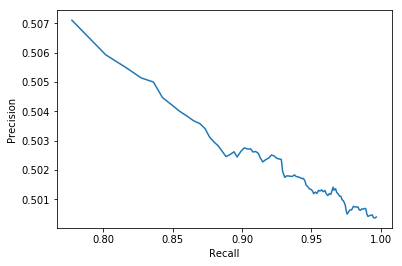

In [61]:
eval_membership_inference(distilled_at_T, train_loader, out_loader)

## Results
<table><tr>
<td> <img src="images/ML_leaks3_vs_VGG11.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="images/ML_leaks3_vs_distilled.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="images/ML_leaks3_vs_distilled_at20_1.png" alt="Drawing" style="width: 350px;"/> </td>
</tr><tr>
<td> VGG11 vs. ML leaks 3 </td>
<td> Distilled VGG11(T=1) vs ML leaks 3 </td>
<td> Distilled VGG11(T=20) vs ML leaks 3 </td>    
</tr><table>
    
### Notes
1. Summary of networks accuracies:
    - VGG11 accuracy: train = 90.78%; test = 82.94%
    - Distilled (train T=1, inference T=1): train = 90.47%; test = 82.81%
    - Distilled with temp (train T = 20, inference T=1): train = 65.32  %; test = 66.24 %

2. Distilled network at T=1 is less robust vs. the ML-leaks 3 attack than the simple VGG11 
3. Distilling the networ at T=20 and evaluating at T=1 provides same accuracy while increasing the robustness of the model

In [ ]:
save_checkpoint(model=distilled_at_T.model, accuracy={'Train':91.92, 'Test':83.72}, loss=2.825024, epoch = 60,
                data_descriptor='CIFAR10 - half dataset, distilled (T=20)', optimizer=optimizer,
                path='../../../Trained_models/CIFAR10/',filename = 'half_CIFAR10_distilled_T20_vgg11')